# Benchmarking the scANVI fix

As of the scvi-tools 1.1.0 release, we have included a critical bug fix for [scANVI](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html), which is used for semi-supervised modeling of single-cell transcriptomics data.  In previous versions, the classifier portion of the model incorrectly treated logits outputs as probabilities, generally leading to the following consequences:

- Increased number of training epochs required for the convergence of the classification loss
- Accuracy, F1 score, and calibration error indicative of a poorly performing classifier
- Inferior performance in label transferring to query data
- Latent space with conservation of cell-type variability

Users may refer to the corresponding [pull request](https://github.com/scverse/scvi-tools/pull/2301) for more details about the fix. 

In this tutorial, we use the data and preprocessing steps in [Atlas-level integration of lung data](https://docs.scvi-tools.org/en/latest/tutorials/notebooks/scrna/harmonization.html), while comparing the previous and fixed models. In addition to these, we include in our comparison a version of the fixed model with a simpler, linear classifier. We hypothesize that the previous (more complex) MLP classifier was necessary since the model specification was incorrect.

## Imports and downloading data

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scib_metrics.benchmark import Benchmarker

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version", scvi.__version__)

Seed set to 0


Last run with scvi-tools version 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [5]:
adata_path = os.path.join(save_dir.name, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

  0%|          | 0.00/972M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

## Preprocessing data

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections.

In [6]:
adata.raw = adata  # keep full dimension safe
print(f"Number of genes before HVG selection: {adata.n_vars}")
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)
print(f"Number of genes after HVG selection: {adata.n_vars}")

Number of genes before HVG selection: 15148


/env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of genes after HVG selection: 2000


```{important}
We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

## Model setup and training scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
scvi_model.train(max_epochs=300)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/300 [00:00<?, ?it/s]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]


Epoch 1/300:   0%|          | 1/300 [00:01<07:54,  1.59s/it]


Epoch 1/300:   0%|          | 1/300 [00:01<07:54,  1.59s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]


Epoch 2/300:   0%|          | 1/300 [00:01<07:54,  1.59s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]


Epoch 2/300:   1%|          | 2/300 [00:02<06:18,  1.27s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]


Epoch 2/300:   1%|          | 2/300 [00:02<06:18,  1.27s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]


Epoch 3/300:   1%|          | 2/300 [00:02<06:18,  1.27s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]


Epoch 3/300:   1%|          | 3/300 [00:03<05:46,  1.17s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]


Epoch 3/300:   1%|          | 3/300 [00:03<05:46,  1.17s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]


Epoch 4/300:   1%|          | 3/300 [00:03<05:46,  1.17s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]


Epoch 4/300:   1%|▏         | 4/300 [00:04<05:31,  1.12s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]


Epoch 4/300:   1%|▏         | 4/300 [00:04<05:31,  1.12s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]


Epoch 5/300:   1%|▏         | 4/300 [00:04<05:31,  1.12s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]


Epoch 5/300:   2%|▏         | 5/300 [00:05<05:22,  1.09s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]


Epoch 5/300:   2%|▏         | 5/300 [00:05<05:22,  1.09s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]


Epoch 6/300:   2%|▏         | 5/300 [00:05<05:22,  1.09s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]


Epoch 6/300:   2%|▏         | 6/300 [00:06<05:16,  1.08s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]


Epoch 6/300:   2%|▏         | 6/300 [00:06<05:16,  1.08s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]


Epoch 7/300:   2%|▏         | 6/300 [00:06<05:16,  1.08s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]


Epoch 7/300:   2%|▏         | 7/300 [00:07<05:12,  1.07s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]


Epoch 7/300:   2%|▏         | 7/300 [00:07<05:12,  1.07s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]


Epoch 8/300:   2%|▏         | 7/300 [00:07<05:12,  1.07s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]


Epoch 8/300:   3%|▎         | 8/300 [00:08<05:09,  1.06s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]


Epoch 8/300:   3%|▎         | 8/300 [00:08<05:09,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]


Epoch 9/300:   3%|▎         | 8/300 [00:08<05:09,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]


Epoch 9/300:   3%|▎         | 9/300 [00:09<05:07,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]


Epoch 9/300:   3%|▎         | 9/300 [00:09<05:07,  1.06s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]


Epoch 10/300:   3%|▎         | 9/300 [00:09<05:07,  1.06s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]


Epoch 10/300:   3%|▎         | 10/300 [00:10<05:05,  1.05s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]


Epoch 10/300:   3%|▎         | 10/300 [00:10<05:05,  1.05s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]


Epoch 11/300:   3%|▎         | 10/300 [00:10<05:05,  1.05s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]


Epoch 11/300:   4%|▎         | 11/300 [00:12<05:03,  1.05s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]


Epoch 11/300:   4%|▎         | 11/300 [00:12<05:03,  1.05s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]


Epoch 12/300:   4%|▎         | 11/300 [00:12<05:03,  1.05s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]


Epoch 12/300:   4%|▍         | 12/300 [00:13<05:02,  1.05s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]


Epoch 12/300:   4%|▍         | 12/300 [00:13<05:02,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]


Epoch 13/300:   4%|▍         | 12/300 [00:13<05:02,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]


Epoch 13/300:   4%|▍         | 13/300 [00:14<05:01,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]


Epoch 13/300:   4%|▍         | 13/300 [00:14<05:01,  1.05s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]


Epoch 14/300:   4%|▍         | 13/300 [00:14<05:01,  1.05s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]


Epoch 14/300:   5%|▍         | 14/300 [00:15<04:59,  1.05s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]


Epoch 14/300:   5%|▍         | 14/300 [00:15<04:59,  1.05s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]


Epoch 15/300:   5%|▍         | 14/300 [00:15<04:59,  1.05s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]


Epoch 15/300:   5%|▌         | 15/300 [00:16<04:58,  1.05s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]


Epoch 15/300:   5%|▌         | 15/300 [00:16<04:58,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]


Epoch 16/300:   5%|▌         | 15/300 [00:16<04:58,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]


Epoch 16/300:   5%|▌         | 16/300 [00:17<04:58,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]


Epoch 16/300:   5%|▌         | 16/300 [00:17<04:58,  1.05s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]


Epoch 17/300:   5%|▌         | 16/300 [00:17<04:58,  1.05s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]


Epoch 17/300:   6%|▌         | 17/300 [00:18<04:59,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]


Epoch 17/300:   6%|▌         | 17/300 [00:18<04:59,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]


Epoch 18/300:   6%|▌         | 17/300 [00:18<04:59,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]


Epoch 18/300:   6%|▌         | 18/300 [00:19<04:59,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]


Epoch 18/300:   6%|▌         | 18/300 [00:19<04:59,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]


Epoch 19/300:   6%|▌         | 18/300 [00:19<04:59,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]


Epoch 19/300:   6%|▋         | 19/300 [00:20<04:58,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]


Epoch 19/300:   6%|▋         | 19/300 [00:20<04:58,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]


Epoch 20/300:   6%|▋         | 19/300 [00:20<04:58,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]


Epoch 20/300:   7%|▋         | 20/300 [00:21<04:58,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]


Epoch 20/300:   7%|▋         | 20/300 [00:21<04:58,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 21/300:   7%|▋         | 20/300 [00:21<04:58,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 21/300:   7%|▋         | 21/300 [00:22<04:57,  1.07s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 21/300:   7%|▋         | 21/300 [00:22<04:57,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]


Epoch 22/300:   7%|▋         | 21/300 [00:22<04:57,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]


Epoch 22/300:   7%|▋         | 22/300 [00:23<04:56,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]


Epoch 22/300:   7%|▋         | 22/300 [00:23<04:56,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]


Epoch 23/300:   7%|▋         | 22/300 [00:23<04:56,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]


Epoch 23/300:   8%|▊         | 23/300 [00:24<04:55,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]


Epoch 23/300:   8%|▊         | 23/300 [00:24<04:55,  1.07s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]


Epoch 24/300:   8%|▊         | 23/300 [00:24<04:55,  1.07s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]


Epoch 24/300:   8%|▊         | 24/300 [00:25<04:54,  1.07s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]


Epoch 24/300:   8%|▊         | 24/300 [00:25<04:54,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]


Epoch 25/300:   8%|▊         | 24/300 [00:25<04:54,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]


Epoch 25/300:   8%|▊         | 25/300 [00:26<04:53,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]


Epoch 25/300:   8%|▊         | 25/300 [00:26<04:53,  1.07s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]


Epoch 26/300:   8%|▊         | 25/300 [00:26<04:53,  1.07s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]


Epoch 26/300:   9%|▊         | 26/300 [00:27<04:52,  1.07s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]


Epoch 26/300:   9%|▊         | 26/300 [00:27<04:52,  1.07s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]


Epoch 27/300:   9%|▊         | 26/300 [00:27<04:52,  1.07s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]


Epoch 27/300:   9%|▉         | 27/300 [00:29<04:51,  1.07s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]


Epoch 27/300:   9%|▉         | 27/300 [00:29<04:51,  1.07s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]


Epoch 28/300:   9%|▉         | 27/300 [00:29<04:51,  1.07s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]


Epoch 28/300:   9%|▉         | 28/300 [00:30<04:50,  1.07s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]


Epoch 28/300:   9%|▉         | 28/300 [00:30<04:50,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 29/300:   9%|▉         | 28/300 [00:30<04:50,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 29/300:  10%|▉         | 29/300 [00:31<04:49,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 29/300:  10%|▉         | 29/300 [00:31<04:49,  1.07s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 30/300:  10%|▉         | 29/300 [00:31<04:49,  1.07s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 30/300:  10%|█         | 30/300 [00:32<04:48,  1.07s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 30/300:  10%|█         | 30/300 [00:32<04:48,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]


Epoch 31/300:  10%|█         | 30/300 [00:32<04:48,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]


Epoch 31/300:  10%|█         | 31/300 [00:33<04:47,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]


Epoch 31/300:  10%|█         | 31/300 [00:33<04:47,  1.07s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 32/300:  10%|█         | 31/300 [00:33<04:47,  1.07s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 32/300:  11%|█         | 32/300 [00:34<04:46,  1.07s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 32/300:  11%|█         | 32/300 [00:34<04:46,  1.07s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]


Epoch 33/300:  11%|█         | 32/300 [00:34<04:46,  1.07s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]


Epoch 33/300:  11%|█         | 33/300 [00:35<04:45,  1.07s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]


Epoch 33/300:  11%|█         | 33/300 [00:35<04:45,  1.07s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]


Epoch 34/300:  11%|█         | 33/300 [00:35<04:45,  1.07s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]


Epoch 34/300:  11%|█▏        | 34/300 [00:36<04:44,  1.07s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]


Epoch 34/300:  11%|█▏        | 34/300 [00:36<04:44,  1.07s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]


Epoch 35/300:  11%|█▏        | 34/300 [00:36<04:44,  1.07s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]


Epoch 35/300:  12%|█▏        | 35/300 [00:37<04:43,  1.07s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]


Epoch 35/300:  12%|█▏        | 35/300 [00:37<04:43,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]


Epoch 36/300:  12%|█▏        | 35/300 [00:37<04:43,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]


Epoch 36/300:  12%|█▏        | 36/300 [00:38<04:42,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]


Epoch 36/300:  12%|█▏        | 36/300 [00:38<04:42,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]


Epoch 37/300:  12%|█▏        | 36/300 [00:38<04:42,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]


Epoch 37/300:  12%|█▏        | 37/300 [00:39<04:41,  1.07s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]


Epoch 37/300:  12%|█▏        | 37/300 [00:39<04:41,  1.07s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]


Epoch 38/300:  12%|█▏        | 37/300 [00:39<04:41,  1.07s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]


Epoch 38/300:  13%|█▎        | 38/300 [00:40<04:40,  1.07s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]


Epoch 38/300:  13%|█▎        | 38/300 [00:40<04:40,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]


Epoch 39/300:  13%|█▎        | 38/300 [00:40<04:40,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]


Epoch 39/300:  13%|█▎        | 39/300 [00:41<04:39,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]


Epoch 39/300:  13%|█▎        | 39/300 [00:41<04:39,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 40/300:  13%|█▎        | 39/300 [00:41<04:39,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 40/300:  13%|█▎        | 40/300 [00:42<04:38,  1.07s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 40/300:  13%|█▎        | 40/300 [00:42<04:38,  1.07s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]


Epoch 41/300:  13%|█▎        | 40/300 [00:42<04:38,  1.07s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]


Epoch 41/300:  14%|█▎        | 41/300 [00:44<04:37,  1.07s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]


Epoch 41/300:  14%|█▎        | 41/300 [00:44<04:37,  1.07s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 42/300:  14%|█▎        | 41/300 [00:44<04:37,  1.07s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 42/300:  14%|█▍        | 42/300 [00:45<04:36,  1.07s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 42/300:  14%|█▍        | 42/300 [00:45<04:36,  1.07s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 43/300:  14%|█▍        | 42/300 [00:45<04:36,  1.07s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 43/300:  14%|█▍        | 43/300 [00:46<04:35,  1.07s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 43/300:  14%|█▍        | 43/300 [00:46<04:35,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 44/300:  14%|█▍        | 43/300 [00:46<04:35,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 44/300:  15%|█▍        | 44/300 [00:47<04:34,  1.07s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 44/300:  15%|█▍        | 44/300 [00:47<04:34,  1.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 45/300:  15%|█▍        | 44/300 [00:47<04:34,  1.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 45/300:  15%|█▌        | 45/300 [00:48<04:33,  1.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 45/300:  15%|█▌        | 45/300 [00:48<04:33,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]


Epoch 46/300:  15%|█▌        | 45/300 [00:48<04:33,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]


Epoch 46/300:  15%|█▌        | 46/300 [00:49<04:32,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]


Epoch 46/300:  15%|█▌        | 46/300 [00:49<04:32,  1.07s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]


Epoch 47/300:  15%|█▌        | 46/300 [00:49<04:32,  1.07s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]


Epoch 47/300:  16%|█▌        | 47/300 [00:50<04:30,  1.07s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]


Epoch 47/300:  16%|█▌        | 47/300 [00:50<04:30,  1.07s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]


Epoch 48/300:  16%|█▌        | 47/300 [00:50<04:30,  1.07s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]


Epoch 48/300:  16%|█▌        | 48/300 [00:51<04:29,  1.07s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]


Epoch 48/300:  16%|█▌        | 48/300 [00:51<04:29,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 49/300:  16%|█▌        | 48/300 [00:51<04:29,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 49/300:  16%|█▋        | 49/300 [00:52<04:28,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 49/300:  16%|█▋        | 49/300 [00:52<04:28,  1.07s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]


Epoch 50/300:  16%|█▋        | 49/300 [00:52<04:28,  1.07s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]


Epoch 50/300:  17%|█▋        | 50/300 [00:53<04:27,  1.07s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]


Epoch 50/300:  17%|█▋        | 50/300 [00:53<04:27,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]


Epoch 51/300:  17%|█▋        | 50/300 [00:53<04:27,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]


Epoch 51/300:  17%|█▋        | 51/300 [00:54<04:26,  1.07s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]


Epoch 51/300:  17%|█▋        | 51/300 [00:54<04:26,  1.07s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]


Epoch 52/300:  17%|█▋        | 51/300 [00:54<04:26,  1.07s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]


Epoch 52/300:  17%|█▋        | 52/300 [00:55<04:25,  1.07s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]


Epoch 52/300:  17%|█▋        | 52/300 [00:55<04:25,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 53/300:  17%|█▋        | 52/300 [00:55<04:25,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 53/300:  18%|█▊        | 53/300 [00:56<04:24,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 53/300:  18%|█▊        | 53/300 [00:56<04:24,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]


Epoch 54/300:  18%|█▊        | 53/300 [00:56<04:24,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]


Epoch 54/300:  18%|█▊        | 54/300 [00:57<04:23,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]


Epoch 54/300:  18%|█▊        | 54/300 [00:57<04:23,  1.07s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]


Epoch 55/300:  18%|█▊        | 54/300 [00:57<04:23,  1.07s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]


Epoch 55/300:  18%|█▊        | 55/300 [00:58<04:19,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]


Epoch 55/300:  18%|█▊        | 55/300 [00:58<04:19,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 56/300:  18%|█▊        | 55/300 [00:58<04:19,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 56/300:  19%|█▊        | 56/300 [01:00<04:15,  1.05s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]


Epoch 56/300:  19%|█▊        | 56/300 [01:00<04:15,  1.05s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 57/300:  19%|█▊        | 56/300 [01:00<04:15,  1.05s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 57/300:  19%|█▉        | 57/300 [01:01<04:12,  1.04s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 57/300:  19%|█▉        | 57/300 [01:01<04:12,  1.04s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 58/300:  19%|█▉        | 57/300 [01:01<04:12,  1.04s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 58/300:  19%|█▉        | 58/300 [01:02<04:10,  1.03s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 58/300:  19%|█▉        | 58/300 [01:02<04:10,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]


Epoch 59/300:  19%|█▉        | 58/300 [01:02<04:10,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]


Epoch 59/300:  20%|█▉        | 59/300 [01:03<04:08,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]


Epoch 59/300:  20%|█▉        | 59/300 [01:03<04:08,  1.03s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]


Epoch 60/300:  20%|█▉        | 59/300 [01:03<04:08,  1.03s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]


Epoch 60/300:  20%|██        | 60/300 [01:04<04:10,  1.04s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]


Epoch 60/300:  20%|██        | 60/300 [01:04<04:10,  1.04s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]


Epoch 61/300:  20%|██        | 60/300 [01:04<04:10,  1.04s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]


Epoch 61/300:  20%|██        | 61/300 [01:05<04:11,  1.05s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]


Epoch 61/300:  20%|██        | 61/300 [01:05<04:11,  1.05s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]


Epoch 62/300:  20%|██        | 61/300 [01:05<04:11,  1.05s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]


Epoch 62/300:  21%|██        | 62/300 [01:06<04:11,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]


Epoch 62/300:  21%|██        | 62/300 [01:06<04:11,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 63/300:  21%|██        | 62/300 [01:06<04:11,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 63/300:  21%|██        | 63/300 [01:07<04:10,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 63/300:  21%|██        | 63/300 [01:07<04:10,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 64/300:  21%|██        | 63/300 [01:07<04:10,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 64/300:  21%|██▏       | 64/300 [01:08<04:08,  1.05s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 64/300:  21%|██▏       | 64/300 [01:08<04:08,  1.05s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 65/300:  21%|██▏       | 64/300 [01:08<04:08,  1.05s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 65/300:  22%|██▏       | 65/300 [01:09<04:05,  1.05s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 65/300:  22%|██▏       | 65/300 [01:09<04:05,  1.05s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]


Epoch 66/300:  22%|██▏       | 65/300 [01:09<04:05,  1.05s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]


Epoch 66/300:  22%|██▏       | 66/300 [01:10<04:03,  1.04s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]


Epoch 66/300:  22%|██▏       | 66/300 [01:10<04:03,  1.04s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]


Epoch 67/300:  22%|██▏       | 66/300 [01:10<04:03,  1.04s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]


Epoch 67/300:  22%|██▏       | 67/300 [01:11<04:00,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]


Epoch 67/300:  22%|██▏       | 67/300 [01:11<04:00,  1.03s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 68/300:  22%|██▏       | 67/300 [01:11<04:00,  1.03s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 68/300:  23%|██▎       | 68/300 [01:12<03:58,  1.03s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 68/300:  23%|██▎       | 68/300 [01:12<03:58,  1.03s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]


Epoch 69/300:  23%|██▎       | 68/300 [01:12<03:58,  1.03s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]


Epoch 69/300:  23%|██▎       | 69/300 [01:13<03:57,  1.03s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]


Epoch 69/300:  23%|██▎       | 69/300 [01:13<03:57,  1.03s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]


Epoch 70/300:  23%|██▎       | 69/300 [01:13<03:57,  1.03s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]


Epoch 70/300:  23%|██▎       | 70/300 [01:14<03:56,  1.03s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]


Epoch 70/300:  23%|██▎       | 70/300 [01:14<03:56,  1.03s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]


Epoch 71/300:  23%|██▎       | 70/300 [01:14<03:56,  1.03s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]


Epoch 71/300:  24%|██▎       | 71/300 [01:15<03:55,  1.03s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]


Epoch 71/300:  24%|██▎       | 71/300 [01:15<03:55,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 72/300:  24%|██▎       | 71/300 [01:15<03:55,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 72/300:  24%|██▍       | 72/300 [01:16<03:54,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 72/300:  24%|██▍       | 72/300 [01:16<03:54,  1.03s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]


Epoch 73/300:  24%|██▍       | 72/300 [01:16<03:54,  1.03s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]


Epoch 73/300:  24%|██▍       | 73/300 [01:17<03:52,  1.02s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]


Epoch 73/300:  24%|██▍       | 73/300 [01:17<03:52,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 74/300:  24%|██▍       | 73/300 [01:17<03:52,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 74/300:  25%|██▍       | 74/300 [01:18<03:51,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]


Epoch 74/300:  25%|██▍       | 74/300 [01:18<03:51,  1.02s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]


Epoch 75/300:  25%|██▍       | 74/300 [01:18<03:51,  1.02s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]


Epoch 75/300:  25%|██▌       | 75/300 [01:19<03:50,  1.02s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]


Epoch 75/300:  25%|██▌       | 75/300 [01:19<03:50,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]


Epoch 76/300:  25%|██▌       | 75/300 [01:19<03:50,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]


Epoch 76/300:  25%|██▌       | 76/300 [01:20<03:48,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]


Epoch 76/300:  25%|██▌       | 76/300 [01:20<03:48,  1.02s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]


Epoch 77/300:  25%|██▌       | 76/300 [01:20<03:48,  1.02s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]


Epoch 77/300:  26%|██▌       | 77/300 [01:21<03:47,  1.02s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]


Epoch 77/300:  26%|██▌       | 77/300 [01:21<03:47,  1.02s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]


Epoch 78/300:  26%|██▌       | 77/300 [01:21<03:47,  1.02s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]


Epoch 78/300:  26%|██▌       | 78/300 [01:22<03:46,  1.02s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]


Epoch 78/300:  26%|██▌       | 78/300 [01:22<03:46,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]


Epoch 79/300:  26%|██▌       | 78/300 [01:22<03:46,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]


Epoch 79/300:  26%|██▋       | 79/300 [01:23<03:45,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]


Epoch 79/300:  26%|██▋       | 79/300 [01:23<03:45,  1.02s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]


Epoch 80/300:  26%|██▋       | 79/300 [01:23<03:45,  1.02s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]


Epoch 80/300:  27%|██▋       | 80/300 [01:24<03:44,  1.02s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]


Epoch 80/300:  27%|██▋       | 80/300 [01:24<03:44,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]


Epoch 81/300:  27%|██▋       | 80/300 [01:24<03:44,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]


Epoch 81/300:  27%|██▋       | 81/300 [01:25<03:43,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]


Epoch 81/300:  27%|██▋       | 81/300 [01:25<03:43,  1.02s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 82/300:  27%|██▋       | 81/300 [01:25<03:43,  1.02s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 82/300:  27%|██▋       | 82/300 [01:26<03:42,  1.02s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]


Epoch 82/300:  27%|██▋       | 82/300 [01:26<03:42,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]


Epoch 83/300:  27%|██▋       | 82/300 [01:26<03:42,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]


Epoch 83/300:  28%|██▊       | 83/300 [01:27<03:41,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]


Epoch 83/300:  28%|██▊       | 83/300 [01:27<03:41,  1.02s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]


Epoch 84/300:  28%|██▊       | 83/300 [01:27<03:41,  1.02s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]


Epoch 84/300:  28%|██▊       | 84/300 [01:28<03:40,  1.02s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]


Epoch 84/300:  28%|██▊       | 84/300 [01:28<03:40,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]


Epoch 85/300:  28%|██▊       | 84/300 [01:28<03:40,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]


Epoch 85/300:  28%|██▊       | 85/300 [01:29<03:39,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]


Epoch 85/300:  28%|██▊       | 85/300 [01:29<03:39,  1.02s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]


Epoch 86/300:  28%|██▊       | 85/300 [01:29<03:39,  1.02s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]


Epoch 86/300:  29%|██▊       | 86/300 [01:30<03:38,  1.02s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]


Epoch 86/300:  29%|██▊       | 86/300 [01:30<03:38,  1.02s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]


Epoch 87/300:  29%|██▊       | 86/300 [01:30<03:38,  1.02s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]


Epoch 87/300:  29%|██▉       | 87/300 [01:31<03:37,  1.02s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]


Epoch 87/300:  29%|██▉       | 87/300 [01:31<03:37,  1.02s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]


Epoch 88/300:  29%|██▉       | 87/300 [01:31<03:37,  1.02s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]


Epoch 88/300:  29%|██▉       | 88/300 [01:32<03:36,  1.02s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]


Epoch 88/300:  29%|██▉       | 88/300 [01:32<03:36,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 89/300:  29%|██▉       | 88/300 [01:32<03:36,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 89/300:  30%|██▉       | 89/300 [01:33<03:35,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]


Epoch 89/300:  30%|██▉       | 89/300 [01:33<03:35,  1.02s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]


Epoch 90/300:  30%|██▉       | 89/300 [01:33<03:35,  1.02s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]


Epoch 90/300:  30%|███       | 90/300 [01:34<03:34,  1.02s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]


Epoch 90/300:  30%|███       | 90/300 [01:34<03:34,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 91/300:  30%|███       | 90/300 [01:34<03:34,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 91/300:  30%|███       | 91/300 [01:35<03:33,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 91/300:  30%|███       | 91/300 [01:35<03:33,  1.02s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]


Epoch 92/300:  30%|███       | 91/300 [01:35<03:33,  1.02s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]


Epoch 92/300:  31%|███       | 92/300 [01:37<03:32,  1.02s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]


Epoch 92/300:  31%|███       | 92/300 [01:37<03:32,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]


Epoch 93/300:  31%|███       | 92/300 [01:37<03:32,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]


Epoch 93/300:  31%|███       | 93/300 [01:38<03:31,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]


Epoch 93/300:  31%|███       | 93/300 [01:38<03:31,  1.02s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]


Epoch 94/300:  31%|███       | 93/300 [01:38<03:31,  1.02s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]


Epoch 94/300:  31%|███▏      | 94/300 [01:39<03:30,  1.02s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]


Epoch 94/300:  31%|███▏      | 94/300 [01:39<03:30,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]


Epoch 95/300:  31%|███▏      | 94/300 [01:39<03:30,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]


Epoch 95/300:  32%|███▏      | 95/300 [01:40<03:29,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]


Epoch 95/300:  32%|███▏      | 95/300 [01:40<03:29,  1.02s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]


Epoch 96/300:  32%|███▏      | 95/300 [01:40<03:29,  1.02s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]


Epoch 96/300:  32%|███▏      | 96/300 [01:41<03:28,  1.02s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]


Epoch 96/300:  32%|███▏      | 96/300 [01:41<03:28,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 97/300:  32%|███▏      | 96/300 [01:41<03:28,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 97/300:  32%|███▏      | 97/300 [01:42<03:27,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]


Epoch 97/300:  32%|███▏      | 97/300 [01:42<03:27,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 98/300:  32%|███▏      | 97/300 [01:42<03:27,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 98/300:  33%|███▎      | 98/300 [01:43<03:26,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]


Epoch 98/300:  33%|███▎      | 98/300 [01:43<03:26,  1.02s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]


Epoch 99/300:  33%|███▎      | 98/300 [01:43<03:26,  1.02s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]


Epoch 99/300:  33%|███▎      | 99/300 [01:44<03:25,  1.02s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]


Epoch 99/300:  33%|███▎      | 99/300 [01:44<03:25,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 100/300:  33%|███▎      | 99/300 [01:44<03:25,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 100/300:  33%|███▎      | 100/300 [01:45<03:24,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 100/300:  33%|███▎      | 100/300 [01:45<03:24,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 101/300:  33%|███▎      | 100/300 [01:45<03:24,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 101/300:  34%|███▎      | 101/300 [01:46<03:23,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]


Epoch 101/300:  34%|███▎      | 101/300 [01:46<03:23,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 102/300:  34%|███▎      | 101/300 [01:46<03:23,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 102/300:  34%|███▍      | 102/300 [01:47<03:22,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]


Epoch 102/300:  34%|███▍      | 102/300 [01:47<03:22,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 103/300:  34%|███▍      | 102/300 [01:47<03:22,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 103/300:  34%|███▍      | 103/300 [01:48<03:21,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]


Epoch 103/300:  34%|███▍      | 103/300 [01:48<03:21,  1.02s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]


Epoch 104/300:  34%|███▍      | 103/300 [01:48<03:21,  1.02s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]


Epoch 104/300:  35%|███▍      | 104/300 [01:49<03:20,  1.02s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]


Epoch 104/300:  35%|███▍      | 104/300 [01:49<03:20,  1.02s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]


Epoch 105/300:  35%|███▍      | 104/300 [01:49<03:20,  1.02s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]


Epoch 105/300:  35%|███▌      | 105/300 [01:50<03:19,  1.02s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]


Epoch 105/300:  35%|███▌      | 105/300 [01:50<03:19,  1.02s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 106/300:  35%|███▌      | 105/300 [01:50<03:19,  1.02s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 106/300:  35%|███▌      | 106/300 [01:51<03:18,  1.02s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]


Epoch 106/300:  35%|███▌      | 106/300 [01:51<03:18,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 107/300:  35%|███▌      | 106/300 [01:51<03:18,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 107/300:  36%|███▌      | 107/300 [01:52<03:17,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 107/300:  36%|███▌      | 107/300 [01:52<03:17,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 108/300:  36%|███▌      | 107/300 [01:52<03:17,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 108/300:  36%|███▌      | 108/300 [01:53<03:16,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]


Epoch 108/300:  36%|███▌      | 108/300 [01:53<03:16,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 109/300:  36%|███▌      | 108/300 [01:53<03:16,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 109/300:  36%|███▋      | 109/300 [01:54<03:15,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 109/300:  36%|███▋      | 109/300 [01:54<03:15,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]


Epoch 110/300:  36%|███▋      | 109/300 [01:54<03:15,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]


Epoch 110/300:  37%|███▋      | 110/300 [01:55<03:14,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]


Epoch 110/300:  37%|███▋      | 110/300 [01:55<03:14,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]


Epoch 111/300:  37%|███▋      | 110/300 [01:55<03:14,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]


Epoch 111/300:  37%|███▋      | 111/300 [01:56<03:13,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]


Epoch 111/300:  37%|███▋      | 111/300 [01:56<03:13,  1.02s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]


Epoch 112/300:  37%|███▋      | 111/300 [01:56<03:13,  1.02s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]


Epoch 112/300:  37%|███▋      | 112/300 [01:57<03:12,  1.02s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]


Epoch 112/300:  37%|███▋      | 112/300 [01:57<03:12,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 113/300:  37%|███▋      | 112/300 [01:57<03:12,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 113/300:  38%|███▊      | 113/300 [01:58<03:11,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 113/300:  38%|███▊      | 113/300 [01:58<03:11,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 114/300:  38%|███▊      | 113/300 [01:58<03:11,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 114/300:  38%|███▊      | 114/300 [01:59<03:10,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 114/300:  38%|███▊      | 114/300 [01:59<03:10,  1.02s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]


Epoch 115/300:  38%|███▊      | 114/300 [01:59<03:10,  1.02s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]


Epoch 115/300:  38%|███▊      | 115/300 [02:00<03:09,  1.02s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]


Epoch 115/300:  38%|███▊      | 115/300 [02:00<03:09,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 116/300:  38%|███▊      | 115/300 [02:00<03:09,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 116/300:  39%|███▊      | 116/300 [02:01<03:07,  1.02s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]


Epoch 116/300:  39%|███▊      | 116/300 [02:01<03:07,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 117/300:  39%|███▊      | 116/300 [02:01<03:07,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 117/300:  39%|███▉      | 117/300 [02:02<03:06,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 117/300:  39%|███▉      | 117/300 [02:02<03:06,  1.02s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]


Epoch 118/300:  39%|███▉      | 117/300 [02:02<03:06,  1.02s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]


Epoch 118/300:  39%|███▉      | 118/300 [02:03<03:05,  1.02s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]


Epoch 118/300:  39%|███▉      | 118/300 [02:03<03:05,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 119/300:  39%|███▉      | 118/300 [02:03<03:05,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 119/300:  40%|███▉      | 119/300 [02:04<03:04,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]


Epoch 119/300:  40%|███▉      | 119/300 [02:04<03:04,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]


Epoch 120/300:  40%|███▉      | 119/300 [02:04<03:04,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]


Epoch 120/300:  40%|████      | 120/300 [02:05<03:03,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]


Epoch 120/300:  40%|████      | 120/300 [02:05<03:03,  1.02s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]


Epoch 121/300:  40%|████      | 120/300 [02:05<03:03,  1.02s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]


Epoch 121/300:  40%|████      | 121/300 [02:06<03:02,  1.02s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]


Epoch 121/300:  40%|████      | 121/300 [02:06<03:02,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 122/300:  40%|████      | 121/300 [02:06<03:02,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 122/300:  41%|████      | 122/300 [02:07<03:01,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


Epoch 122/300:  41%|████      | 122/300 [02:07<03:01,  1.02s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 123/300:  41%|████      | 122/300 [02:07<03:01,  1.02s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 123/300:  41%|████      | 123/300 [02:08<03:00,  1.02s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]


Epoch 123/300:  41%|████      | 123/300 [02:08<03:00,  1.02s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]


Epoch 124/300:  41%|████      | 123/300 [02:08<03:00,  1.02s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]


Epoch 124/300:  41%|████▏     | 124/300 [02:09<02:59,  1.02s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]


Epoch 124/300:  41%|████▏     | 124/300 [02:09<02:59,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]


Epoch 125/300:  41%|████▏     | 124/300 [02:09<02:59,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]


Epoch 125/300:  42%|████▏     | 125/300 [02:10<02:58,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]


Epoch 125/300:  42%|████▏     | 125/300 [02:10<02:58,  1.02s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]


Epoch 126/300:  42%|████▏     | 125/300 [02:10<02:58,  1.02s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]


Epoch 126/300:  42%|████▏     | 126/300 [02:11<02:57,  1.02s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]


Epoch 126/300:  42%|████▏     | 126/300 [02:11<02:57,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 127/300:  42%|████▏     | 126/300 [02:11<02:57,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 127/300:  42%|████▏     | 127/300 [02:12<02:56,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 127/300:  42%|████▏     | 127/300 [02:12<02:56,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 128/300:  42%|████▏     | 127/300 [02:12<02:56,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 128/300:  43%|████▎     | 128/300 [02:13<02:55,  1.02s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]


Epoch 128/300:  43%|████▎     | 128/300 [02:13<02:55,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]


Epoch 129/300:  43%|████▎     | 128/300 [02:13<02:55,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]


Epoch 129/300:  43%|████▎     | 129/300 [02:14<02:54,  1.02s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]


Epoch 129/300:  43%|████▎     | 129/300 [02:14<02:54,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 130/300:  43%|████▎     | 129/300 [02:14<02:54,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 130/300:  43%|████▎     | 130/300 [02:15<02:53,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 130/300:  43%|████▎     | 130/300 [02:15<02:53,  1.02s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]


Epoch 131/300:  43%|████▎     | 130/300 [02:15<02:53,  1.02s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]


Epoch 131/300:  44%|████▎     | 131/300 [02:16<02:52,  1.02s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]


Epoch 131/300:  44%|████▎     | 131/300 [02:16<02:52,  1.02s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]


Epoch 132/300:  44%|████▎     | 131/300 [02:16<02:52,  1.02s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]


Epoch 132/300:  44%|████▍     | 132/300 [02:17<02:51,  1.02s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]


Epoch 132/300:  44%|████▍     | 132/300 [02:17<02:51,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 133/300:  44%|████▍     | 132/300 [02:17<02:51,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 133/300:  44%|████▍     | 133/300 [02:18<02:51,  1.02s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]


Epoch 133/300:  44%|████▍     | 133/300 [02:18<02:51,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 134/300:  44%|████▍     | 133/300 [02:18<02:51,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 134/300:  45%|████▍     | 134/300 [02:19<02:50,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]


Epoch 134/300:  45%|████▍     | 134/300 [02:19<02:50,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 135/300:  45%|████▍     | 134/300 [02:19<02:50,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 135/300:  45%|████▌     | 135/300 [02:20<02:48,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]


Epoch 135/300:  45%|████▌     | 135/300 [02:20<02:48,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]


Epoch 136/300:  45%|████▌     | 135/300 [02:20<02:48,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]


Epoch 136/300:  45%|████▌     | 136/300 [02:21<02:47,  1.02s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]


Epoch 136/300:  45%|████▌     | 136/300 [02:21<02:47,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 137/300:  45%|████▌     | 136/300 [02:21<02:47,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 137/300:  46%|████▌     | 137/300 [02:22<02:46,  1.02s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 137/300:  46%|████▌     | 137/300 [02:22<02:46,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 138/300:  46%|████▌     | 137/300 [02:22<02:46,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 138/300:  46%|████▌     | 138/300 [02:24<02:45,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 138/300:  46%|████▌     | 138/300 [02:24<02:45,  1.02s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]


Epoch 139/300:  46%|████▌     | 138/300 [02:24<02:45,  1.02s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]


Epoch 139/300:  46%|████▋     | 139/300 [02:25<02:44,  1.02s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]


Epoch 139/300:  46%|████▋     | 139/300 [02:25<02:44,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 140/300:  46%|████▋     | 139/300 [02:25<02:44,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 140/300:  47%|████▋     | 140/300 [02:26<02:43,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 140/300:  47%|████▋     | 140/300 [02:26<02:43,  1.02s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]


Epoch 141/300:  47%|████▋     | 140/300 [02:26<02:43,  1.02s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]


Epoch 141/300:  47%|████▋     | 141/300 [02:27<02:43,  1.03s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]


Epoch 141/300:  47%|████▋     | 141/300 [02:27<02:43,  1.03s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]


Epoch 142/300:  47%|████▋     | 141/300 [02:27<02:43,  1.03s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]


Epoch 142/300:  47%|████▋     | 142/300 [02:28<02:43,  1.04s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]


Epoch 142/300:  47%|████▋     | 142/300 [02:28<02:43,  1.04s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]


Epoch 143/300:  47%|████▋     | 142/300 [02:28<02:43,  1.04s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]


Epoch 143/300:  48%|████▊     | 143/300 [02:29<02:43,  1.04s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]


Epoch 143/300:  48%|████▊     | 143/300 [02:29<02:43,  1.04s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]


Epoch 144/300:  48%|████▊     | 143/300 [02:29<02:43,  1.04s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]


Epoch 144/300:  48%|████▊     | 144/300 [02:30<02:42,  1.04s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]


Epoch 144/300:  48%|████▊     | 144/300 [02:30<02:42,  1.04s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]


Epoch 145/300:  48%|████▊     | 144/300 [02:30<02:42,  1.04s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]


Epoch 145/300:  48%|████▊     | 145/300 [02:31<02:41,  1.04s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]


Epoch 145/300:  48%|████▊     | 145/300 [02:31<02:41,  1.04s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 146/300:  48%|████▊     | 145/300 [02:31<02:41,  1.04s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 146/300:  49%|████▊     | 146/300 [02:32<02:39,  1.03s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 146/300:  49%|████▊     | 146/300 [02:32<02:39,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 147/300:  49%|████▊     | 146/300 [02:32<02:39,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 147/300:  49%|████▉     | 147/300 [02:33<02:37,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 147/300:  49%|████▉     | 147/300 [02:33<02:37,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 148/300:  49%|████▉     | 147/300 [02:33<02:37,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 148/300:  49%|████▉     | 148/300 [02:34<02:35,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 148/300:  49%|████▉     | 148/300 [02:34<02:35,  1.03s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]


Epoch 149/300:  49%|████▉     | 148/300 [02:34<02:35,  1.03s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]


Epoch 149/300:  50%|████▉     | 149/300 [02:35<02:34,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]


Epoch 149/300:  50%|████▉     | 149/300 [02:35<02:34,  1.02s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 150/300:  50%|████▉     | 149/300 [02:35<02:34,  1.02s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 150/300:  50%|█████     | 150/300 [02:36<02:33,  1.02s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]


Epoch 150/300:  50%|█████     | 150/300 [02:36<02:33,  1.02s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]


Epoch 151/300:  50%|█████     | 150/300 [02:36<02:33,  1.02s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]


Epoch 151/300:  50%|█████     | 151/300 [02:37<02:32,  1.02s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]


Epoch 151/300:  50%|█████     | 151/300 [02:37<02:32,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]


Epoch 152/300:  50%|█████     | 151/300 [02:37<02:32,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]


Epoch 152/300:  51%|█████     | 152/300 [02:38<02:30,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]


Epoch 152/300:  51%|█████     | 152/300 [02:38<02:30,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 153/300:  51%|█████     | 152/300 [02:38<02:30,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 153/300:  51%|█████     | 153/300 [02:39<02:30,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]


Epoch 153/300:  51%|█████     | 153/300 [02:39<02:30,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]


Epoch 154/300:  51%|█████     | 153/300 [02:39<02:30,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]


Epoch 154/300:  51%|█████▏    | 154/300 [02:40<02:30,  1.03s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]


Epoch 154/300:  51%|█████▏    | 154/300 [02:40<02:30,  1.03s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]


Epoch 155/300:  51%|█████▏    | 154/300 [02:40<02:30,  1.03s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]


Epoch 155/300:  52%|█████▏    | 155/300 [02:41<02:30,  1.04s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]


Epoch 155/300:  52%|█████▏    | 155/300 [02:41<02:30,  1.04s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 156/300:  52%|█████▏    | 155/300 [02:41<02:30,  1.04s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 156/300:  52%|█████▏    | 156/300 [02:42<02:29,  1.04s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]


Epoch 156/300:  52%|█████▏    | 156/300 [02:42<02:29,  1.04s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 157/300:  52%|█████▏    | 156/300 [02:42<02:29,  1.04s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 157/300:  52%|█████▏    | 157/300 [02:43<02:28,  1.04s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]


Epoch 157/300:  52%|█████▏    | 157/300 [02:43<02:28,  1.04s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]


Epoch 158/300:  52%|█████▏    | 157/300 [02:43<02:28,  1.04s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]


Epoch 158/300:  53%|█████▎    | 158/300 [02:44<02:27,  1.04s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]


Epoch 158/300:  53%|█████▎    | 158/300 [02:44<02:27,  1.04s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]


Epoch 159/300:  53%|█████▎    | 158/300 [02:44<02:27,  1.04s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]


Epoch 159/300:  53%|█████▎    | 159/300 [02:45<02:27,  1.04s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]


Epoch 159/300:  53%|█████▎    | 159/300 [02:45<02:27,  1.04s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 160/300:  53%|█████▎    | 159/300 [02:45<02:27,  1.04s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 160/300:  53%|█████▎    | 160/300 [02:46<02:26,  1.05s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]


Epoch 160/300:  53%|█████▎    | 160/300 [02:46<02:26,  1.05s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]


Epoch 161/300:  53%|█████▎    | 160/300 [02:46<02:26,  1.05s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]


Epoch 161/300:  54%|█████▎    | 161/300 [02:47<02:25,  1.05s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]


Epoch 161/300:  54%|█████▎    | 161/300 [02:47<02:25,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 162/300:  54%|█████▎    | 161/300 [02:47<02:25,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 162/300:  54%|█████▍    | 162/300 [02:48<02:24,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]


Epoch 162/300:  54%|█████▍    | 162/300 [02:48<02:24,  1.05s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]


Epoch 163/300:  54%|█████▍    | 162/300 [02:48<02:24,  1.05s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]


Epoch 163/300:  54%|█████▍    | 163/300 [02:49<02:23,  1.05s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]


Epoch 163/300:  54%|█████▍    | 163/300 [02:49<02:23,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]


Epoch 164/300:  54%|█████▍    | 163/300 [02:49<02:23,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]


Epoch 164/300:  55%|█████▍    | 164/300 [02:50<02:22,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]


Epoch 164/300:  55%|█████▍    | 164/300 [02:50<02:22,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]


Epoch 165/300:  55%|█████▍    | 164/300 [02:50<02:22,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]


Epoch 165/300:  55%|█████▌    | 165/300 [02:52<02:21,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]


Epoch 165/300:  55%|█████▌    | 165/300 [02:52<02:21,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 166/300:  55%|█████▌    | 165/300 [02:52<02:21,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 166/300:  55%|█████▌    | 166/300 [02:53<02:20,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 166/300:  55%|█████▌    | 166/300 [02:53<02:20,  1.05s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]


Epoch 167/300:  55%|█████▌    | 166/300 [02:53<02:20,  1.05s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]


Epoch 167/300:  56%|█████▌    | 167/300 [02:54<02:19,  1.05s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]


Epoch 167/300:  56%|█████▌    | 167/300 [02:54<02:19,  1.05s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]


Epoch 168/300:  56%|█████▌    | 167/300 [02:54<02:19,  1.05s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]


Epoch 168/300:  56%|█████▌    | 168/300 [02:55<02:19,  1.06s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]


Epoch 168/300:  56%|█████▌    | 168/300 [02:55<02:19,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]


Epoch 169/300:  56%|█████▌    | 168/300 [02:55<02:19,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]


Epoch 169/300:  56%|█████▋    | 169/300 [02:56<02:18,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]


Epoch 169/300:  56%|█████▋    | 169/300 [02:56<02:18,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]


Epoch 170/300:  56%|█████▋    | 169/300 [02:56<02:18,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]


Epoch 170/300:  57%|█████▋    | 170/300 [02:57<02:17,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]


Epoch 170/300:  57%|█████▋    | 170/300 [02:57<02:17,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 171/300:  57%|█████▋    | 170/300 [02:57<02:17,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 171/300:  57%|█████▋    | 171/300 [02:58<02:15,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 171/300:  57%|█████▋    | 171/300 [02:58<02:15,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 172/300:  57%|█████▋    | 171/300 [02:58<02:15,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 172/300:  57%|█████▋    | 172/300 [02:59<02:14,  1.05s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]


Epoch 172/300:  57%|█████▋    | 172/300 [02:59<02:14,  1.05s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]


Epoch 173/300:  57%|█████▋    | 172/300 [02:59<02:14,  1.05s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]


Epoch 173/300:  58%|█████▊    | 173/300 [03:00<02:13,  1.05s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]


Epoch 173/300:  58%|█████▊    | 173/300 [03:00<02:13,  1.05s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]


Epoch 174/300:  58%|█████▊    | 173/300 [03:00<02:13,  1.05s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]


Epoch 174/300:  58%|█████▊    | 174/300 [03:01<02:12,  1.05s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]


Epoch 174/300:  58%|█████▊    | 174/300 [03:01<02:12,  1.05s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]


Epoch 175/300:  58%|█████▊    | 174/300 [03:01<02:12,  1.05s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]


Epoch 175/300:  58%|█████▊    | 175/300 [03:02<02:11,  1.05s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]


Epoch 175/300:  58%|█████▊    | 175/300 [03:02<02:11,  1.05s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 176/300:  58%|█████▊    | 175/300 [03:02<02:11,  1.05s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 176/300:  59%|█████▊    | 176/300 [03:03<02:09,  1.05s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 176/300:  59%|█████▊    | 176/300 [03:03<02:09,  1.05s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]


Epoch 177/300:  59%|█████▊    | 176/300 [03:03<02:09,  1.05s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]


Epoch 177/300:  59%|█████▉    | 177/300 [03:04<02:08,  1.05s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]


Epoch 177/300:  59%|█████▉    | 177/300 [03:04<02:08,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]


Epoch 178/300:  59%|█████▉    | 177/300 [03:04<02:08,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]


Epoch 178/300:  59%|█████▉    | 178/300 [03:05<02:07,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]


Epoch 178/300:  59%|█████▉    | 178/300 [03:05<02:07,  1.05s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]


Epoch 179/300:  59%|█████▉    | 178/300 [03:05<02:07,  1.05s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]


Epoch 179/300:  60%|█████▉    | 179/300 [03:06<02:06,  1.05s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]


Epoch 179/300:  60%|█████▉    | 179/300 [03:06<02:06,  1.05s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]


Epoch 180/300:  60%|█████▉    | 179/300 [03:06<02:06,  1.05s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]


Epoch 180/300:  60%|██████    | 180/300 [03:07<02:05,  1.04s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]


Epoch 180/300:  60%|██████    | 180/300 [03:07<02:05,  1.04s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]


Epoch 181/300:  60%|██████    | 180/300 [03:07<02:05,  1.04s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]


Epoch 181/300:  60%|██████    | 181/300 [03:08<02:04,  1.05s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]


Epoch 181/300:  60%|██████    | 181/300 [03:08<02:04,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 182/300:  60%|██████    | 181/300 [03:08<02:04,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 182/300:  61%|██████    | 182/300 [03:09<02:03,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 182/300:  61%|██████    | 182/300 [03:09<02:03,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 183/300:  61%|██████    | 182/300 [03:09<02:03,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 183/300:  61%|██████    | 183/300 [03:10<02:02,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]


Epoch 183/300:  61%|██████    | 183/300 [03:10<02:02,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 184/300:  61%|██████    | 183/300 [03:10<02:02,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 184/300:  61%|██████▏   | 184/300 [03:11<02:01,  1.05s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 184/300:  61%|██████▏   | 184/300 [03:11<02:01,  1.05s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]


Epoch 185/300:  61%|██████▏   | 184/300 [03:11<02:01,  1.05s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]


Epoch 185/300:  62%|██████▏   | 185/300 [03:12<01:59,  1.04s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]


Epoch 185/300:  62%|██████▏   | 185/300 [03:12<01:59,  1.04s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]


Epoch 186/300:  62%|██████▏   | 185/300 [03:12<01:59,  1.04s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]


Epoch 186/300:  62%|██████▏   | 186/300 [03:13<01:57,  1.03s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]


Epoch 186/300:  62%|██████▏   | 186/300 [03:13<01:57,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]


Epoch 187/300:  62%|██████▏   | 186/300 [03:13<01:57,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]


Epoch 187/300:  62%|██████▏   | 187/300 [03:15<01:56,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]


Epoch 187/300:  62%|██████▏   | 187/300 [03:15<01:56,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 188/300:  62%|██████▏   | 187/300 [03:15<01:56,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 188/300:  63%|██████▎   | 188/300 [03:16<01:54,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]


Epoch 188/300:  63%|██████▎   | 188/300 [03:16<01:54,  1.03s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]


Epoch 189/300:  63%|██████▎   | 188/300 [03:16<01:54,  1.03s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]


Epoch 189/300:  63%|██████▎   | 189/300 [03:17<01:53,  1.02s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]


Epoch 189/300:  63%|██████▎   | 189/300 [03:17<01:53,  1.02s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]


Epoch 190/300:  63%|██████▎   | 189/300 [03:17<01:53,  1.02s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]


Epoch 190/300:  63%|██████▎   | 190/300 [03:18<01:52,  1.03s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]


Epoch 190/300:  63%|██████▎   | 190/300 [03:18<01:52,  1.03s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]


Epoch 191/300:  63%|██████▎   | 190/300 [03:18<01:52,  1.03s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]


Epoch 191/300:  64%|██████▎   | 191/300 [03:19<01:51,  1.02s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]


Epoch 191/300:  64%|██████▎   | 191/300 [03:19<01:51,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]


Epoch 192/300:  64%|██████▎   | 191/300 [03:19<01:51,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]


Epoch 192/300:  64%|██████▍   | 192/300 [03:20<01:50,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]


Epoch 192/300:  64%|██████▍   | 192/300 [03:20<01:50,  1.02s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 193/300:  64%|██████▍   | 192/300 [03:20<01:50,  1.02s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 193/300:  64%|██████▍   | 193/300 [03:21<01:50,  1.03s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]


Epoch 193/300:  64%|██████▍   | 193/300 [03:21<01:50,  1.03s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]


Epoch 194/300:  64%|██████▍   | 193/300 [03:21<01:50,  1.03s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]


Epoch 194/300:  65%|██████▍   | 194/300 [03:22<01:49,  1.04s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]


Epoch 194/300:  65%|██████▍   | 194/300 [03:22<01:49,  1.04s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]


Epoch 195/300:  65%|██████▍   | 194/300 [03:22<01:49,  1.04s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]


Epoch 195/300:  65%|██████▌   | 195/300 [03:23<01:49,  1.04s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]


Epoch 195/300:  65%|██████▌   | 195/300 [03:23<01:49,  1.04s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]


Epoch 196/300:  65%|██████▌   | 195/300 [03:23<01:49,  1.04s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]


Epoch 196/300:  65%|██████▌   | 196/300 [03:24<01:48,  1.05s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]


Epoch 196/300:  65%|██████▌   | 196/300 [03:24<01:48,  1.05s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 197/300:  65%|██████▌   | 196/300 [03:24<01:48,  1.05s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 197/300:  66%|██████▌   | 197/300 [03:25<01:47,  1.05s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]


Epoch 197/300:  66%|██████▌   | 197/300 [03:25<01:47,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]


Epoch 198/300:  66%|██████▌   | 197/300 [03:25<01:47,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]


Epoch 198/300:  66%|██████▌   | 198/300 [03:26<01:46,  1.05s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]


Epoch 198/300:  66%|██████▌   | 198/300 [03:26<01:46,  1.05s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 199/300:  66%|██████▌   | 198/300 [03:26<01:46,  1.05s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 199/300:  66%|██████▋   | 199/300 [03:27<01:45,  1.05s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 199/300:  66%|██████▋   | 199/300 [03:27<01:45,  1.05s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]


Epoch 200/300:  66%|██████▋   | 199/300 [03:27<01:45,  1.05s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]


Epoch 200/300:  67%|██████▋   | 200/300 [03:28<01:44,  1.05s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]


Epoch 200/300:  67%|██████▋   | 200/300 [03:28<01:44,  1.05s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]


Epoch 201/300:  67%|██████▋   | 200/300 [03:28<01:44,  1.05s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]


Epoch 201/300:  67%|██████▋   | 201/300 [03:29<01:43,  1.05s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]


Epoch 201/300:  67%|██████▋   | 201/300 [03:29<01:43,  1.05s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]


Epoch 202/300:  67%|██████▋   | 201/300 [03:29<01:43,  1.05s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]


Epoch 202/300:  67%|██████▋   | 202/300 [03:30<01:42,  1.05s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]


Epoch 202/300:  67%|██████▋   | 202/300 [03:30<01:42,  1.05s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]


Epoch 203/300:  67%|██████▋   | 202/300 [03:30<01:42,  1.05s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]


Epoch 203/300:  68%|██████▊   | 203/300 [03:31<01:41,  1.05s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]


Epoch 203/300:  68%|██████▊   | 203/300 [03:31<01:41,  1.05s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]


Epoch 204/300:  68%|██████▊   | 203/300 [03:31<01:41,  1.05s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]


Epoch 204/300:  68%|██████▊   | 204/300 [03:32<01:40,  1.05s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]


Epoch 204/300:  68%|██████▊   | 204/300 [03:32<01:40,  1.05s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]


Epoch 205/300:  68%|██████▊   | 204/300 [03:32<01:40,  1.05s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]


Epoch 205/300:  68%|██████▊   | 205/300 [03:33<01:39,  1.05s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]


Epoch 205/300:  68%|██████▊   | 205/300 [03:33<01:39,  1.05s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]


Epoch 206/300:  68%|██████▊   | 205/300 [03:33<01:39,  1.05s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]


Epoch 206/300:  69%|██████▊   | 206/300 [03:34<01:38,  1.05s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]


Epoch 206/300:  69%|██████▊   | 206/300 [03:34<01:38,  1.05s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]


Epoch 207/300:  69%|██████▊   | 206/300 [03:34<01:38,  1.05s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]


Epoch 207/300:  69%|██████▉   | 207/300 [03:35<01:37,  1.05s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]


Epoch 207/300:  69%|██████▉   | 207/300 [03:35<01:37,  1.05s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]


Epoch 208/300:  69%|██████▉   | 207/300 [03:35<01:37,  1.05s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]


Epoch 208/300:  69%|██████▉   | 208/300 [03:36<01:36,  1.05s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]


Epoch 208/300:  69%|██████▉   | 208/300 [03:36<01:36,  1.05s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]


Epoch 209/300:  69%|██████▉   | 208/300 [03:36<01:36,  1.05s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]


Epoch 209/300:  70%|██████▉   | 209/300 [03:37<01:35,  1.05s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]


Epoch 209/300:  70%|██████▉   | 209/300 [03:37<01:35,  1.05s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]


Epoch 210/300:  70%|██████▉   | 209/300 [03:37<01:35,  1.05s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]


Epoch 210/300:  70%|███████   | 210/300 [03:39<01:34,  1.05s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]


Epoch 210/300:  70%|███████   | 210/300 [03:39<01:34,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]


Epoch 211/300:  70%|███████   | 210/300 [03:39<01:34,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]


Epoch 211/300:  70%|███████   | 211/300 [03:40<01:33,  1.05s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]


Epoch 211/300:  70%|███████   | 211/300 [03:40<01:33,  1.05s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]


Epoch 212/300:  70%|███████   | 211/300 [03:40<01:33,  1.05s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]


Epoch 212/300:  71%|███████   | 212/300 [03:41<01:32,  1.05s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]


Epoch 212/300:  71%|███████   | 212/300 [03:41<01:32,  1.05s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]


Epoch 213/300:  71%|███████   | 212/300 [03:41<01:32,  1.05s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]


Epoch 213/300:  71%|███████   | 213/300 [03:42<01:31,  1.05s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]


Epoch 213/300:  71%|███████   | 213/300 [03:42<01:31,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 214/300:  71%|███████   | 213/300 [03:42<01:31,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 214/300:  71%|███████▏  | 214/300 [03:43<01:30,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 214/300:  71%|███████▏  | 214/300 [03:43<01:30,  1.05s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]


Epoch 215/300:  71%|███████▏  | 214/300 [03:43<01:30,  1.05s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]


Epoch 215/300:  72%|███████▏  | 215/300 [03:44<01:29,  1.05s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]


Epoch 215/300:  72%|███████▏  | 215/300 [03:44<01:29,  1.05s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]


Epoch 216/300:  72%|███████▏  | 215/300 [03:44<01:29,  1.05s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]


Epoch 216/300:  72%|███████▏  | 216/300 [03:45<01:28,  1.05s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]


Epoch 216/300:  72%|███████▏  | 216/300 [03:45<01:28,  1.05s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]


Epoch 217/300:  72%|███████▏  | 216/300 [03:45<01:28,  1.05s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]


Epoch 217/300:  72%|███████▏  | 217/300 [03:46<01:27,  1.05s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]


Epoch 217/300:  72%|███████▏  | 217/300 [03:46<01:27,  1.05s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]


Epoch 218/300:  72%|███████▏  | 217/300 [03:46<01:27,  1.05s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]


Epoch 218/300:  73%|███████▎  | 218/300 [03:47<01:25,  1.04s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]


Epoch 218/300:  73%|███████▎  | 218/300 [03:47<01:25,  1.04s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]


Epoch 219/300:  73%|███████▎  | 218/300 [03:47<01:25,  1.04s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]


Epoch 219/300:  73%|███████▎  | 219/300 [03:48<01:24,  1.04s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]


Epoch 219/300:  73%|███████▎  | 219/300 [03:48<01:24,  1.04s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]


Epoch 220/300:  73%|███████▎  | 219/300 [03:48<01:24,  1.04s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]


Epoch 220/300:  73%|███████▎  | 220/300 [03:49<01:22,  1.04s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]


Epoch 220/300:  73%|███████▎  | 220/300 [03:49<01:22,  1.04s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]


Epoch 221/300:  73%|███████▎  | 220/300 [03:49<01:22,  1.04s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]


Epoch 221/300:  74%|███████▎  | 221/300 [03:50<01:21,  1.03s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]


Epoch 221/300:  74%|███████▎  | 221/300 [03:50<01:21,  1.03s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]


Epoch 222/300:  74%|███████▎  | 221/300 [03:50<01:21,  1.03s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]


Epoch 222/300:  74%|███████▍  | 222/300 [03:51<01:20,  1.03s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]


Epoch 222/300:  74%|███████▍  | 222/300 [03:51<01:20,  1.03s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 223/300:  74%|███████▍  | 222/300 [03:51<01:20,  1.03s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 223/300:  74%|███████▍  | 223/300 [03:52<01:19,  1.03s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]


Epoch 223/300:  74%|███████▍  | 223/300 [03:52<01:19,  1.03s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]


Epoch 224/300:  74%|███████▍  | 223/300 [03:52<01:19,  1.03s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]


Epoch 224/300:  75%|███████▍  | 224/300 [03:53<01:18,  1.03s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]


Epoch 224/300:  75%|███████▍  | 224/300 [03:53<01:18,  1.03s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]


Epoch 225/300:  75%|███████▍  | 224/300 [03:53<01:18,  1.03s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]


Epoch 225/300:  75%|███████▌  | 225/300 [03:54<01:17,  1.03s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]


Epoch 225/300:  75%|███████▌  | 225/300 [03:54<01:17,  1.03s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]


Epoch 226/300:  75%|███████▌  | 225/300 [03:54<01:17,  1.03s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]


Epoch 226/300:  75%|███████▌  | 226/300 [03:55<01:16,  1.03s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]


Epoch 226/300:  75%|███████▌  | 226/300 [03:55<01:16,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]


Epoch 227/300:  75%|███████▌  | 226/300 [03:55<01:16,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]


Epoch 227/300:  76%|███████▌  | 227/300 [03:56<01:15,  1.03s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]


Epoch 227/300:  76%|███████▌  | 227/300 [03:56<01:15,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 228/300:  76%|███████▌  | 227/300 [03:56<01:15,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 228/300:  76%|███████▌  | 228/300 [03:57<01:14,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 228/300:  76%|███████▌  | 228/300 [03:57<01:14,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 229/300:  76%|███████▌  | 228/300 [03:57<01:14,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 229/300:  76%|███████▋  | 229/300 [03:58<01:13,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]


Epoch 229/300:  76%|███████▋  | 229/300 [03:58<01:13,  1.03s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]


Epoch 230/300:  76%|███████▋  | 229/300 [03:58<01:13,  1.03s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]


Epoch 230/300:  77%|███████▋  | 230/300 [03:59<01:12,  1.03s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]


Epoch 230/300:  77%|███████▋  | 230/300 [03:59<01:12,  1.03s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]


Epoch 231/300:  77%|███████▋  | 230/300 [03:59<01:12,  1.03s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]


Epoch 231/300:  77%|███████▋  | 231/300 [04:00<01:11,  1.03s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]


Epoch 231/300:  77%|███████▋  | 231/300 [04:00<01:11,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]


Epoch 232/300:  77%|███████▋  | 231/300 [04:00<01:11,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]


Epoch 232/300:  77%|███████▋  | 232/300 [04:01<01:10,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]


Epoch 232/300:  77%|███████▋  | 232/300 [04:01<01:10,  1.03s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]


Epoch 233/300:  77%|███████▋  | 232/300 [04:01<01:10,  1.03s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]


Epoch 233/300:  78%|███████▊  | 233/300 [04:02<01:09,  1.03s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]


Epoch 233/300:  78%|███████▊  | 233/300 [04:02<01:09,  1.03s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]


Epoch 234/300:  78%|███████▊  | 233/300 [04:02<01:09,  1.03s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]


Epoch 234/300:  78%|███████▊  | 234/300 [04:03<01:07,  1.03s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]


Epoch 234/300:  78%|███████▊  | 234/300 [04:03<01:07,  1.03s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]


Epoch 235/300:  78%|███████▊  | 234/300 [04:03<01:07,  1.03s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]


Epoch 235/300:  78%|███████▊  | 235/300 [04:04<01:06,  1.03s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]


Epoch 235/300:  78%|███████▊  | 235/300 [04:04<01:06,  1.03s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]


Epoch 236/300:  78%|███████▊  | 235/300 [04:04<01:06,  1.03s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]


Epoch 236/300:  79%|███████▊  | 236/300 [04:05<01:05,  1.03s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]


Epoch 236/300:  79%|███████▊  | 236/300 [04:05<01:05,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 237/300:  79%|███████▊  | 236/300 [04:05<01:05,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 237/300:  79%|███████▉  | 237/300 [04:06<01:04,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 237/300:  79%|███████▉  | 237/300 [04:06<01:04,  1.03s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]


Epoch 238/300:  79%|███████▉  | 237/300 [04:06<01:04,  1.03s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]


Epoch 238/300:  79%|███████▉  | 238/300 [04:08<01:03,  1.03s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]


Epoch 238/300:  79%|███████▉  | 238/300 [04:08<01:03,  1.03s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]


Epoch 239/300:  79%|███████▉  | 238/300 [04:08<01:03,  1.03s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]


Epoch 239/300:  80%|███████▉  | 239/300 [04:09<01:02,  1.03s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]


Epoch 239/300:  80%|███████▉  | 239/300 [04:09<01:02,  1.03s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]


Epoch 240/300:  80%|███████▉  | 239/300 [04:09<01:02,  1.03s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]


Epoch 240/300:  80%|████████  | 240/300 [04:10<01:01,  1.03s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]


Epoch 240/300:  80%|████████  | 240/300 [04:10<01:01,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 241/300:  80%|████████  | 240/300 [04:10<01:01,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 241/300:  80%|████████  | 241/300 [04:11<01:00,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 241/300:  80%|████████  | 241/300 [04:11<01:00,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 242/300:  80%|████████  | 241/300 [04:11<01:00,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 242/300:  81%|████████  | 242/300 [04:12<00:59,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 242/300:  81%|████████  | 242/300 [04:12<00:59,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 243/300:  81%|████████  | 242/300 [04:12<00:59,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 243/300:  81%|████████  | 243/300 [04:13<00:58,  1.03s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]


Epoch 243/300:  81%|████████  | 243/300 [04:13<00:58,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 244/300:  81%|████████  | 243/300 [04:13<00:58,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 244/300:  81%|████████▏ | 244/300 [04:14<00:57,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 244/300:  81%|████████▏ | 244/300 [04:14<00:57,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]


Epoch 245/300:  81%|████████▏ | 244/300 [04:14<00:57,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]


Epoch 245/300:  82%|████████▏ | 245/300 [04:15<00:56,  1.03s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]


Epoch 245/300:  82%|████████▏ | 245/300 [04:15<00:56,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 246/300:  82%|████████▏ | 245/300 [04:15<00:56,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 246/300:  82%|████████▏ | 246/300 [04:16<00:55,  1.03s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]


Epoch 246/300:  82%|████████▏ | 246/300 [04:16<00:55,  1.03s/it, v_num=1, train_loss_step=491, train_loss_epoch=552]


Epoch 247/300:  82%|████████▏ | 246/300 [04:16<00:55,  1.03s/it, v_num=1, train_loss_step=491, train_loss_epoch=552]


Epoch 247/300:  82%|████████▏ | 247/300 [04:17<00:54,  1.03s/it, v_num=1, train_loss_step=491, train_loss_epoch=552]


Epoch 247/300:  82%|████████▏ | 247/300 [04:17<00:54,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 248/300:  82%|████████▏ | 247/300 [04:17<00:54,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 248/300:  83%|████████▎ | 248/300 [04:18<00:53,  1.03s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]


Epoch 248/300:  83%|████████▎ | 248/300 [04:18<00:53,  1.03s/it, v_num=1, train_loss_step=575, train_loss_epoch=552]


Epoch 249/300:  83%|████████▎ | 248/300 [04:18<00:53,  1.03s/it, v_num=1, train_loss_step=575, train_loss_epoch=552]


Epoch 249/300:  83%|████████▎ | 249/300 [04:19<00:52,  1.03s/it, v_num=1, train_loss_step=575, train_loss_epoch=552]


Epoch 249/300:  83%|████████▎ | 249/300 [04:19<00:52,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=552]


Epoch 250/300:  83%|████████▎ | 249/300 [04:19<00:52,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=552]


Epoch 250/300:  83%|████████▎ | 250/300 [04:20<00:51,  1.03s/it, v_num=1, train_loss_step=520, train_loss_epoch=552]


Epoch 250/300:  83%|████████▎ | 250/300 [04:20<00:51,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=552]


Epoch 251/300:  83%|████████▎ | 250/300 [04:20<00:51,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=552]


Epoch 251/300:  84%|████████▎ | 251/300 [04:21<00:50,  1.03s/it, v_num=1, train_loss_step=524, train_loss_epoch=552]


Epoch 251/300:  84%|████████▎ | 251/300 [04:21<00:50,  1.03s/it, v_num=1, train_loss_step=540, train_loss_epoch=552]


Epoch 252/300:  84%|████████▎ | 251/300 [04:21<00:50,  1.03s/it, v_num=1, train_loss_step=540, train_loss_epoch=552]


Epoch 252/300:  84%|████████▍ | 252/300 [04:22<00:49,  1.03s/it, v_num=1, train_loss_step=540, train_loss_epoch=552]


Epoch 252/300:  84%|████████▍ | 252/300 [04:22<00:49,  1.03s/it, v_num=1, train_loss_step=529, train_loss_epoch=552]


Epoch 253/300:  84%|████████▍ | 252/300 [04:22<00:49,  1.03s/it, v_num=1, train_loss_step=529, train_loss_epoch=552]


Epoch 253/300:  84%|████████▍ | 253/300 [04:23<00:48,  1.03s/it, v_num=1, train_loss_step=529, train_loss_epoch=552]


Epoch 253/300:  84%|████████▍ | 253/300 [04:23<00:48,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 254/300:  84%|████████▍ | 253/300 [04:23<00:48,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 254/300:  85%|████████▍ | 254/300 [04:24<00:47,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 254/300:  85%|████████▍ | 254/300 [04:24<00:47,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=552]


Epoch 255/300:  85%|████████▍ | 254/300 [04:24<00:47,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=552]


Epoch 255/300:  85%|████████▌ | 255/300 [04:25<00:46,  1.03s/it, v_num=1, train_loss_step=596, train_loss_epoch=552]


Epoch 255/300:  85%|████████▌ | 255/300 [04:25<00:46,  1.03s/it, v_num=1, train_loss_step=527, train_loss_epoch=552]


Epoch 256/300:  85%|████████▌ | 255/300 [04:25<00:46,  1.03s/it, v_num=1, train_loss_step=527, train_loss_epoch=552]


Epoch 256/300:  85%|████████▌ | 256/300 [04:26<00:45,  1.03s/it, v_num=1, train_loss_step=527, train_loss_epoch=552]


Epoch 256/300:  85%|████████▌ | 256/300 [04:26<00:45,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=552]


Epoch 257/300:  85%|████████▌ | 256/300 [04:26<00:45,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=552]


Epoch 257/300:  86%|████████▌ | 257/300 [04:27<00:44,  1.03s/it, v_num=1, train_loss_step=531, train_loss_epoch=552]


Epoch 257/300:  86%|████████▌ | 257/300 [04:27<00:44,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 258/300:  86%|████████▌ | 257/300 [04:27<00:44,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 258/300:  86%|████████▌ | 258/300 [04:28<00:43,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 258/300:  86%|████████▌ | 258/300 [04:28<00:43,  1.03s/it, v_num=1, train_loss_step=613, train_loss_epoch=552]


Epoch 259/300:  86%|████████▌ | 258/300 [04:28<00:43,  1.03s/it, v_num=1, train_loss_step=613, train_loss_epoch=552]


Epoch 259/300:  86%|████████▋ | 259/300 [04:29<00:42,  1.03s/it, v_num=1, train_loss_step=613, train_loss_epoch=552]


Epoch 259/300:  86%|████████▋ | 259/300 [04:29<00:42,  1.03s/it, v_num=1, train_loss_step=533, train_loss_epoch=552]


Epoch 260/300:  86%|████████▋ | 259/300 [04:29<00:42,  1.03s/it, v_num=1, train_loss_step=533, train_loss_epoch=552]


Epoch 260/300:  87%|████████▋ | 260/300 [04:30<00:41,  1.03s/it, v_num=1, train_loss_step=533, train_loss_epoch=552]


Epoch 260/300:  87%|████████▋ | 260/300 [04:30<00:41,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 261/300:  87%|████████▋ | 260/300 [04:30<00:41,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 261/300:  87%|████████▋ | 261/300 [04:31<00:40,  1.03s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]


Epoch 261/300:  87%|████████▋ | 261/300 [04:31<00:40,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 262/300:  87%|████████▋ | 261/300 [04:31<00:40,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 262/300:  87%|████████▋ | 262/300 [04:32<00:39,  1.03s/it, v_num=1, train_loss_step=554, train_loss_epoch=552]


Epoch 262/300:  87%|████████▋ | 262/300 [04:32<00:39,  1.03s/it, v_num=1, train_loss_step=560, train_loss_epoch=552]


Epoch 263/300:  87%|████████▋ | 262/300 [04:32<00:39,  1.03s/it, v_num=1, train_loss_step=560, train_loss_epoch=552]


Epoch 263/300:  88%|████████▊ | 263/300 [04:33<00:38,  1.03s/it, v_num=1, train_loss_step=560, train_loss_epoch=552]


Epoch 263/300:  88%|████████▊ | 263/300 [04:33<00:38,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 264/300:  88%|████████▊ | 263/300 [04:33<00:38,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 264/300:  88%|████████▊ | 264/300 [04:34<00:37,  1.03s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]


Epoch 264/300:  88%|████████▊ | 264/300 [04:34<00:37,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=552]


Epoch 265/300:  88%|████████▊ | 264/300 [04:34<00:37,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=552]


Epoch 265/300:  88%|████████▊ | 265/300 [04:35<00:35,  1.03s/it, v_num=1, train_loss_step=584, train_loss_epoch=552]


Epoch 265/300:  88%|████████▊ | 265/300 [04:35<00:35,  1.03s/it, v_num=1, train_loss_step=570, train_loss_epoch=552]


Epoch 266/300:  88%|████████▊ | 265/300 [04:35<00:35,  1.03s/it, v_num=1, train_loss_step=570, train_loss_epoch=552]


Epoch 266/300:  89%|████████▊ | 266/300 [04:36<00:34,  1.03s/it, v_num=1, train_loss_step=570, train_loss_epoch=552]


Epoch 266/300:  89%|████████▊ | 266/300 [04:36<00:34,  1.03s/it, v_num=1, train_loss_step=595, train_loss_epoch=552]


Epoch 267/300:  89%|████████▊ | 266/300 [04:36<00:34,  1.03s/it, v_num=1, train_loss_step=595, train_loss_epoch=552]


Epoch 267/300:  89%|████████▉ | 267/300 [04:37<00:33,  1.03s/it, v_num=1, train_loss_step=595, train_loss_epoch=552]


Epoch 267/300:  89%|████████▉ | 267/300 [04:37<00:33,  1.03s/it, v_num=1, train_loss_step=532, train_loss_epoch=553]


Epoch 268/300:  89%|████████▉ | 267/300 [04:37<00:33,  1.03s/it, v_num=1, train_loss_step=532, train_loss_epoch=553]


Epoch 268/300:  89%|████████▉ | 268/300 [04:38<00:32,  1.02s/it, v_num=1, train_loss_step=532, train_loss_epoch=553]


Epoch 268/300:  89%|████████▉ | 268/300 [04:38<00:32,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 269/300:  89%|████████▉ | 268/300 [04:38<00:32,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 269/300:  90%|████████▉ | 269/300 [04:39<00:31,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 269/300:  90%|████████▉ | 269/300 [04:39<00:31,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=552]


Epoch 270/300:  90%|████████▉ | 269/300 [04:39<00:31,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=552]


Epoch 270/300:  90%|█████████ | 270/300 [04:40<00:30,  1.02s/it, v_num=1, train_loss_step=537, train_loss_epoch=552]


Epoch 270/300:  90%|█████████ | 270/300 [04:40<00:30,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=553]


Epoch 271/300:  90%|█████████ | 270/300 [04:40<00:30,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=553]


Epoch 271/300:  90%|█████████ | 271/300 [04:41<00:29,  1.02s/it, v_num=1, train_loss_step=557, train_loss_epoch=553]


Epoch 271/300:  90%|█████████ | 271/300 [04:41<00:29,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=553]


Epoch 272/300:  90%|█████████ | 271/300 [04:41<00:29,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=553]


Epoch 272/300:  91%|█████████ | 272/300 [04:42<00:28,  1.02s/it, v_num=1, train_loss_step=533, train_loss_epoch=553]


Epoch 272/300:  91%|█████████ | 272/300 [04:42<00:28,  1.02s/it, v_num=1, train_loss_step=593, train_loss_epoch=553]


Epoch 273/300:  91%|█████████ | 272/300 [04:42<00:28,  1.02s/it, v_num=1, train_loss_step=593, train_loss_epoch=553]


Epoch 273/300:  91%|█████████ | 273/300 [04:43<00:27,  1.02s/it, v_num=1, train_loss_step=593, train_loss_epoch=553]


Epoch 273/300:  91%|█████████ | 273/300 [04:43<00:27,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=553]


Epoch 274/300:  91%|█████████ | 273/300 [04:43<00:27,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=553]


Epoch 274/300:  91%|█████████▏| 274/300 [04:45<00:26,  1.02s/it, v_num=1, train_loss_step=539, train_loss_epoch=553]


Epoch 274/300:  91%|█████████▏| 274/300 [04:45<00:26,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=553]


Epoch 275/300:  91%|█████████▏| 274/300 [04:45<00:26,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=553]


Epoch 275/300:  92%|█████████▏| 275/300 [04:46<00:25,  1.02s/it, v_num=1, train_loss_step=534, train_loss_epoch=553]


Epoch 275/300:  92%|█████████▏| 275/300 [04:46<00:25,  1.02s/it, v_num=1, train_loss_step=524, train_loss_epoch=553]


Epoch 276/300:  92%|█████████▏| 275/300 [04:46<00:25,  1.02s/it, v_num=1, train_loss_step=524, train_loss_epoch=553]


Epoch 276/300:  92%|█████████▏| 276/300 [04:47<00:24,  1.02s/it, v_num=1, train_loss_step=524, train_loss_epoch=553]


Epoch 276/300:  92%|█████████▏| 276/300 [04:47<00:24,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=553]


Epoch 277/300:  92%|█████████▏| 276/300 [04:47<00:24,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=553]


Epoch 277/300:  92%|█████████▏| 277/300 [04:48<00:23,  1.02s/it, v_num=1, train_loss_step=544, train_loss_epoch=553]


Epoch 277/300:  92%|█████████▏| 277/300 [04:48<00:23,  1.02s/it, v_num=1, train_loss_step=559, train_loss_epoch=553]


Epoch 278/300:  92%|█████████▏| 277/300 [04:48<00:23,  1.02s/it, v_num=1, train_loss_step=559, train_loss_epoch=553]


Epoch 278/300:  93%|█████████▎| 278/300 [04:49<00:22,  1.02s/it, v_num=1, train_loss_step=559, train_loss_epoch=553]


Epoch 278/300:  93%|█████████▎| 278/300 [04:49<00:22,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=553]


Epoch 279/300:  93%|█████████▎| 278/300 [04:49<00:22,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=553]


Epoch 279/300:  93%|█████████▎| 279/300 [04:50<00:21,  1.02s/it, v_num=1, train_loss_step=555, train_loss_epoch=553]


Epoch 279/300:  93%|█████████▎| 279/300 [04:50<00:21,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 280/300:  93%|█████████▎| 279/300 [04:50<00:21,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 280/300:  93%|█████████▎| 280/300 [04:51<00:20,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 280/300:  93%|█████████▎| 280/300 [04:51<00:20,  1.02s/it, v_num=1, train_loss_step=541, train_loss_epoch=553]


Epoch 281/300:  93%|█████████▎| 280/300 [04:51<00:20,  1.02s/it, v_num=1, train_loss_step=541, train_loss_epoch=553]


Epoch 281/300:  94%|█████████▎| 281/300 [04:52<00:19,  1.02s/it, v_num=1, train_loss_step=541, train_loss_epoch=553]


Epoch 281/300:  94%|█████████▎| 281/300 [04:52<00:19,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=553]


Epoch 282/300:  94%|█████████▎| 281/300 [04:52<00:19,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=553]


Epoch 282/300:  94%|█████████▍| 282/300 [04:53<00:18,  1.02s/it, v_num=1, train_loss_step=584, train_loss_epoch=553]


Epoch 282/300:  94%|█████████▍| 282/300 [04:53<00:18,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 283/300:  94%|█████████▍| 282/300 [04:53<00:18,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 283/300:  94%|█████████▍| 283/300 [04:54<00:17,  1.02s/it, v_num=1, train_loss_step=565, train_loss_epoch=553]


Epoch 283/300:  94%|█████████▍| 283/300 [04:54<00:17,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 284/300:  94%|█████████▍| 283/300 [04:54<00:17,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 284/300:  95%|█████████▍| 284/300 [04:55<00:16,  1.02s/it, v_num=1, train_loss_step=575, train_loss_epoch=553]


Epoch 284/300:  95%|█████████▍| 284/300 [04:55<00:16,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 285/300:  95%|█████████▍| 284/300 [04:55<00:16,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 285/300:  95%|█████████▌| 285/300 [04:56<00:15,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 285/300:  95%|█████████▌| 285/300 [04:56<00:15,  1.02s/it, v_num=1, train_loss_step=545, train_loss_epoch=553]


Epoch 286/300:  95%|█████████▌| 285/300 [04:56<00:15,  1.02s/it, v_num=1, train_loss_step=545, train_loss_epoch=553]


Epoch 286/300:  95%|█████████▌| 286/300 [04:57<00:14,  1.02s/it, v_num=1, train_loss_step=545, train_loss_epoch=553]


Epoch 286/300:  95%|█████████▌| 286/300 [04:57<00:14,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=553]


Epoch 287/300:  95%|█████████▌| 286/300 [04:57<00:14,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=553]


Epoch 287/300:  96%|█████████▌| 287/300 [04:58<00:13,  1.02s/it, v_num=1, train_loss_step=590, train_loss_epoch=553]


Epoch 287/300:  96%|█████████▌| 287/300 [04:58<00:13,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=553]


Epoch 288/300:  96%|█████████▌| 287/300 [04:58<00:13,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=553]


Epoch 288/300:  96%|█████████▌| 288/300 [04:59<00:12,  1.02s/it, v_num=1, train_loss_step=562, train_loss_epoch=553]


Epoch 288/300:  96%|█████████▌| 288/300 [04:59<00:12,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 289/300:  96%|█████████▌| 288/300 [04:59<00:12,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 289/300:  96%|█████████▋| 289/300 [05:00<00:11,  1.02s/it, v_num=1, train_loss_step=520, train_loss_epoch=553]


Epoch 289/300:  96%|█████████▋| 289/300 [05:00<00:11,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=553]


Epoch 290/300:  96%|█████████▋| 289/300 [05:00<00:11,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=553]


Epoch 290/300:  97%|█████████▋| 290/300 [05:01<00:10,  1.02s/it, v_num=1, train_loss_step=543, train_loss_epoch=553]


Epoch 290/300:  97%|█████████▋| 290/300 [05:01<00:10,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 291/300:  97%|█████████▋| 290/300 [05:01<00:10,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 291/300:  97%|█████████▋| 291/300 [05:02<00:09,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 291/300:  97%|█████████▋| 291/300 [05:02<00:09,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=553]


Epoch 292/300:  97%|█████████▋| 291/300 [05:02<00:09,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=553]


Epoch 292/300:  97%|█████████▋| 292/300 [05:03<00:08,  1.02s/it, v_num=1, train_loss_step=582, train_loss_epoch=553]


Epoch 292/300:  97%|█████████▋| 292/300 [05:03<00:08,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 293/300:  97%|█████████▋| 292/300 [05:03<00:08,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 293/300:  98%|█████████▊| 293/300 [05:04<00:07,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 293/300:  98%|█████████▊| 293/300 [05:04<00:07,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 294/300:  98%|█████████▊| 293/300 [05:04<00:07,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 294/300:  98%|█████████▊| 294/300 [05:05<00:06,  1.02s/it, v_num=1, train_loss_step=599, train_loss_epoch=553]


Epoch 294/300:  98%|█████████▊| 294/300 [05:05<00:06,  1.02s/it, v_num=1, train_loss_step=504, train_loss_epoch=553]


Epoch 295/300:  98%|█████████▊| 294/300 [05:05<00:06,  1.02s/it, v_num=1, train_loss_step=504, train_loss_epoch=553]


Epoch 295/300:  98%|█████████▊| 295/300 [05:06<00:05,  1.02s/it, v_num=1, train_loss_step=504, train_loss_epoch=553]


Epoch 295/300:  98%|█████████▊| 295/300 [05:06<00:05,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=553]


Epoch 296/300:  98%|█████████▊| 295/300 [05:06<00:05,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=553]


Epoch 296/300:  99%|█████████▊| 296/300 [05:07<00:04,  1.02s/it, v_num=1, train_loss_step=556, train_loss_epoch=553]


Epoch 296/300:  99%|█████████▊| 296/300 [05:07<00:04,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=553]


Epoch 297/300:  99%|█████████▊| 296/300 [05:07<00:04,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=553]


Epoch 297/300:  99%|█████████▉| 297/300 [05:08<00:03,  1.02s/it, v_num=1, train_loss_step=501, train_loss_epoch=553]


Epoch 297/300:  99%|█████████▉| 297/300 [05:08<00:03,  1.02s/it, v_num=1, train_loss_step=568, train_loss_epoch=553]


Epoch 298/300:  99%|█████████▉| 297/300 [05:08<00:03,  1.02s/it, v_num=1, train_loss_step=568, train_loss_epoch=553]


Epoch 298/300:  99%|█████████▉| 298/300 [05:09<00:02,  1.02s/it, v_num=1, train_loss_step=568, train_loss_epoch=553]


Epoch 298/300:  99%|█████████▉| 298/300 [05:09<00:02,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=553]


Epoch 299/300:  99%|█████████▉| 298/300 [05:09<00:02,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=553]


Epoch 299/300: 100%|█████████▉| 299/300 [05:10<00:01,  1.02s/it, v_num=1, train_loss_step=585, train_loss_epoch=553]


Epoch 299/300: 100%|█████████▉| 299/300 [05:10<00:01,  1.02s/it, v_num=1, train_loss_step=476, train_loss_epoch=553]


Epoch 300/300: 100%|█████████▉| 299/300 [05:10<00:01,  1.02s/it, v_num=1, train_loss_step=476, train_loss_epoch=553]


Epoch 300/300: 100%|██████████| 300/300 [05:11<00:00,  1.03s/it, v_num=1, train_loss_step=476, train_loss_epoch=553]


Epoch 300/300: 100%|██████████| 300/300 [05:11<00:00,  1.03s/it, v_num=1, train_loss_step=532, train_loss_epoch=553]

`Trainer.fit` stopped: `max_epochs=300` reached.



Epoch 300/300: 100%|██████████| 300/300 [05:11<00:00,  1.04s/it, v_num=1, train_loss_step=532, train_loss_epoch=553]

## Training models for comparison

Now that we have our pre-trained scVI model available, we can initialize our three comparison scANVI models:

- Pre-fix model: Users may replicate the (buggy) behavior in previous releases by passing in `classifier_parameters={"logits": False}` to the `SCANVI` constructor
- Fixed model: With `scvi-tools>=1.1.0`, the fix is included as the default
- Fixed model with linear classifier: By passing in `linear_classifier=True`, we replace the MLP classifier with a single linear layer

Note that we keep all other parameters the same between the models (*e.g.* `max_epochs`) so that the comparison is fair.

In [8]:
model_no_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    classifier_parameters={"logits": False},
)
model_no_fix.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   1%|          | 1/100 [00:03<05:35,  3.39s/it]


Epoch 1/100:   1%|          | 1/100 [00:03<05:35,  3.39s/it, v_num=1, train_loss_step=699, train_loss_epoch=661]


Epoch 2/100:   1%|          | 1/100 [00:03<05:35,  3.39s/it, v_num=1, train_loss_step=699, train_loss_epoch=661]


Epoch 2/100:   2%|▏         | 2/100 [00:06<05:23,  3.30s/it, v_num=1, train_loss_step=699, train_loss_epoch=661]


Epoch 2/100:   2%|▏         | 2/100 [00:06<05:23,  3.30s/it, v_num=1, train_loss_step=650, train_loss_epoch=641]


Epoch 3/100:   2%|▏         | 2/100 [00:06<05:23,  3.30s/it, v_num=1, train_loss_step=650, train_loss_epoch=641]


Epoch 3/100:   3%|▎         | 3/100 [00:09<05:09,  3.19s/it, v_num=1, train_loss_step=650, train_loss_epoch=641]


Epoch 3/100:   3%|▎         | 3/100 [00:09<05:09,  3.19s/it, v_num=1, train_loss_step=643, train_loss_epoch=636]


Epoch 4/100:   3%|▎         | 3/100 [00:09<05:09,  3.19s/it, v_num=1, train_loss_step=643, train_loss_epoch=636]


Epoch 4/100:   4%|▍         | 4/100 [00:12<05:00,  3.13s/it, v_num=1, train_loss_step=643, train_loss_epoch=636]


Epoch 4/100:   4%|▍         | 4/100 [00:12<05:00,  3.13s/it, v_num=1, train_loss_step=730, train_loss_epoch=635]


Epoch 5/100:   4%|▍         | 4/100 [00:12<05:00,  3.13s/it, v_num=1, train_loss_step=730, train_loss_epoch=635]


Epoch 5/100:   5%|▌         | 5/100 [00:15<04:54,  3.10s/it, v_num=1, train_loss_step=730, train_loss_epoch=635]


Epoch 5/100:   5%|▌         | 5/100 [00:15<04:54,  3.10s/it, v_num=1, train_loss_step=655, train_loss_epoch=634]


Epoch 6/100:   5%|▌         | 5/100 [00:15<04:54,  3.10s/it, v_num=1, train_loss_step=655, train_loss_epoch=634]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:50,  3.09s/it, v_num=1, train_loss_step=655, train_loss_epoch=634]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:50,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=634]


Epoch 7/100:   6%|▌         | 6/100 [00:18<04:50,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=634]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:47,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=634]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:47,  3.09s/it, v_num=1, train_loss_step=677, train_loss_epoch=633]


Epoch 8/100:   7%|▋         | 7/100 [00:21<04:47,  3.09s/it, v_num=1, train_loss_step=677, train_loss_epoch=633]


Epoch 8/100:   8%|▊         | 8/100 [00:25<04:44,  3.09s/it, v_num=1, train_loss_step=677, train_loss_epoch=633]


Epoch 8/100:   8%|▊         | 8/100 [00:25<04:44,  3.09s/it, v_num=1, train_loss_step=607, train_loss_epoch=633]


Epoch 9/100:   8%|▊         | 8/100 [00:25<04:44,  3.09s/it, v_num=1, train_loss_step=607, train_loss_epoch=633]


Epoch 9/100:   9%|▉         | 9/100 [00:28<04:40,  3.09s/it, v_num=1, train_loss_step=607, train_loss_epoch=633]


Epoch 9/100:   9%|▉         | 9/100 [00:28<04:40,  3.09s/it, v_num=1, train_loss_step=642, train_loss_epoch=633]


Epoch 10/100:   9%|▉         | 9/100 [00:28<04:40,  3.09s/it, v_num=1, train_loss_step=642, train_loss_epoch=633]


Epoch 10/100:  10%|█         | 10/100 [00:31<04:37,  3.08s/it, v_num=1, train_loss_step=642, train_loss_epoch=633]


Epoch 10/100:  10%|█         | 10/100 [00:31<04:37,  3.08s/it, v_num=1, train_loss_step=589, train_loss_epoch=633]


Epoch 11/100:  10%|█         | 10/100 [00:31<04:37,  3.08s/it, v_num=1, train_loss_step=589, train_loss_epoch=633]


Epoch 11/100:  11%|█         | 11/100 [00:34<04:34,  3.08s/it, v_num=1, train_loss_step=589, train_loss_epoch=633]


Epoch 11/100:  11%|█         | 11/100 [00:34<04:34,  3.08s/it, v_num=1, train_loss_step=626, train_loss_epoch=632]


Epoch 12/100:  11%|█         | 11/100 [00:34<04:34,  3.08s/it, v_num=1, train_loss_step=626, train_loss_epoch=632]


Epoch 12/100:  12%|█▏        | 12/100 [00:37<04:31,  3.08s/it, v_num=1, train_loss_step=626, train_loss_epoch=632]


Epoch 12/100:  12%|█▏        | 12/100 [00:37<04:31,  3.08s/it, v_num=1, train_loss_step=697, train_loss_epoch=632]


Epoch 13/100:  12%|█▏        | 12/100 [00:37<04:31,  3.08s/it, v_num=1, train_loss_step=697, train_loss_epoch=632]


Epoch 13/100:  13%|█▎        | 13/100 [00:40<04:28,  3.08s/it, v_num=1, train_loss_step=697, train_loss_epoch=632]


Epoch 13/100:  13%|█▎        | 13/100 [00:40<04:28,  3.08s/it, v_num=1, train_loss_step=613, train_loss_epoch=632]


Epoch 14/100:  13%|█▎        | 13/100 [00:40<04:28,  3.08s/it, v_num=1, train_loss_step=613, train_loss_epoch=632]


Epoch 14/100:  14%|█▍        | 14/100 [00:43<04:25,  3.08s/it, v_num=1, train_loss_step=613, train_loss_epoch=632]


Epoch 14/100:  14%|█▍        | 14/100 [00:43<04:25,  3.08s/it, v_num=1, train_loss_step=673, train_loss_epoch=632]


Epoch 15/100:  14%|█▍        | 14/100 [00:43<04:25,  3.08s/it, v_num=1, train_loss_step=673, train_loss_epoch=632]


Epoch 15/100:  15%|█▌        | 15/100 [00:46<04:21,  3.08s/it, v_num=1, train_loss_step=673, train_loss_epoch=632]


Epoch 15/100:  15%|█▌        | 15/100 [00:46<04:21,  3.08s/it, v_num=1, train_loss_step=682, train_loss_epoch=632]


Epoch 16/100:  15%|█▌        | 15/100 [00:46<04:21,  3.08s/it, v_num=1, train_loss_step=682, train_loss_epoch=632]


Epoch 16/100:  16%|█▌        | 16/100 [00:49<04:18,  3.08s/it, v_num=1, train_loss_step=682, train_loss_epoch=632]


Epoch 16/100:  16%|█▌        | 16/100 [00:49<04:18,  3.08s/it, v_num=1, train_loss_step=678, train_loss_epoch=632]


Epoch 17/100:  16%|█▌        | 16/100 [00:49<04:18,  3.08s/it, v_num=1, train_loss_step=678, train_loss_epoch=632]


Epoch 17/100:  17%|█▋        | 17/100 [00:52<04:15,  3.08s/it, v_num=1, train_loss_step=678, train_loss_epoch=632]


Epoch 17/100:  17%|█▋        | 17/100 [00:52<04:15,  3.08s/it, v_num=1, train_loss_step=632, train_loss_epoch=632]


Epoch 18/100:  17%|█▋        | 17/100 [00:52<04:15,  3.08s/it, v_num=1, train_loss_step=632, train_loss_epoch=632]


Epoch 18/100:  18%|█▊        | 18/100 [00:55<04:12,  3.08s/it, v_num=1, train_loss_step=632, train_loss_epoch=632]


Epoch 18/100:  18%|█▊        | 18/100 [00:55<04:12,  3.08s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 19/100:  18%|█▊        | 18/100 [00:55<04:12,  3.08s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 19/100:  19%|█▉        | 19/100 [00:58<04:09,  3.08s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 19/100:  19%|█▉        | 19/100 [00:58<04:09,  3.08s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 20/100:  19%|█▉        | 19/100 [00:58<04:09,  3.08s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 20/100:  20%|██        | 20/100 [01:01<04:06,  3.08s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 20/100:  20%|██        | 20/100 [01:01<04:06,  3.08s/it, v_num=1, train_loss_step=577, train_loss_epoch=632]


Epoch 21/100:  20%|██        | 20/100 [01:01<04:06,  3.08s/it, v_num=1, train_loss_step=577, train_loss_epoch=632]


Epoch 21/100:  21%|██        | 21/100 [01:05<04:03,  3.08s/it, v_num=1, train_loss_step=577, train_loss_epoch=632]


Epoch 21/100:  21%|██        | 21/100 [01:05<04:03,  3.08s/it, v_num=1, train_loss_step=635, train_loss_epoch=632]


Epoch 22/100:  21%|██        | 21/100 [01:05<04:03,  3.08s/it, v_num=1, train_loss_step=635, train_loss_epoch=632]


Epoch 22/100:  22%|██▏       | 22/100 [01:08<04:00,  3.08s/it, v_num=1, train_loss_step=635, train_loss_epoch=632]


Epoch 22/100:  22%|██▏       | 22/100 [01:08<04:00,  3.08s/it, v_num=1, train_loss_step=649, train_loss_epoch=632]


Epoch 23/100:  22%|██▏       | 22/100 [01:08<04:00,  3.08s/it, v_num=1, train_loss_step=649, train_loss_epoch=632]


Epoch 23/100:  23%|██▎       | 23/100 [01:11<03:57,  3.08s/it, v_num=1, train_loss_step=649, train_loss_epoch=632]


Epoch 23/100:  23%|██▎       | 23/100 [01:11<03:57,  3.08s/it, v_num=1, train_loss_step=638, train_loss_epoch=632]


Epoch 24/100:  23%|██▎       | 23/100 [01:11<03:57,  3.08s/it, v_num=1, train_loss_step=638, train_loss_epoch=632]


Epoch 24/100:  24%|██▍       | 24/100 [01:14<03:54,  3.08s/it, v_num=1, train_loss_step=638, train_loss_epoch=632]


Epoch 24/100:  24%|██▍       | 24/100 [01:14<03:54,  3.08s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 25/100:  24%|██▍       | 24/100 [01:14<03:54,  3.08s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 25/100:  25%|██▌       | 25/100 [01:17<03:51,  3.09s/it, v_num=1, train_loss_step=609, train_loss_epoch=632]


Epoch 25/100:  25%|██▌       | 25/100 [01:17<03:51,  3.09s/it, v_num=1, train_loss_step=556, train_loss_epoch=632]


Epoch 26/100:  25%|██▌       | 25/100 [01:17<03:51,  3.09s/it, v_num=1, train_loss_step=556, train_loss_epoch=632]


Epoch 26/100:  26%|██▌       | 26/100 [01:20<03:48,  3.09s/it, v_num=1, train_loss_step=556, train_loss_epoch=632]


Epoch 26/100:  26%|██▌       | 26/100 [01:20<03:48,  3.09s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 27/100:  26%|██▌       | 26/100 [01:20<03:48,  3.09s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 27/100:  27%|██▋       | 27/100 [01:23<03:45,  3.09s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 27/100:  27%|██▋       | 27/100 [01:23<03:45,  3.09s/it, v_num=1, train_loss_step=570, train_loss_epoch=632]


Epoch 28/100:  27%|██▋       | 27/100 [01:23<03:45,  3.09s/it, v_num=1, train_loss_step=570, train_loss_epoch=632]


Epoch 28/100:  28%|██▊       | 28/100 [01:26<03:42,  3.09s/it, v_num=1, train_loss_step=570, train_loss_epoch=632]


Epoch 28/100:  28%|██▊       | 28/100 [01:26<03:42,  3.09s/it, v_num=1, train_loss_step=652, train_loss_epoch=632]


Epoch 29/100:  28%|██▊       | 28/100 [01:26<03:42,  3.09s/it, v_num=1, train_loss_step=652, train_loss_epoch=632]


Epoch 29/100:  29%|██▉       | 29/100 [01:29<03:39,  3.08s/it, v_num=1, train_loss_step=652, train_loss_epoch=632]


Epoch 29/100:  29%|██▉       | 29/100 [01:29<03:39,  3.08s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 30/100:  29%|██▉       | 29/100 [01:29<03:39,  3.08s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 30/100:  30%|███       | 30/100 [01:32<03:36,  3.09s/it, v_num=1, train_loss_step=611, train_loss_epoch=632]


Epoch 30/100:  30%|███       | 30/100 [01:32<03:36,  3.09s/it, v_num=1, train_loss_step=664, train_loss_epoch=632]


Epoch 31/100:  30%|███       | 30/100 [01:32<03:36,  3.09s/it, v_num=1, train_loss_step=664, train_loss_epoch=632]


Epoch 31/100:  31%|███       | 31/100 [01:35<03:32,  3.09s/it, v_num=1, train_loss_step=664, train_loss_epoch=632]


Epoch 31/100:  31%|███       | 31/100 [01:35<03:32,  3.09s/it, v_num=1, train_loss_step=650, train_loss_epoch=632]


Epoch 32/100:  31%|███       | 31/100 [01:35<03:32,  3.09s/it, v_num=1, train_loss_step=650, train_loss_epoch=632]


Epoch 32/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=650, train_loss_epoch=632]


Epoch 32/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=680, train_loss_epoch=632]


Epoch 33/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=680, train_loss_epoch=632]


Epoch 33/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=680, train_loss_epoch=632]


Epoch 33/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=631, train_loss_epoch=632]


Epoch 34/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=631, train_loss_epoch=632]


Epoch 34/100:  34%|███▍      | 34/100 [01:45<03:23,  3.09s/it, v_num=1, train_loss_step=631, train_loss_epoch=632]


Epoch 34/100:  34%|███▍      | 34/100 [01:45<03:23,  3.09s/it, v_num=1, train_loss_step=642, train_loss_epoch=632]


Epoch 35/100:  34%|███▍      | 34/100 [01:45<03:23,  3.09s/it, v_num=1, train_loss_step=642, train_loss_epoch=632]


Epoch 35/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=642, train_loss_epoch=632]


Epoch 35/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=633, train_loss_epoch=632]


Epoch 36/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=633, train_loss_epoch=632]


Epoch 36/100:  36%|███▌      | 36/100 [01:51<03:17,  3.08s/it, v_num=1, train_loss_step=633, train_loss_epoch=632]


Epoch 36/100:  36%|███▌      | 36/100 [01:51<03:17,  3.08s/it, v_num=1, train_loss_step=661, train_loss_epoch=632]


Epoch 37/100:  36%|███▌      | 36/100 [01:51<03:17,  3.08s/it, v_num=1, train_loss_step=661, train_loss_epoch=632]


Epoch 37/100:  37%|███▋      | 37/100 [01:54<03:14,  3.09s/it, v_num=1, train_loss_step=661, train_loss_epoch=632]


Epoch 37/100:  37%|███▋      | 37/100 [01:54<03:14,  3.09s/it, v_num=1, train_loss_step=672, train_loss_epoch=632]


Epoch 38/100:  37%|███▋      | 37/100 [01:54<03:14,  3.09s/it, v_num=1, train_loss_step=672, train_loss_epoch=632]


Epoch 38/100:  38%|███▊      | 38/100 [01:57<03:11,  3.08s/it, v_num=1, train_loss_step=672, train_loss_epoch=632]


Epoch 38/100:  38%|███▊      | 38/100 [01:57<03:11,  3.08s/it, v_num=1, train_loss_step=604, train_loss_epoch=632]


Epoch 39/100:  38%|███▊      | 38/100 [01:57<03:11,  3.08s/it, v_num=1, train_loss_step=604, train_loss_epoch=632]


Epoch 39/100:  39%|███▉      | 39/100 [02:00<03:08,  3.08s/it, v_num=1, train_loss_step=604, train_loss_epoch=632]


Epoch 39/100:  39%|███▉      | 39/100 [02:00<03:08,  3.08s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 40/100:  39%|███▉      | 39/100 [02:00<03:08,  3.08s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 40/100:  40%|████      | 40/100 [02:03<03:05,  3.09s/it, v_num=1, train_loss_step=612, train_loss_epoch=632]


Epoch 40/100:  40%|████      | 40/100 [02:03<03:05,  3.09s/it, v_num=1, train_loss_step=653, train_loss_epoch=632]


Epoch 41/100:  40%|████      | 40/100 [02:03<03:05,  3.09s/it, v_num=1, train_loss_step=653, train_loss_epoch=632]


Epoch 41/100:  41%|████      | 41/100 [02:06<03:02,  3.09s/it, v_num=1, train_loss_step=653, train_loss_epoch=632]


Epoch 41/100:  41%|████      | 41/100 [02:06<03:02,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 42/100:  41%|████      | 41/100 [02:06<03:02,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 42/100:  42%|████▏     | 42/100 [02:09<02:59,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 42/100:  42%|████▏     | 42/100 [02:09<02:59,  3.09s/it, v_num=1, train_loss_step=665, train_loss_epoch=633]


Epoch 43/100:  42%|████▏     | 42/100 [02:09<02:59,  3.09s/it, v_num=1, train_loss_step=665, train_loss_epoch=633]


Epoch 43/100:  43%|████▎     | 43/100 [02:13<02:56,  3.09s/it, v_num=1, train_loss_step=665, train_loss_epoch=633]


Epoch 43/100:  43%|████▎     | 43/100 [02:13<02:56,  3.09s/it, v_num=1, train_loss_step=672, train_loss_epoch=633]


Epoch 44/100:  43%|████▎     | 43/100 [02:13<02:56,  3.09s/it, v_num=1, train_loss_step=672, train_loss_epoch=633]


Epoch 44/100:  44%|████▍     | 44/100 [02:16<02:53,  3.09s/it, v_num=1, train_loss_step=672, train_loss_epoch=633]


Epoch 44/100:  44%|████▍     | 44/100 [02:16<02:53,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 45/100:  44%|████▍     | 44/100 [02:16<02:53,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 45/100:  45%|████▌     | 45/100 [02:19<02:49,  3.09s/it, v_num=1, train_loss_step=656, train_loss_epoch=633]


Epoch 45/100:  45%|████▌     | 45/100 [02:19<02:49,  3.09s/it, v_num=1, train_loss_step=644, train_loss_epoch=633]


Epoch 46/100:  45%|████▌     | 45/100 [02:19<02:49,  3.09s/it, v_num=1, train_loss_step=644, train_loss_epoch=633]


Epoch 46/100:  46%|████▌     | 46/100 [02:22<02:46,  3.09s/it, v_num=1, train_loss_step=644, train_loss_epoch=633]


Epoch 46/100:  46%|████▌     | 46/100 [02:22<02:46,  3.09s/it, v_num=1, train_loss_step=678, train_loss_epoch=633]


Epoch 47/100:  46%|████▌     | 46/100 [02:22<02:46,  3.09s/it, v_num=1, train_loss_step=678, train_loss_epoch=633]


Epoch 47/100:  47%|████▋     | 47/100 [02:25<02:43,  3.09s/it, v_num=1, train_loss_step=678, train_loss_epoch=633]


Epoch 47/100:  47%|████▋     | 47/100 [02:25<02:43,  3.09s/it, v_num=1, train_loss_step=676, train_loss_epoch=633]


Epoch 48/100:  47%|████▋     | 47/100 [02:25<02:43,  3.09s/it, v_num=1, train_loss_step=676, train_loss_epoch=633]


Epoch 48/100:  48%|████▊     | 48/100 [02:28<02:40,  3.09s/it, v_num=1, train_loss_step=676, train_loss_epoch=633]


Epoch 48/100:  48%|████▊     | 48/100 [02:28<02:40,  3.09s/it, v_num=1, train_loss_step=566, train_loss_epoch=633]


Epoch 49/100:  48%|████▊     | 48/100 [02:28<02:40,  3.09s/it, v_num=1, train_loss_step=566, train_loss_epoch=633]


Epoch 49/100:  49%|████▉     | 49/100 [02:31<02:37,  3.09s/it, v_num=1, train_loss_step=566, train_loss_epoch=633]


Epoch 49/100:  49%|████▉     | 49/100 [02:31<02:37,  3.09s/it, v_num=1, train_loss_step=616, train_loss_epoch=633]


Epoch 50/100:  49%|████▉     | 49/100 [02:31<02:37,  3.09s/it, v_num=1, train_loss_step=616, train_loss_epoch=633]


Epoch 50/100:  50%|█████     | 50/100 [02:34<02:34,  3.08s/it, v_num=1, train_loss_step=616, train_loss_epoch=633]


Epoch 50/100:  50%|█████     | 50/100 [02:34<02:34,  3.08s/it, v_num=1, train_loss_step=623, train_loss_epoch=633]


Epoch 51/100:  50%|█████     | 50/100 [02:34<02:34,  3.08s/it, v_num=1, train_loss_step=623, train_loss_epoch=633]


Epoch 51/100:  51%|█████     | 51/100 [02:37<02:31,  3.09s/it, v_num=1, train_loss_step=623, train_loss_epoch=633]


Epoch 51/100:  51%|█████     | 51/100 [02:37<02:31,  3.09s/it, v_num=1, train_loss_step=630, train_loss_epoch=633]


Epoch 52/100:  51%|█████     | 51/100 [02:37<02:31,  3.09s/it, v_num=1, train_loss_step=630, train_loss_epoch=633]


Epoch 52/100:  52%|█████▏    | 52/100 [02:40<02:28,  3.10s/it, v_num=1, train_loss_step=630, train_loss_epoch=633]


Epoch 52/100:  52%|█████▏    | 52/100 [02:40<02:28,  3.10s/it, v_num=1, train_loss_step=611, train_loss_epoch=633]


Epoch 53/100:  52%|█████▏    | 52/100 [02:40<02:28,  3.10s/it, v_num=1, train_loss_step=611, train_loss_epoch=633]


Epoch 53/100:  53%|█████▎    | 53/100 [02:43<02:25,  3.10s/it, v_num=1, train_loss_step=611, train_loss_epoch=633]


Epoch 53/100:  53%|█████▎    | 53/100 [02:43<02:25,  3.10s/it, v_num=1, train_loss_step=590, train_loss_epoch=633]


Epoch 54/100:  53%|█████▎    | 53/100 [02:43<02:25,  3.10s/it, v_num=1, train_loss_step=590, train_loss_epoch=633]


Epoch 54/100:  54%|█████▍    | 54/100 [02:47<02:22,  3.11s/it, v_num=1, train_loss_step=590, train_loss_epoch=633]


Epoch 54/100:  54%|█████▍    | 54/100 [02:47<02:22,  3.11s/it, v_num=1, train_loss_step=664, train_loss_epoch=633]


Epoch 55/100:  54%|█████▍    | 54/100 [02:47<02:22,  3.11s/it, v_num=1, train_loss_step=664, train_loss_epoch=633]


Epoch 55/100:  55%|█████▌    | 55/100 [02:50<02:19,  3.11s/it, v_num=1, train_loss_step=664, train_loss_epoch=633]


Epoch 55/100:  55%|█████▌    | 55/100 [02:50<02:19,  3.11s/it, v_num=1, train_loss_step=630, train_loss_epoch=634]


Epoch 56/100:  55%|█████▌    | 55/100 [02:50<02:19,  3.11s/it, v_num=1, train_loss_step=630, train_loss_epoch=634]


Epoch 56/100:  56%|█████▌    | 56/100 [02:53<02:17,  3.11s/it, v_num=1, train_loss_step=630, train_loss_epoch=634]


Epoch 56/100:  56%|█████▌    | 56/100 [02:53<02:17,  3.11s/it, v_num=1, train_loss_step=699, train_loss_epoch=634]


Epoch 57/100:  56%|█████▌    | 56/100 [02:53<02:17,  3.11s/it, v_num=1, train_loss_step=699, train_loss_epoch=634]


Epoch 57/100:  57%|█████▋    | 57/100 [02:56<02:13,  3.11s/it, v_num=1, train_loss_step=699, train_loss_epoch=634]


Epoch 57/100:  57%|█████▋    | 57/100 [02:56<02:13,  3.11s/it, v_num=1, train_loss_step=624, train_loss_epoch=634]


Epoch 58/100:  57%|█████▋    | 57/100 [02:56<02:13,  3.11s/it, v_num=1, train_loss_step=624, train_loss_epoch=634]


Epoch 58/100:  58%|█████▊    | 58/100 [02:59<02:10,  3.11s/it, v_num=1, train_loss_step=624, train_loss_epoch=634]


Epoch 58/100:  58%|█████▊    | 58/100 [02:59<02:10,  3.11s/it, v_num=1, train_loss_step=668, train_loss_epoch=634]


Epoch 59/100:  58%|█████▊    | 58/100 [02:59<02:10,  3.11s/it, v_num=1, train_loss_step=668, train_loss_epoch=634]


Epoch 59/100:  59%|█████▉    | 59/100 [03:02<02:09,  3.15s/it, v_num=1, train_loss_step=668, train_loss_epoch=634]


Epoch 59/100:  59%|█████▉    | 59/100 [03:02<02:09,  3.15s/it, v_num=1, train_loss_step=658, train_loss_epoch=634]


Epoch 60/100:  59%|█████▉    | 59/100 [03:02<02:09,  3.15s/it, v_num=1, train_loss_step=658, train_loss_epoch=634]


Epoch 60/100:  60%|██████    | 60/100 [03:05<02:05,  3.14s/it, v_num=1, train_loss_step=658, train_loss_epoch=634]


Epoch 60/100:  60%|██████    | 60/100 [03:05<02:05,  3.14s/it, v_num=1, train_loss_step=647, train_loss_epoch=634]


Epoch 61/100:  60%|██████    | 60/100 [03:05<02:05,  3.14s/it, v_num=1, train_loss_step=647, train_loss_epoch=634]


Epoch 61/100:  61%|██████    | 61/100 [03:08<02:02,  3.13s/it, v_num=1, train_loss_step=647, train_loss_epoch=634]


Epoch 61/100:  61%|██████    | 61/100 [03:08<02:02,  3.13s/it, v_num=1, train_loss_step=667, train_loss_epoch=634]


Epoch 62/100:  61%|██████    | 61/100 [03:08<02:02,  3.13s/it, v_num=1, train_loss_step=667, train_loss_epoch=634]


Epoch 62/100:  62%|██████▏   | 62/100 [03:12<01:58,  3.13s/it, v_num=1, train_loss_step=667, train_loss_epoch=634]


Epoch 62/100:  62%|██████▏   | 62/100 [03:12<01:58,  3.13s/it, v_num=1, train_loss_step=632, train_loss_epoch=634]


Epoch 63/100:  62%|██████▏   | 62/100 [03:12<01:58,  3.13s/it, v_num=1, train_loss_step=632, train_loss_epoch=634]


Epoch 63/100:  63%|██████▎   | 63/100 [03:15<01:55,  3.12s/it, v_num=1, train_loss_step=632, train_loss_epoch=634]


Epoch 63/100:  63%|██████▎   | 63/100 [03:15<01:55,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=634]


Epoch 64/100:  63%|██████▎   | 63/100 [03:15<01:55,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=634]


Epoch 64/100:  64%|██████▍   | 64/100 [03:18<01:52,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=634]


Epoch 64/100:  64%|██████▍   | 64/100 [03:18<01:52,  3.12s/it, v_num=1, train_loss_step=638, train_loss_epoch=634]


Epoch 65/100:  64%|██████▍   | 64/100 [03:18<01:52,  3.12s/it, v_num=1, train_loss_step=638, train_loss_epoch=634]


Epoch 65/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.12s/it, v_num=1, train_loss_step=638, train_loss_epoch=634]


Epoch 65/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.12s/it, v_num=1, train_loss_step=649, train_loss_epoch=634]


Epoch 66/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.12s/it, v_num=1, train_loss_step=649, train_loss_epoch=634]


Epoch 66/100:  66%|██████▌   | 66/100 [03:24<01:46,  3.12s/it, v_num=1, train_loss_step=649, train_loss_epoch=634]


Epoch 66/100:  66%|██████▌   | 66/100 [03:24<01:46,  3.12s/it, v_num=1, train_loss_step=641, train_loss_epoch=635]


Epoch 67/100:  66%|██████▌   | 66/100 [03:24<01:46,  3.12s/it, v_num=1, train_loss_step=641, train_loss_epoch=635]


Epoch 67/100:  67%|██████▋   | 67/100 [03:27<01:42,  3.12s/it, v_num=1, train_loss_step=641, train_loss_epoch=635]


Epoch 67/100:  67%|██████▋   | 67/100 [03:27<01:42,  3.12s/it, v_num=1, train_loss_step=660, train_loss_epoch=635]


Epoch 68/100:  67%|██████▋   | 67/100 [03:27<01:42,  3.12s/it, v_num=1, train_loss_step=660, train_loss_epoch=635]


Epoch 68/100:  68%|██████▊   | 68/100 [03:30<01:39,  3.12s/it, v_num=1, train_loss_step=660, train_loss_epoch=635]


Epoch 68/100:  68%|██████▊   | 68/100 [03:30<01:39,  3.12s/it, v_num=1, train_loss_step=645, train_loss_epoch=635]


Epoch 69/100:  68%|██████▊   | 68/100 [03:30<01:39,  3.12s/it, v_num=1, train_loss_step=645, train_loss_epoch=635]


Epoch 69/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=645, train_loss_epoch=635]


Epoch 69/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=602, train_loss_epoch=635]


Epoch 70/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=602, train_loss_epoch=635]


Epoch 70/100:  70%|███████   | 70/100 [03:37<01:33,  3.12s/it, v_num=1, train_loss_step=602, train_loss_epoch=635]


Epoch 70/100:  70%|███████   | 70/100 [03:37<01:33,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=635]


Epoch 71/100:  70%|███████   | 70/100 [03:37<01:33,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=635]


Epoch 71/100:  71%|███████   | 71/100 [03:40<01:30,  3.12s/it, v_num=1, train_loss_step=617, train_loss_epoch=635]


Epoch 71/100:  71%|███████   | 71/100 [03:40<01:30,  3.12s/it, v_num=1, train_loss_step=610, train_loss_epoch=635]


Epoch 72/100:  71%|███████   | 71/100 [03:40<01:30,  3.12s/it, v_num=1, train_loss_step=610, train_loss_epoch=635]


Epoch 72/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.12s/it, v_num=1, train_loss_step=610, train_loss_epoch=635]


Epoch 72/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=635]


Epoch 73/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=635]


Epoch 73/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=635]


Epoch 73/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.12s/it, v_num=1, train_loss_step=648, train_loss_epoch=635]


Epoch 74/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.12s/it, v_num=1, train_loss_step=648, train_loss_epoch=635]


Epoch 74/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.12s/it, v_num=1, train_loss_step=648, train_loss_epoch=635]


Epoch 74/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.12s/it, v_num=1, train_loss_step=632, train_loss_epoch=635]


Epoch 75/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.12s/it, v_num=1, train_loss_step=632, train_loss_epoch=635]


Epoch 75/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.12s/it, v_num=1, train_loss_step=632, train_loss_epoch=635]


Epoch 75/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.12s/it, v_num=1, train_loss_step=697, train_loss_epoch=635]


Epoch 76/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.12s/it, v_num=1, train_loss_step=697, train_loss_epoch=635]


Epoch 76/100:  76%|███████▌  | 76/100 [03:55<01:14,  3.12s/it, v_num=1, train_loss_step=697, train_loss_epoch=635]


Epoch 76/100:  76%|███████▌  | 76/100 [03:55<01:14,  3.12s/it, v_num=1, train_loss_step=609, train_loss_epoch=636]


Epoch 77/100:  76%|███████▌  | 76/100 [03:55<01:14,  3.12s/it, v_num=1, train_loss_step=609, train_loss_epoch=636]


Epoch 77/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.12s/it, v_num=1, train_loss_step=609, train_loss_epoch=636]


Epoch 77/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.12s/it, v_num=1, train_loss_step=629, train_loss_epoch=636]


Epoch 78/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.12s/it, v_num=1, train_loss_step=629, train_loss_epoch=636]


Epoch 78/100:  78%|███████▊  | 78/100 [04:01<01:08,  3.12s/it, v_num=1, train_loss_step=629, train_loss_epoch=636]


Epoch 78/100:  78%|███████▊  | 78/100 [04:01<01:08,  3.12s/it, v_num=1, train_loss_step=695, train_loss_epoch=636]


Epoch 79/100:  78%|███████▊  | 78/100 [04:01<01:08,  3.12s/it, v_num=1, train_loss_step=695, train_loss_epoch=636]


Epoch 79/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.12s/it, v_num=1, train_loss_step=695, train_loss_epoch=636]


Epoch 79/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.12s/it, v_num=1, train_loss_step=588, train_loss_epoch=636]


Epoch 80/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.12s/it, v_num=1, train_loss_step=588, train_loss_epoch=636]


Epoch 80/100:  80%|████████  | 80/100 [04:08<01:02,  3.12s/it, v_num=1, train_loss_step=588, train_loss_epoch=636]


Epoch 80/100:  80%|████████  | 80/100 [04:08<01:02,  3.12s/it, v_num=1, train_loss_step=631, train_loss_epoch=636]


Epoch 81/100:  80%|████████  | 80/100 [04:08<01:02,  3.12s/it, v_num=1, train_loss_step=631, train_loss_epoch=636]


Epoch 81/100:  81%|████████  | 81/100 [04:11<00:59,  3.12s/it, v_num=1, train_loss_step=631, train_loss_epoch=636]


Epoch 81/100:  81%|████████  | 81/100 [04:11<00:59,  3.12s/it, v_num=1, train_loss_step=689, train_loss_epoch=636]


Epoch 82/100:  81%|████████  | 81/100 [04:11<00:59,  3.12s/it, v_num=1, train_loss_step=689, train_loss_epoch=636]


Epoch 82/100:  82%|████████▏ | 82/100 [04:14<00:56,  3.12s/it, v_num=1, train_loss_step=689, train_loss_epoch=636]


Epoch 82/100:  82%|████████▏ | 82/100 [04:14<00:56,  3.12s/it, v_num=1, train_loss_step=598, train_loss_epoch=636]


Epoch 83/100:  82%|████████▏ | 82/100 [04:14<00:56,  3.12s/it, v_num=1, train_loss_step=598, train_loss_epoch=636]


Epoch 83/100:  83%|████████▎ | 83/100 [04:17<00:53,  3.16s/it, v_num=1, train_loss_step=598, train_loss_epoch=636]


Epoch 83/100:  83%|████████▎ | 83/100 [04:17<00:53,  3.16s/it, v_num=1, train_loss_step=671, train_loss_epoch=636]


Epoch 84/100:  83%|████████▎ | 83/100 [04:17<00:53,  3.16s/it, v_num=1, train_loss_step=671, train_loss_epoch=636]


Epoch 84/100:  84%|████████▍ | 84/100 [04:21<00:51,  3.23s/it, v_num=1, train_loss_step=671, train_loss_epoch=636]


Epoch 84/100:  84%|████████▍ | 84/100 [04:21<00:51,  3.23s/it, v_num=1, train_loss_step=668, train_loss_epoch=636]


Epoch 85/100:  84%|████████▍ | 84/100 [04:21<00:51,  3.23s/it, v_num=1, train_loss_step=668, train_loss_epoch=636]


Epoch 85/100:  85%|████████▌ | 85/100 [04:24<00:49,  3.27s/it, v_num=1, train_loss_step=668, train_loss_epoch=636]


Epoch 85/100:  85%|████████▌ | 85/100 [04:24<00:49,  3.27s/it, v_num=1, train_loss_step=622, train_loss_epoch=636]


Epoch 86/100:  85%|████████▌ | 85/100 [04:24<00:49,  3.27s/it, v_num=1, train_loss_step=622, train_loss_epoch=636]


Epoch 86/100:  86%|████████▌ | 86/100 [04:27<00:45,  3.24s/it, v_num=1, train_loss_step=622, train_loss_epoch=636]


Epoch 86/100:  86%|████████▌ | 86/100 [04:27<00:45,  3.24s/it, v_num=1, train_loss_step=648, train_loss_epoch=636]


Epoch 87/100:  86%|████████▌ | 86/100 [04:27<00:45,  3.24s/it, v_num=1, train_loss_step=648, train_loss_epoch=636]


Epoch 87/100:  87%|████████▋ | 87/100 [04:30<00:41,  3.21s/it, v_num=1, train_loss_step=648, train_loss_epoch=636]


Epoch 87/100:  87%|████████▋ | 87/100 [04:30<00:41,  3.21s/it, v_num=1, train_loss_step=606, train_loss_epoch=637]


Epoch 88/100:  87%|████████▋ | 87/100 [04:30<00:41,  3.21s/it, v_num=1, train_loss_step=606, train_loss_epoch=637]


Epoch 88/100:  88%|████████▊ | 88/100 [04:33<00:38,  3.19s/it, v_num=1, train_loss_step=606, train_loss_epoch=637]


Epoch 88/100:  88%|████████▊ | 88/100 [04:33<00:38,  3.19s/it, v_num=1, train_loss_step=655, train_loss_epoch=637]


Epoch 89/100:  88%|████████▊ | 88/100 [04:33<00:38,  3.19s/it, v_num=1, train_loss_step=655, train_loss_epoch=637]


Epoch 89/100:  89%|████████▉ | 89/100 [04:37<00:34,  3.17s/it, v_num=1, train_loss_step=655, train_loss_epoch=637]


Epoch 89/100:  89%|████████▉ | 89/100 [04:37<00:34,  3.17s/it, v_num=1, train_loss_step=614, train_loss_epoch=637]


Epoch 90/100:  89%|████████▉ | 89/100 [04:37<00:34,  3.17s/it, v_num=1, train_loss_step=614, train_loss_epoch=637]


Epoch 90/100:  90%|█████████ | 90/100 [04:40<00:31,  3.16s/it, v_num=1, train_loss_step=614, train_loss_epoch=637]


Epoch 90/100:  90%|█████████ | 90/100 [04:40<00:31,  3.16s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 91/100:  90%|█████████ | 90/100 [04:40<00:31,  3.16s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 91/100:  91%|█████████ | 91/100 [04:43<00:28,  3.16s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 91/100:  91%|█████████ | 91/100 [04:43<00:28,  3.16s/it, v_num=1, train_loss_step=671, train_loss_epoch=637]


Epoch 92/100:  91%|█████████ | 91/100 [04:43<00:28,  3.16s/it, v_num=1, train_loss_step=671, train_loss_epoch=637]


Epoch 92/100:  92%|█████████▏| 92/100 [04:46<00:25,  3.15s/it, v_num=1, train_loss_step=671, train_loss_epoch=637]


Epoch 92/100:  92%|█████████▏| 92/100 [04:46<00:25,  3.15s/it, v_num=1, train_loss_step=640, train_loss_epoch=637]


Epoch 93/100:  92%|█████████▏| 92/100 [04:46<00:25,  3.15s/it, v_num=1, train_loss_step=640, train_loss_epoch=637]


Epoch 93/100:  93%|█████████▎| 93/100 [04:49<00:22,  3.16s/it, v_num=1, train_loss_step=640, train_loss_epoch=637]


Epoch 93/100:  93%|█████████▎| 93/100 [04:49<00:22,  3.16s/it, v_num=1, train_loss_step=594, train_loss_epoch=637]


Epoch 94/100:  93%|█████████▎| 93/100 [04:49<00:22,  3.16s/it, v_num=1, train_loss_step=594, train_loss_epoch=637]


Epoch 94/100:  94%|█████████▍| 94/100 [04:52<00:18,  3.15s/it, v_num=1, train_loss_step=594, train_loss_epoch=637]


Epoch 94/100:  94%|█████████▍| 94/100 [04:52<00:18,  3.15s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 95/100:  94%|█████████▍| 94/100 [04:52<00:18,  3.15s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 95/100:  95%|█████████▌| 95/100 [04:55<00:15,  3.15s/it, v_num=1, train_loss_step=644, train_loss_epoch=637]


Epoch 95/100:  95%|█████████▌| 95/100 [04:55<00:15,  3.15s/it, v_num=1, train_loss_step=661, train_loss_epoch=637]


Epoch 96/100:  95%|█████████▌| 95/100 [04:55<00:15,  3.15s/it, v_num=1, train_loss_step=661, train_loss_epoch=637]


Epoch 96/100:  96%|█████████▌| 96/100 [04:59<00:12,  3.14s/it, v_num=1, train_loss_step=661, train_loss_epoch=637]


Epoch 96/100:  96%|█████████▌| 96/100 [04:59<00:12,  3.14s/it, v_num=1, train_loss_step=667, train_loss_epoch=637]


Epoch 97/100:  96%|█████████▌| 96/100 [04:59<00:12,  3.14s/it, v_num=1, train_loss_step=667, train_loss_epoch=637]


Epoch 97/100:  97%|█████████▋| 97/100 [05:02<00:09,  3.14s/it, v_num=1, train_loss_step=667, train_loss_epoch=637]


Epoch 97/100:  97%|█████████▋| 97/100 [05:02<00:09,  3.14s/it, v_num=1, train_loss_step=635, train_loss_epoch=637]


Epoch 98/100:  97%|█████████▋| 97/100 [05:02<00:09,  3.14s/it, v_num=1, train_loss_step=635, train_loss_epoch=637]


Epoch 98/100:  98%|█████████▊| 98/100 [05:05<00:06,  3.13s/it, v_num=1, train_loss_step=635, train_loss_epoch=637]


Epoch 98/100:  98%|█████████▊| 98/100 [05:05<00:06,  3.13s/it, v_num=1, train_loss_step=657, train_loss_epoch=637]


Epoch 99/100:  98%|█████████▊| 98/100 [05:05<00:06,  3.13s/it, v_num=1, train_loss_step=657, train_loss_epoch=637]


Epoch 99/100:  99%|█████████▉| 99/100 [05:08<00:03,  3.13s/it, v_num=1, train_loss_step=657, train_loss_epoch=637]


Epoch 99/100:  99%|█████████▉| 99/100 [05:08<00:03,  3.13s/it, v_num=1, train_loss_step=610, train_loss_epoch=638]


Epoch 100/100:  99%|█████████▉| 99/100 [05:08<00:03,  3.13s/it, v_num=1, train_loss_step=610, train_loss_epoch=638]


Epoch 100/100: 100%|██████████| 100/100 [05:11<00:00,  3.13s/it, v_num=1, train_loss_step=610, train_loss_epoch=638]


Epoch 100/100: 100%|██████████| 100/100 [05:11<00:00,  3.13s/it, v_num=1, train_loss_step=658, train_loss_epoch=638]

`Trainer.fit` stopped: `max_epochs=100` reached.



Epoch 100/100: 100%|██████████| 100/100 [05:11<00:00,  3.12s/it, v_num=1, train_loss_step=658, train_loss_epoch=638]

In [9]:
model_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
model_fix.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   1%|          | 1/100 [00:03<05:09,  3.12s/it]


Epoch 1/100:   1%|          | 1/100 [00:03<05:09,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=582]


Epoch 2/100:   1%|          | 1/100 [00:03<05:09,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=582]


Epoch 2/100:   2%|▏         | 2/100 [00:06<05:05,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=582]


Epoch 2/100:   2%|▏         | 2/100 [00:06<05:05,  3.12s/it, v_num=1, train_loss_step=594, train_loss_epoch=551]


Epoch 3/100:   2%|▏         | 2/100 [00:06<05:05,  3.12s/it, v_num=1, train_loss_step=594, train_loss_epoch=551]


Epoch 3/100:   3%|▎         | 3/100 [00:09<05:02,  3.12s/it, v_num=1, train_loss_step=594, train_loss_epoch=551]


Epoch 3/100:   3%|▎         | 3/100 [00:09<05:02,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=545]


Epoch 4/100:   3%|▎         | 3/100 [00:09<05:02,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=545]


Epoch 4/100:   4%|▍         | 4/100 [00:12<04:59,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=545]


Epoch 4/100:   4%|▍         | 4/100 [00:12<04:59,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=542]


Epoch 5/100:   4%|▍         | 4/100 [00:12<04:59,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=542]


Epoch 5/100:   5%|▌         | 5/100 [00:15<04:56,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=542]


Epoch 5/100:   5%|▌         | 5/100 [00:15<04:56,  3.12s/it, v_num=1, train_loss_step=578, train_loss_epoch=540]


Epoch 6/100:   5%|▌         | 5/100 [00:15<04:56,  3.12s/it, v_num=1, train_loss_step=578, train_loss_epoch=540]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:52,  3.12s/it, v_num=1, train_loss_step=578, train_loss_epoch=540]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:52,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=539]


Epoch 7/100:   6%|▌         | 6/100 [00:18<04:52,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=539]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:49,  3.12s/it, v_num=1, train_loss_step=596, train_loss_epoch=539]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:49,  3.12s/it, v_num=1, train_loss_step=493, train_loss_epoch=538]


Epoch 8/100:   7%|▋         | 7/100 [00:21<04:49,  3.12s/it, v_num=1, train_loss_step=493, train_loss_epoch=538]


Epoch 8/100:   8%|▊         | 8/100 [00:24<04:46,  3.12s/it, v_num=1, train_loss_step=493, train_loss_epoch=538]


Epoch 8/100:   8%|▊         | 8/100 [00:24<04:46,  3.12s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 9/100:   8%|▊         | 8/100 [00:24<04:46,  3.12s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 9/100:   9%|▉         | 9/100 [00:28<04:43,  3.12s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 9/100:   9%|▉         | 9/100 [00:28<04:43,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=536]


Epoch 10/100:   9%|▉         | 9/100 [00:28<04:43,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=536]


Epoch 10/100:  10%|█         | 10/100 [00:31<04:40,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=536]


Epoch 10/100:  10%|█         | 10/100 [00:31<04:40,  3.12s/it, v_num=1, train_loss_step=531, train_loss_epoch=536]


Epoch 11/100:  10%|█         | 10/100 [00:31<04:40,  3.12s/it, v_num=1, train_loss_step=531, train_loss_epoch=536]


Epoch 11/100:  11%|█         | 11/100 [00:34<04:37,  3.12s/it, v_num=1, train_loss_step=531, train_loss_epoch=536]


Epoch 11/100:  11%|█         | 11/100 [00:34<04:37,  3.12s/it, v_num=1, train_loss_step=523, train_loss_epoch=535]


Epoch 12/100:  11%|█         | 11/100 [00:34<04:37,  3.12s/it, v_num=1, train_loss_step=523, train_loss_epoch=535]


Epoch 12/100:  12%|█▏        | 12/100 [00:37<04:34,  3.12s/it, v_num=1, train_loss_step=523, train_loss_epoch=535]


Epoch 12/100:  12%|█▏        | 12/100 [00:37<04:34,  3.12s/it, v_num=1, train_loss_step=582, train_loss_epoch=535]


Epoch 13/100:  12%|█▏        | 12/100 [00:37<04:34,  3.12s/it, v_num=1, train_loss_step=582, train_loss_epoch=535]


Epoch 13/100:  13%|█▎        | 13/100 [00:40<04:31,  3.12s/it, v_num=1, train_loss_step=582, train_loss_epoch=535]


Epoch 13/100:  13%|█▎        | 13/100 [00:40<04:31,  3.12s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 14/100:  13%|█▎        | 13/100 [00:40<04:31,  3.12s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 14/100:  14%|█▍        | 14/100 [00:43<04:28,  3.12s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 14/100:  14%|█▍        | 14/100 [00:43<04:28,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=535]


Epoch 15/100:  14%|█▍        | 14/100 [00:43<04:28,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=535]


Epoch 15/100:  15%|█▌        | 15/100 [00:46<04:25,  3.12s/it, v_num=1, train_loss_step=550, train_loss_epoch=535]


Epoch 15/100:  15%|█▌        | 15/100 [00:46<04:25,  3.12s/it, v_num=1, train_loss_step=614, train_loss_epoch=534]


Epoch 16/100:  15%|█▌        | 15/100 [00:46<04:25,  3.12s/it, v_num=1, train_loss_step=614, train_loss_epoch=534]


Epoch 16/100:  16%|█▌        | 16/100 [00:49<04:21,  3.12s/it, v_num=1, train_loss_step=614, train_loss_epoch=534]


Epoch 16/100:  16%|█▌        | 16/100 [00:49<04:21,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=535]


Epoch 17/100:  16%|█▌        | 16/100 [00:49<04:21,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=535]


Epoch 17/100:  17%|█▋        | 17/100 [00:53<04:18,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=535]


Epoch 17/100:  17%|█▋        | 17/100 [00:53<04:18,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 18/100:  17%|█▋        | 17/100 [00:53<04:18,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 18/100:  18%|█▊        | 18/100 [00:56<04:15,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 18/100:  18%|█▊        | 18/100 [00:56<04:15,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=534]


Epoch 19/100:  18%|█▊        | 18/100 [00:56<04:15,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=534]


Epoch 19/100:  19%|█▉        | 19/100 [00:59<04:12,  3.12s/it, v_num=1, train_loss_step=512, train_loss_epoch=534]


Epoch 19/100:  19%|█▉        | 19/100 [00:59<04:12,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 20/100:  19%|█▉        | 19/100 [00:59<04:12,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 20/100:  20%|██        | 20/100 [01:02<04:09,  3.12s/it, v_num=1, train_loss_step=544, train_loss_epoch=534]


Epoch 20/100:  20%|██        | 20/100 [01:02<04:09,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 21/100:  20%|██        | 20/100 [01:02<04:09,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 21/100:  21%|██        | 21/100 [01:05<04:06,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 21/100:  21%|██        | 21/100 [01:05<04:06,  3.12s/it, v_num=1, train_loss_step=490, train_loss_epoch=534]


Epoch 22/100:  21%|██        | 21/100 [01:05<04:06,  3.12s/it, v_num=1, train_loss_step=490, train_loss_epoch=534]


Epoch 22/100:  22%|██▏       | 22/100 [01:08<04:03,  3.12s/it, v_num=1, train_loss_step=490, train_loss_epoch=534]


Epoch 22/100:  22%|██▏       | 22/100 [01:08<04:03,  3.12s/it, v_num=1, train_loss_step=516, train_loss_epoch=534]


Epoch 23/100:  22%|██▏       | 22/100 [01:08<04:03,  3.12s/it, v_num=1, train_loss_step=516, train_loss_epoch=534]


Epoch 23/100:  23%|██▎       | 23/100 [01:11<04:00,  3.12s/it, v_num=1, train_loss_step=516, train_loss_epoch=534]


Epoch 23/100:  23%|██▎       | 23/100 [01:11<04:00,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 24/100:  23%|██▎       | 23/100 [01:11<04:00,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 24/100:  24%|██▍       | 24/100 [01:14<03:56,  3.12s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 24/100:  24%|██▍       | 24/100 [01:14<03:56,  3.12s/it, v_num=1, train_loss_step=561, train_loss_epoch=534]


Epoch 25/100:  24%|██▍       | 24/100 [01:14<03:56,  3.12s/it, v_num=1, train_loss_step=561, train_loss_epoch=534]


Epoch 25/100:  25%|██▌       | 25/100 [01:17<03:53,  3.12s/it, v_num=1, train_loss_step=561, train_loss_epoch=534]


Epoch 25/100:  25%|██▌       | 25/100 [01:17<03:53,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 26/100:  25%|██▌       | 25/100 [01:17<03:53,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 26/100:  26%|██▌       | 26/100 [01:21<03:50,  3.12s/it, v_num=1, train_loss_step=565, train_loss_epoch=534]


Epoch 26/100:  26%|██▌       | 26/100 [01:21<03:50,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=534]


Epoch 27/100:  26%|██▌       | 26/100 [01:21<03:50,  3.12s/it, v_num=1, train_loss_step=543, train_loss_epoch=534]


Epoch 27/100:  27%|██▋       | 27/100 [01:24<03:50,  3.16s/it, v_num=1, train_loss_step=543, train_loss_epoch=534]


Epoch 27/100:  27%|██▋       | 27/100 [01:24<03:50,  3.16s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]


Epoch 28/100:  27%|██▋       | 27/100 [01:24<03:50,  3.16s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]


Epoch 28/100:  28%|██▊       | 28/100 [01:27<03:45,  3.13s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]


Epoch 28/100:  28%|██▊       | 28/100 [01:27<03:45,  3.13s/it, v_num=1, train_loss_step=514, train_loss_epoch=534]


Epoch 29/100:  28%|██▊       | 28/100 [01:27<03:45,  3.13s/it, v_num=1, train_loss_step=514, train_loss_epoch=534]


Epoch 29/100:  29%|██▉       | 29/100 [01:30<03:40,  3.11s/it, v_num=1, train_loss_step=514, train_loss_epoch=534]


Epoch 29/100:  29%|██▉       | 29/100 [01:30<03:40,  3.11s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]


Epoch 30/100:  29%|██▉       | 29/100 [01:30<03:40,  3.11s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]


Epoch 30/100:  30%|███       | 30/100 [01:33<03:36,  3.10s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]


Epoch 30/100:  30%|███       | 30/100 [01:33<03:36,  3.10s/it, v_num=1, train_loss_step=464, train_loss_epoch=534]


Epoch 31/100:  30%|███       | 30/100 [01:33<03:36,  3.10s/it, v_num=1, train_loss_step=464, train_loss_epoch=534]


Epoch 31/100:  31%|███       | 31/100 [01:36<03:33,  3.09s/it, v_num=1, train_loss_step=464, train_loss_epoch=534]


Epoch 31/100:  31%|███       | 31/100 [01:36<03:33,  3.09s/it, v_num=1, train_loss_step=552, train_loss_epoch=534]


Epoch 32/100:  31%|███       | 31/100 [01:36<03:33,  3.09s/it, v_num=1, train_loss_step=552, train_loss_epoch=534]


Epoch 32/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=552, train_loss_epoch=534]


Epoch 32/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=567, train_loss_epoch=534]


Epoch 33/100:  32%|███▏      | 32/100 [01:39<03:29,  3.08s/it, v_num=1, train_loss_step=567, train_loss_epoch=534]


Epoch 33/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=567, train_loss_epoch=534]


Epoch 33/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=537, train_loss_epoch=534]


Epoch 34/100:  33%|███▎      | 33/100 [01:42<03:26,  3.08s/it, v_num=1, train_loss_step=537, train_loss_epoch=534]


Epoch 34/100:  34%|███▍      | 34/100 [01:45<03:24,  3.10s/it, v_num=1, train_loss_step=537, train_loss_epoch=534]


Epoch 34/100:  34%|███▍      | 34/100 [01:45<03:24,  3.10s/it, v_num=1, train_loss_step=545, train_loss_epoch=534]


Epoch 35/100:  34%|███▍      | 34/100 [01:45<03:24,  3.10s/it, v_num=1, train_loss_step=545, train_loss_epoch=534]


Epoch 35/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=545, train_loss_epoch=534]


Epoch 35/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=571, train_loss_epoch=534]


Epoch 36/100:  35%|███▌      | 35/100 [01:48<03:20,  3.09s/it, v_num=1, train_loss_step=571, train_loss_epoch=534]


Epoch 36/100:  36%|███▌      | 36/100 [01:52<03:17,  3.08s/it, v_num=1, train_loss_step=571, train_loss_epoch=534]


Epoch 36/100:  36%|███▌      | 36/100 [01:52<03:17,  3.08s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]


Epoch 37/100:  36%|███▌      | 36/100 [01:52<03:17,  3.08s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]


Epoch 37/100:  37%|███▋      | 37/100 [01:55<03:13,  3.08s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]


Epoch 37/100:  37%|███▋      | 37/100 [01:55<03:13,  3.08s/it, v_num=1, train_loss_step=542, train_loss_epoch=534]


Epoch 38/100:  37%|███▋      | 37/100 [01:55<03:13,  3.08s/it, v_num=1, train_loss_step=542, train_loss_epoch=534]


Epoch 38/100:  38%|███▊      | 38/100 [01:58<03:10,  3.08s/it, v_num=1, train_loss_step=542, train_loss_epoch=534]


Epoch 38/100:  38%|███▊      | 38/100 [01:58<03:10,  3.08s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 39/100:  38%|███▊      | 38/100 [01:58<03:10,  3.08s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 39/100:  39%|███▉      | 39/100 [02:01<03:07,  3.07s/it, v_num=1, train_loss_step=569, train_loss_epoch=534]


Epoch 39/100:  39%|███▉      | 39/100 [02:01<03:07,  3.07s/it, v_num=1, train_loss_step=537, train_loss_epoch=535]


Epoch 40/100:  39%|███▉      | 39/100 [02:01<03:07,  3.07s/it, v_num=1, train_loss_step=537, train_loss_epoch=535]


Epoch 40/100:  40%|████      | 40/100 [02:04<03:04,  3.07s/it, v_num=1, train_loss_step=537, train_loss_epoch=535]


Epoch 40/100:  40%|████      | 40/100 [02:04<03:04,  3.07s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 41/100:  40%|████      | 40/100 [02:04<03:04,  3.07s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 41/100:  41%|████      | 41/100 [02:07<03:01,  3.07s/it, v_num=1, train_loss_step=522, train_loss_epoch=535]


Epoch 41/100:  41%|████      | 41/100 [02:07<03:01,  3.07s/it, v_num=1, train_loss_step=526, train_loss_epoch=535]


Epoch 42/100:  41%|████      | 41/100 [02:07<03:01,  3.07s/it, v_num=1, train_loss_step=526, train_loss_epoch=535]


Epoch 42/100:  42%|████▏     | 42/100 [02:10<02:58,  3.07s/it, v_num=1, train_loss_step=526, train_loss_epoch=535]


Epoch 42/100:  42%|████▏     | 42/100 [02:10<02:58,  3.07s/it, v_num=1, train_loss_step=554, train_loss_epoch=535]


Epoch 43/100:  42%|████▏     | 42/100 [02:10<02:58,  3.07s/it, v_num=1, train_loss_step=554, train_loss_epoch=535]


Epoch 43/100:  43%|████▎     | 43/100 [02:13<02:55,  3.07s/it, v_num=1, train_loss_step=554, train_loss_epoch=535]


Epoch 43/100:  43%|████▎     | 43/100 [02:13<02:55,  3.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 44/100:  43%|████▎     | 43/100 [02:13<02:55,  3.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 44/100:  44%|████▍     | 44/100 [02:16<02:52,  3.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 44/100:  44%|████▍     | 44/100 [02:16<02:52,  3.07s/it, v_num=1, train_loss_step=586, train_loss_epoch=535]


Epoch 45/100:  44%|████▍     | 44/100 [02:16<02:52,  3.07s/it, v_num=1, train_loss_step=586, train_loss_epoch=535]


Epoch 45/100:  45%|████▌     | 45/100 [02:19<02:48,  3.07s/it, v_num=1, train_loss_step=586, train_loss_epoch=535]


Epoch 45/100:  45%|████▌     | 45/100 [02:19<02:48,  3.07s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 46/100:  45%|████▌     | 45/100 [02:19<02:48,  3.07s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 46/100:  46%|████▌     | 46/100 [02:22<02:45,  3.07s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 46/100:  46%|████▌     | 46/100 [02:22<02:45,  3.07s/it, v_num=1, train_loss_step=521, train_loss_epoch=536]


Epoch 47/100:  46%|████▌     | 46/100 [02:22<02:45,  3.07s/it, v_num=1, train_loss_step=521, train_loss_epoch=536]


Epoch 47/100:  47%|████▋     | 47/100 [02:25<02:42,  3.07s/it, v_num=1, train_loss_step=521, train_loss_epoch=536]


Epoch 47/100:  47%|████▋     | 47/100 [02:25<02:42,  3.07s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 48/100:  47%|████▋     | 47/100 [02:25<02:42,  3.07s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 48/100:  48%|████▊     | 48/100 [02:28<02:39,  3.07s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 48/100:  48%|████▊     | 48/100 [02:28<02:39,  3.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=535]


Epoch 49/100:  48%|████▊     | 48/100 [02:28<02:39,  3.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=535]


Epoch 49/100:  49%|████▉     | 49/100 [02:31<02:36,  3.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=535]


Epoch 49/100:  49%|████▉     | 49/100 [02:31<02:36,  3.07s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 50/100:  49%|████▉     | 49/100 [02:31<02:36,  3.07s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 50/100:  50%|█████     | 50/100 [02:35<02:33,  3.07s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 50/100:  50%|█████     | 50/100 [02:35<02:33,  3.07s/it, v_num=1, train_loss_step=472, train_loss_epoch=535]


Epoch 51/100:  50%|█████     | 50/100 [02:35<02:33,  3.07s/it, v_num=1, train_loss_step=472, train_loss_epoch=535]


Epoch 51/100:  51%|█████     | 51/100 [02:38<02:30,  3.07s/it, v_num=1, train_loss_step=472, train_loss_epoch=535]


Epoch 51/100:  51%|█████     | 51/100 [02:38<02:30,  3.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=535]


Epoch 52/100:  51%|█████     | 51/100 [02:38<02:30,  3.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=535]


Epoch 52/100:  52%|█████▏    | 52/100 [02:41<02:27,  3.07s/it, v_num=1, train_loss_step=555, train_loss_epoch=535]


Epoch 52/100:  52%|█████▏    | 52/100 [02:41<02:27,  3.07s/it, v_num=1, train_loss_step=510, train_loss_epoch=535]


Epoch 53/100:  52%|█████▏    | 52/100 [02:41<02:27,  3.07s/it, v_num=1, train_loss_step=510, train_loss_epoch=535]


Epoch 53/100:  53%|█████▎    | 53/100 [02:44<02:24,  3.07s/it, v_num=1, train_loss_step=510, train_loss_epoch=535]


Epoch 53/100:  53%|█████▎    | 53/100 [02:44<02:24,  3.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=535]


Epoch 54/100:  53%|█████▎    | 53/100 [02:44<02:24,  3.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=535]


Epoch 54/100:  54%|█████▍    | 54/100 [02:47<02:21,  3.08s/it, v_num=1, train_loss_step=556, train_loss_epoch=535]


Epoch 54/100:  54%|█████▍    | 54/100 [02:47<02:21,  3.08s/it, v_num=1, train_loss_step=565, train_loss_epoch=536]


Epoch 55/100:  54%|█████▍    | 54/100 [02:47<02:21,  3.08s/it, v_num=1, train_loss_step=565, train_loss_epoch=536]


Epoch 55/100:  55%|█████▌    | 55/100 [02:50<02:18,  3.08s/it, v_num=1, train_loss_step=565, train_loss_epoch=536]


Epoch 55/100:  55%|█████▌    | 55/100 [02:50<02:18,  3.08s/it, v_num=1, train_loss_step=509, train_loss_epoch=536]


Epoch 56/100:  55%|█████▌    | 55/100 [02:50<02:18,  3.08s/it, v_num=1, train_loss_step=509, train_loss_epoch=536]


Epoch 56/100:  56%|█████▌    | 56/100 [02:53<02:15,  3.08s/it, v_num=1, train_loss_step=509, train_loss_epoch=536]


Epoch 56/100:  56%|█████▌    | 56/100 [02:53<02:15,  3.08s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 57/100:  56%|█████▌    | 56/100 [02:53<02:15,  3.08s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 57/100:  57%|█████▋    | 57/100 [02:56<02:12,  3.07s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 57/100:  57%|█████▋    | 57/100 [02:56<02:12,  3.07s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 58/100:  57%|█████▋    | 57/100 [02:56<02:12,  3.07s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 58/100:  58%|█████▊    | 58/100 [02:59<02:09,  3.07s/it, v_num=1, train_loss_step=559, train_loss_epoch=536]


Epoch 58/100:  58%|█████▊    | 58/100 [02:59<02:09,  3.07s/it, v_num=1, train_loss_step=541, train_loss_epoch=536]


Epoch 59/100:  58%|█████▊    | 58/100 [02:59<02:09,  3.07s/it, v_num=1, train_loss_step=541, train_loss_epoch=536]


Epoch 59/100:  59%|█████▉    | 59/100 [03:02<02:05,  3.07s/it, v_num=1, train_loss_step=541, train_loss_epoch=536]


Epoch 59/100:  59%|█████▉    | 59/100 [03:02<02:05,  3.07s/it, v_num=1, train_loss_step=525, train_loss_epoch=536]


Epoch 60/100:  59%|█████▉    | 59/100 [03:02<02:05,  3.07s/it, v_num=1, train_loss_step=525, train_loss_epoch=536]


Epoch 60/100:  60%|██████    | 60/100 [03:05<02:02,  3.07s/it, v_num=1, train_loss_step=525, train_loss_epoch=536]


Epoch 60/100:  60%|██████    | 60/100 [03:05<02:02,  3.07s/it, v_num=1, train_loss_step=548, train_loss_epoch=536]


Epoch 61/100:  60%|██████    | 60/100 [03:05<02:02,  3.07s/it, v_num=1, train_loss_step=548, train_loss_epoch=536]


Epoch 61/100:  61%|██████    | 61/100 [03:08<02:00,  3.09s/it, v_num=1, train_loss_step=548, train_loss_epoch=536]


Epoch 61/100:  61%|██████    | 61/100 [03:08<02:00,  3.09s/it, v_num=1, train_loss_step=490, train_loss_epoch=536]


Epoch 62/100:  61%|██████    | 61/100 [03:08<02:00,  3.09s/it, v_num=1, train_loss_step=490, train_loss_epoch=536]


Epoch 62/100:  62%|██████▏   | 62/100 [03:11<01:57,  3.10s/it, v_num=1, train_loss_step=490, train_loss_epoch=536]


Epoch 62/100:  62%|██████▏   | 62/100 [03:11<01:57,  3.10s/it, v_num=1, train_loss_step=540, train_loss_epoch=536]


Epoch 63/100:  62%|██████▏   | 62/100 [03:11<01:57,  3.10s/it, v_num=1, train_loss_step=540, train_loss_epoch=536]


Epoch 63/100:  63%|██████▎   | 63/100 [03:15<01:54,  3.10s/it, v_num=1, train_loss_step=540, train_loss_epoch=536]


Epoch 63/100:  63%|██████▎   | 63/100 [03:15<01:54,  3.10s/it, v_num=1, train_loss_step=544, train_loss_epoch=536]


Epoch 64/100:  63%|██████▎   | 63/100 [03:15<01:54,  3.10s/it, v_num=1, train_loss_step=544, train_loss_epoch=536]


Epoch 64/100:  64%|██████▍   | 64/100 [03:18<01:51,  3.11s/it, v_num=1, train_loss_step=544, train_loss_epoch=536]


Epoch 64/100:  64%|██████▍   | 64/100 [03:18<01:51,  3.11s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 65/100:  64%|██████▍   | 64/100 [03:18<01:51,  3.11s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 65/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.11s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 65/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.11s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 66/100:  65%|██████▌   | 65/100 [03:21<01:49,  3.11s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 66/100:  66%|██████▌   | 66/100 [03:24<01:45,  3.12s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 66/100:  66%|██████▌   | 66/100 [03:24<01:45,  3.12s/it, v_num=1, train_loss_step=509, train_loss_epoch=537]


Epoch 67/100:  66%|██████▌   | 66/100 [03:24<01:45,  3.12s/it, v_num=1, train_loss_step=509, train_loss_epoch=537]


Epoch 67/100:  67%|██████▋   | 67/100 [03:27<01:43,  3.13s/it, v_num=1, train_loss_step=509, train_loss_epoch=537]


Epoch 67/100:  67%|██████▋   | 67/100 [03:27<01:43,  3.13s/it, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 68/100:  67%|██████▋   | 67/100 [03:27<01:43,  3.13s/it, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 68/100:  68%|██████▊   | 68/100 [03:30<01:40,  3.13s/it, v_num=1, train_loss_step=561, train_loss_epoch=537]


Epoch 68/100:  68%|██████▊   | 68/100 [03:30<01:40,  3.13s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 69/100:  68%|██████▊   | 68/100 [03:30<01:40,  3.13s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 69/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=547, train_loss_epoch=537]


Epoch 69/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=524, train_loss_epoch=537]


Epoch 70/100:  69%|██████▉   | 69/100 [03:33<01:36,  3.12s/it, v_num=1, train_loss_step=524, train_loss_epoch=537]


Epoch 70/100:  70%|███████   | 70/100 [03:36<01:33,  3.12s/it, v_num=1, train_loss_step=524, train_loss_epoch=537]


Epoch 70/100:  70%|███████   | 70/100 [03:36<01:33,  3.12s/it, v_num=1, train_loss_step=537, train_loss_epoch=537]


Epoch 71/100:  70%|███████   | 70/100 [03:37<01:33,  3.12s/it, v_num=1, train_loss_step=537, train_loss_epoch=537]


Epoch 71/100:  71%|███████   | 71/100 [03:40<01:30,  3.14s/it, v_num=1, train_loss_step=537, train_loss_epoch=537]


Epoch 71/100:  71%|███████   | 71/100 [03:40<01:30,  3.14s/it, v_num=1, train_loss_step=583, train_loss_epoch=537]


Epoch 72/100:  71%|███████   | 71/100 [03:40<01:30,  3.14s/it, v_num=1, train_loss_step=583, train_loss_epoch=537]


Epoch 72/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.13s/it, v_num=1, train_loss_step=583, train_loss_epoch=537]


Epoch 72/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 73/100:  72%|███████▏  | 72/100 [03:43<01:27,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 73/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 73/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.13s/it, v_num=1, train_loss_step=548, train_loss_epoch=537]


Epoch 74/100:  73%|███████▎  | 73/100 [03:46<01:24,  3.13s/it, v_num=1, train_loss_step=548, train_loss_epoch=537]


Epoch 74/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.13s/it, v_num=1, train_loss_step=548, train_loss_epoch=537]


Epoch 74/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.13s/it, v_num=1, train_loss_step=528, train_loss_epoch=537]


Epoch 75/100:  74%|███████▍  | 74/100 [03:49<01:21,  3.13s/it, v_num=1, train_loss_step=528, train_loss_epoch=537]


Epoch 75/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.13s/it, v_num=1, train_loss_step=528, train_loss_epoch=537]


Epoch 75/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 76/100:  75%|███████▌  | 75/100 [03:52<01:18,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 76/100:  76%|███████▌  | 76/100 [03:55<01:15,  3.13s/it, v_num=1, train_loss_step=529, train_loss_epoch=537]


Epoch 76/100:  76%|███████▌  | 76/100 [03:55<01:15,  3.13s/it, v_num=1, train_loss_step=583, train_loss_epoch=538]


Epoch 77/100:  76%|███████▌  | 76/100 [03:55<01:15,  3.13s/it, v_num=1, train_loss_step=583, train_loss_epoch=538]


Epoch 77/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.13s/it, v_num=1, train_loss_step=583, train_loss_epoch=538]


Epoch 77/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.13s/it, v_num=1, train_loss_step=564, train_loss_epoch=538]


Epoch 78/100:  77%|███████▋  | 77/100 [03:58<01:11,  3.13s/it, v_num=1, train_loss_step=564, train_loss_epoch=538]


Epoch 78/100:  78%|███████▊  | 78/100 [04:02<01:08,  3.12s/it, v_num=1, train_loss_step=564, train_loss_epoch=538]


Epoch 78/100:  78%|███████▊  | 78/100 [04:02<01:08,  3.12s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  78%|███████▊  | 78/100 [04:02<01:08,  3.12s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.13s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.13s/it, v_num=1, train_loss_step=522, train_loss_epoch=538]


Epoch 80/100:  79%|███████▉  | 79/100 [04:05<01:05,  3.13s/it, v_num=1, train_loss_step=522, train_loss_epoch=538]


Epoch 80/100:  80%|████████  | 80/100 [04:08<01:02,  3.14s/it, v_num=1, train_loss_step=522, train_loss_epoch=538]


Epoch 80/100:  80%|████████  | 80/100 [04:08<01:02,  3.14s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 81/100:  80%|████████  | 80/100 [04:08<01:02,  3.14s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 81/100:  81%|████████  | 81/100 [04:11<00:59,  3.14s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 81/100:  81%|████████  | 81/100 [04:11<00:59,  3.14s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 82/100:  81%|████████  | 81/100 [04:11<00:59,  3.14s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 82/100:  82%|████████▏ | 82/100 [04:14<00:58,  3.24s/it, v_num=1, train_loss_step=530, train_loss_epoch=538]


Epoch 82/100:  82%|████████▏ | 82/100 [04:14<00:58,  3.24s/it, v_num=1, train_loss_step=526, train_loss_epoch=538]


Epoch 83/100:  82%|████████▏ | 82/100 [04:14<00:58,  3.24s/it, v_num=1, train_loss_step=526, train_loss_epoch=538]


Epoch 83/100:  83%|████████▎ | 83/100 [04:18<00:55,  3.29s/it, v_num=1, train_loss_step=526, train_loss_epoch=538]


Epoch 83/100:  83%|████████▎ | 83/100 [04:18<00:55,  3.29s/it, v_num=1, train_loss_step=532, train_loss_epoch=538]


Epoch 84/100:  83%|████████▎ | 83/100 [04:18<00:55,  3.29s/it, v_num=1, train_loss_step=532, train_loss_epoch=538]


Epoch 84/100:  84%|████████▍ | 84/100 [04:21<00:53,  3.37s/it, v_num=1, train_loss_step=532, train_loss_epoch=538]


Epoch 84/100:  84%|████████▍ | 84/100 [04:21<00:53,  3.37s/it, v_num=1, train_loss_step=488, train_loss_epoch=538]


Epoch 85/100:  84%|████████▍ | 84/100 [04:21<00:53,  3.37s/it, v_num=1, train_loss_step=488, train_loss_epoch=538]


Epoch 85/100:  85%|████████▌ | 85/100 [04:25<00:49,  3.32s/it, v_num=1, train_loss_step=488, train_loss_epoch=538]


Epoch 85/100:  85%|████████▌ | 85/100 [04:25<00:49,  3.32s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 86/100:  85%|████████▌ | 85/100 [04:25<00:49,  3.32s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 86/100:  86%|████████▌ | 86/100 [04:28<00:46,  3.32s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 86/100:  86%|████████▌ | 86/100 [04:28<00:46,  3.32s/it, v_num=1, train_loss_step=569, train_loss_epoch=538]


Epoch 87/100:  86%|████████▌ | 86/100 [04:28<00:46,  3.32s/it, v_num=1, train_loss_step=569, train_loss_epoch=538]


Epoch 87/100:  87%|████████▋ | 87/100 [04:31<00:42,  3.30s/it, v_num=1, train_loss_step=569, train_loss_epoch=538]


Epoch 87/100:  87%|████████▋ | 87/100 [04:31<00:42,  3.30s/it, v_num=1, train_loss_step=531, train_loss_epoch=538]


Epoch 88/100:  87%|████████▋ | 87/100 [04:31<00:42,  3.30s/it, v_num=1, train_loss_step=531, train_loss_epoch=538]


Epoch 88/100:  88%|████████▊ | 88/100 [04:34<00:39,  3.28s/it, v_num=1, train_loss_step=531, train_loss_epoch=538]


Epoch 88/100:  88%|████████▊ | 88/100 [04:34<00:39,  3.28s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 89/100:  88%|████████▊ | 88/100 [04:34<00:39,  3.28s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 89/100:  89%|████████▉ | 89/100 [04:38<00:35,  3.26s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 89/100:  89%|████████▉ | 89/100 [04:38<00:35,  3.26s/it, v_num=1, train_loss_step=554, train_loss_epoch=539]


Epoch 90/100:  89%|████████▉ | 89/100 [04:38<00:35,  3.26s/it, v_num=1, train_loss_step=554, train_loss_epoch=539]


Epoch 90/100:  90%|█████████ | 90/100 [04:41<00:32,  3.25s/it, v_num=1, train_loss_step=554, train_loss_epoch=539]


Epoch 90/100:  90%|█████████ | 90/100 [04:41<00:32,  3.25s/it, v_num=1, train_loss_step=506, train_loss_epoch=539]


Epoch 91/100:  90%|█████████ | 90/100 [04:41<00:32,  3.25s/it, v_num=1, train_loss_step=506, train_loss_epoch=539]


Epoch 91/100:  91%|█████████ | 91/100 [04:44<00:29,  3.24s/it, v_num=1, train_loss_step=506, train_loss_epoch=539]


Epoch 91/100:  91%|█████████ | 91/100 [04:44<00:29,  3.24s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 92/100:  91%|█████████ | 91/100 [04:44<00:29,  3.24s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 92/100:  92%|█████████▏| 92/100 [04:47<00:25,  3.24s/it, v_num=1, train_loss_step=557, train_loss_epoch=539]


Epoch 92/100:  92%|█████████▏| 92/100 [04:47<00:25,  3.24s/it, v_num=1, train_loss_step=608, train_loss_epoch=539]


Epoch 93/100:  92%|█████████▏| 92/100 [04:47<00:25,  3.24s/it, v_num=1, train_loss_step=608, train_loss_epoch=539]


Epoch 93/100:  93%|█████████▎| 93/100 [04:51<00:22,  3.23s/it, v_num=1, train_loss_step=608, train_loss_epoch=539]


Epoch 93/100:  93%|█████████▎| 93/100 [04:51<00:22,  3.23s/it, v_num=1, train_loss_step=587, train_loss_epoch=539]


Epoch 94/100:  93%|█████████▎| 93/100 [04:51<00:22,  3.23s/it, v_num=1, train_loss_step=587, train_loss_epoch=539]


Epoch 94/100:  94%|█████████▍| 94/100 [04:54<00:19,  3.23s/it, v_num=1, train_loss_step=587, train_loss_epoch=539]


Epoch 94/100:  94%|█████████▍| 94/100 [04:54<00:19,  3.23s/it, v_num=1, train_loss_step=537, train_loss_epoch=539]


Epoch 95/100:  94%|█████████▍| 94/100 [04:54<00:19,  3.23s/it, v_num=1, train_loss_step=537, train_loss_epoch=539]


Epoch 95/100:  95%|█████████▌| 95/100 [04:57<00:16,  3.23s/it, v_num=1, train_loss_step=537, train_loss_epoch=539]


Epoch 95/100:  95%|█████████▌| 95/100 [04:57<00:16,  3.23s/it, v_num=1, train_loss_step=567, train_loss_epoch=539]


Epoch 96/100:  95%|█████████▌| 95/100 [04:57<00:16,  3.23s/it, v_num=1, train_loss_step=567, train_loss_epoch=539]


Epoch 96/100:  96%|█████████▌| 96/100 [05:00<00:12,  3.23s/it, v_num=1, train_loss_step=567, train_loss_epoch=539]


Epoch 96/100:  96%|█████████▌| 96/100 [05:00<00:12,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 97/100:  96%|█████████▌| 96/100 [05:00<00:12,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 97/100:  97%|█████████▋| 97/100 [05:03<00:09,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 97/100:  97%|█████████▋| 97/100 [05:03<00:09,  3.23s/it, v_num=1, train_loss_step=541, train_loss_epoch=539]


Epoch 98/100:  97%|█████████▋| 97/100 [05:03<00:09,  3.23s/it, v_num=1, train_loss_step=541, train_loss_epoch=539]


Epoch 98/100:  98%|█████████▊| 98/100 [05:07<00:06,  3.23s/it, v_num=1, train_loss_step=541, train_loss_epoch=539]


Epoch 98/100:  98%|█████████▊| 98/100 [05:07<00:06,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 99/100:  98%|█████████▊| 98/100 [05:07<00:06,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 99/100:  99%|█████████▉| 99/100 [05:10<00:03,  3.23s/it, v_num=1, train_loss_step=582, train_loss_epoch=539]


Epoch 99/100:  99%|█████████▉| 99/100 [05:10<00:03,  3.23s/it, v_num=1, train_loss_step=535, train_loss_epoch=540]


Epoch 100/100:  99%|█████████▉| 99/100 [05:10<00:03,  3.23s/it, v_num=1, train_loss_step=535, train_loss_epoch=540]


Epoch 100/100: 100%|██████████| 100/100 [05:13<00:00,  3.24s/it, v_num=1, train_loss_step=535, train_loss_epoch=540]


Epoch 100/100: 100%|██████████| 100/100 [05:13<00:00,  3.24s/it, v_num=1, train_loss_step=515, train_loss_epoch=540]

`Trainer.fit` stopped: `max_epochs=100` reached.



Epoch 100/100: 100%|██████████| 100/100 [05:13<00:00,  3.14s/it, v_num=1, train_loss_step=515, train_loss_epoch=540]

In [10]:
model_fix_linear = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    linear_classifier=True,
)
model_fix_linear.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   1%|          | 1/100 [00:03<04:57,  3.00s/it]


Epoch 1/100:   1%|          | 1/100 [00:03<04:57,  3.00s/it, v_num=1, train_loss_step=567, train_loss_epoch=601]


Epoch 2/100:   1%|          | 1/100 [00:03<04:57,  3.00s/it, v_num=1, train_loss_step=567, train_loss_epoch=601]


Epoch 2/100:   2%|▏         | 2/100 [00:06<04:55,  3.02s/it, v_num=1, train_loss_step=567, train_loss_epoch=601]


Epoch 2/100:   2%|▏         | 2/100 [00:06<04:55,  3.02s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 3/100:   2%|▏         | 2/100 [00:06<04:55,  3.02s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 3/100:   3%|▎         | 3/100 [00:09<04:55,  3.05s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]


Epoch 3/100:   3%|▎         | 3/100 [00:09<04:55,  3.05s/it, v_num=1, train_loss_step=532, train_loss_epoch=550]


Epoch 4/100:   3%|▎         | 3/100 [00:09<04:55,  3.05s/it, v_num=1, train_loss_step=532, train_loss_epoch=550]


Epoch 4/100:   4%|▍         | 4/100 [00:12<04:48,  3.01s/it, v_num=1, train_loss_step=532, train_loss_epoch=550]


Epoch 4/100:   4%|▍         | 4/100 [00:12<04:48,  3.01s/it, v_num=1, train_loss_step=559, train_loss_epoch=546]


Epoch 5/100:   4%|▍         | 4/100 [00:12<04:48,  3.01s/it, v_num=1, train_loss_step=559, train_loss_epoch=546]


Epoch 5/100:   5%|▌         | 5/100 [00:14<04:43,  2.98s/it, v_num=1, train_loss_step=559, train_loss_epoch=546]


Epoch 5/100:   5%|▌         | 5/100 [00:14<04:43,  2.98s/it, v_num=1, train_loss_step=550, train_loss_epoch=544]


Epoch 6/100:   5%|▌         | 5/100 [00:15<04:43,  2.98s/it, v_num=1, train_loss_step=550, train_loss_epoch=544]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:47,  3.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=544]


Epoch 6/100:   6%|▌         | 6/100 [00:18<04:47,  3.06s/it, v_num=1, train_loss_step=591, train_loss_epoch=542]


Epoch 7/100:   6%|▌         | 6/100 [00:18<04:47,  3.06s/it, v_num=1, train_loss_step=591, train_loss_epoch=542]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:46,  3.08s/it, v_num=1, train_loss_step=591, train_loss_epoch=542]


Epoch 7/100:   7%|▋         | 7/100 [00:21<04:46,  3.08s/it, v_num=1, train_loss_step=492, train_loss_epoch=541]


Epoch 8/100:   7%|▋         | 7/100 [00:21<04:46,  3.08s/it, v_num=1, train_loss_step=492, train_loss_epoch=541]


Epoch 8/100:   8%|▊         | 8/100 [00:24<04:42,  3.07s/it, v_num=1, train_loss_step=492, train_loss_epoch=541]


Epoch 8/100:   8%|▊         | 8/100 [00:24<04:42,  3.07s/it, v_num=1, train_loss_step=558, train_loss_epoch=540]


Epoch 9/100:   8%|▊         | 8/100 [00:24<04:42,  3.07s/it, v_num=1, train_loss_step=558, train_loss_epoch=540]


Epoch 9/100:   9%|▉         | 9/100 [00:27<04:36,  3.04s/it, v_num=1, train_loss_step=558, train_loss_epoch=540]


Epoch 9/100:   9%|▉         | 9/100 [00:27<04:36,  3.04s/it, v_num=1, train_loss_step=569, train_loss_epoch=539]


Epoch 10/100:   9%|▉         | 9/100 [00:27<04:36,  3.04s/it, v_num=1, train_loss_step=569, train_loss_epoch=539]


Epoch 10/100:  10%|█         | 10/100 [00:30<04:34,  3.05s/it, v_num=1, train_loss_step=569, train_loss_epoch=539]


Epoch 10/100:  10%|█         | 10/100 [00:30<04:34,  3.05s/it, v_num=1, train_loss_step=554, train_loss_epoch=538]


Epoch 11/100:  10%|█         | 10/100 [00:30<04:34,  3.05s/it, v_num=1, train_loss_step=554, train_loss_epoch=538]


Epoch 11/100:  11%|█         | 11/100 [00:33<04:26,  2.99s/it, v_num=1, train_loss_step=554, train_loss_epoch=538]


Epoch 11/100:  11%|█         | 11/100 [00:33<04:26,  2.99s/it, v_num=1, train_loss_step=615, train_loss_epoch=538]


Epoch 12/100:  11%|█         | 11/100 [00:33<04:26,  2.99s/it, v_num=1, train_loss_step=615, train_loss_epoch=538]


Epoch 12/100:  12%|█▏        | 12/100 [00:36<04:21,  2.97s/it, v_num=1, train_loss_step=615, train_loss_epoch=538]


Epoch 12/100:  12%|█▏        | 12/100 [00:36<04:21,  2.97s/it, v_num=1, train_loss_step=555, train_loss_epoch=537]


Epoch 13/100:  12%|█▏        | 12/100 [00:36<04:21,  2.97s/it, v_num=1, train_loss_step=555, train_loss_epoch=537]


Epoch 13/100:  13%|█▎        | 13/100 [00:39<04:16,  2.95s/it, v_num=1, train_loss_step=555, train_loss_epoch=537]


Epoch 13/100:  13%|█▎        | 13/100 [00:39<04:16,  2.95s/it, v_num=1, train_loss_step=568, train_loss_epoch=537]


Epoch 14/100:  13%|█▎        | 13/100 [00:39<04:16,  2.95s/it, v_num=1, train_loss_step=568, train_loss_epoch=537]


Epoch 14/100:  14%|█▍        | 14/100 [00:41<04:09,  2.91s/it, v_num=1, train_loss_step=568, train_loss_epoch=537]


Epoch 14/100:  14%|█▍        | 14/100 [00:41<04:09,  2.91s/it, v_num=1, train_loss_step=527, train_loss_epoch=537]


Epoch 15/100:  14%|█▍        | 14/100 [00:41<04:09,  2.91s/it, v_num=1, train_loss_step=527, train_loss_epoch=537]


Epoch 15/100:  15%|█▌        | 15/100 [00:44<04:03,  2.87s/it, v_num=1, train_loss_step=527, train_loss_epoch=537]


Epoch 15/100:  15%|█▌        | 15/100 [00:44<04:03,  2.87s/it, v_num=1, train_loss_step=556, train_loss_epoch=536]


Epoch 16/100:  15%|█▌        | 15/100 [00:44<04:03,  2.87s/it, v_num=1, train_loss_step=556, train_loss_epoch=536]


Epoch 16/100:  16%|█▌        | 16/100 [00:47<03:58,  2.84s/it, v_num=1, train_loss_step=556, train_loss_epoch=536]


Epoch 16/100:  16%|█▌        | 16/100 [00:47<03:58,  2.84s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 17/100:  16%|█▌        | 16/100 [00:47<03:58,  2.84s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 17/100:  17%|█▋        | 17/100 [00:50<03:54,  2.82s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 17/100:  17%|█▋        | 17/100 [00:50<03:54,  2.82s/it, v_num=1, train_loss_step=584, train_loss_epoch=536]


Epoch 18/100:  17%|█▋        | 17/100 [00:50<03:54,  2.82s/it, v_num=1, train_loss_step=584, train_loss_epoch=536]


Epoch 18/100:  18%|█▊        | 18/100 [00:53<03:50,  2.81s/it, v_num=1, train_loss_step=584, train_loss_epoch=536]


Epoch 18/100:  18%|█▊        | 18/100 [00:53<03:50,  2.81s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 19/100:  18%|█▊        | 18/100 [00:53<03:50,  2.81s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 19/100:  19%|█▉        | 19/100 [00:55<03:47,  2.81s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 19/100:  19%|█▉        | 19/100 [00:55<03:47,  2.81s/it, v_num=1, train_loss_step=582, train_loss_epoch=536]


Epoch 20/100:  19%|█▉        | 19/100 [00:55<03:47,  2.81s/it, v_num=1, train_loss_step=582, train_loss_epoch=536]


Epoch 20/100:  20%|██        | 20/100 [00:58<03:46,  2.84s/it, v_num=1, train_loss_step=582, train_loss_epoch=536]


Epoch 20/100:  20%|██        | 20/100 [00:58<03:46,  2.84s/it, v_num=1, train_loss_step=561, train_loss_epoch=536]


Epoch 21/100:  20%|██        | 20/100 [00:58<03:46,  2.84s/it, v_num=1, train_loss_step=561, train_loss_epoch=536]


Epoch 21/100:  21%|██        | 21/100 [01:01<03:45,  2.85s/it, v_num=1, train_loss_step=561, train_loss_epoch=536]


Epoch 21/100:  21%|██        | 21/100 [01:01<03:45,  2.85s/it, v_num=1, train_loss_step=578, train_loss_epoch=536]


Epoch 22/100:  21%|██        | 21/100 [01:01<03:45,  2.85s/it, v_num=1, train_loss_step=578, train_loss_epoch=536]


Epoch 22/100:  22%|██▏       | 22/100 [01:04<03:42,  2.85s/it, v_num=1, train_loss_step=578, train_loss_epoch=536]


Epoch 22/100:  22%|██▏       | 22/100 [01:04<03:42,  2.85s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 23/100:  22%|██▏       | 22/100 [01:04<03:42,  2.85s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 23/100:  23%|██▎       | 23/100 [01:07<03:38,  2.84s/it, v_num=1, train_loss_step=565, train_loss_epoch=535]


Epoch 23/100:  23%|██▎       | 23/100 [01:07<03:38,  2.84s/it, v_num=1, train_loss_step=495, train_loss_epoch=535]


Epoch 24/100:  23%|██▎       | 23/100 [01:07<03:38,  2.84s/it, v_num=1, train_loss_step=495, train_loss_epoch=535]


Epoch 24/100:  24%|██▍       | 24/100 [01:10<03:35,  2.84s/it, v_num=1, train_loss_step=495, train_loss_epoch=535]


Epoch 24/100:  24%|██▍       | 24/100 [01:10<03:35,  2.84s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 25/100:  24%|██▍       | 24/100 [01:10<03:35,  2.84s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 25/100:  25%|██▌       | 25/100 [01:12<03:32,  2.83s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 25/100:  25%|██▌       | 25/100 [01:12<03:32,  2.83s/it, v_num=1, train_loss_step=563, train_loss_epoch=536]


Epoch 26/100:  25%|██▌       | 25/100 [01:12<03:32,  2.83s/it, v_num=1, train_loss_step=563, train_loss_epoch=536]


Epoch 26/100:  26%|██▌       | 26/100 [01:15<03:29,  2.83s/it, v_num=1, train_loss_step=563, train_loss_epoch=536]


Epoch 26/100:  26%|██▌       | 26/100 [01:15<03:29,  2.83s/it, v_num=1, train_loss_step=570, train_loss_epoch=535]


Epoch 27/100:  26%|██▌       | 26/100 [01:15<03:29,  2.83s/it, v_num=1, train_loss_step=570, train_loss_epoch=535]


Epoch 27/100:  27%|██▋       | 27/100 [01:18<03:26,  2.83s/it, v_num=1, train_loss_step=570, train_loss_epoch=535]


Epoch 27/100:  27%|██▋       | 27/100 [01:18<03:26,  2.83s/it, v_num=1, train_loss_step=519, train_loss_epoch=535]


Epoch 28/100:  27%|██▋       | 27/100 [01:18<03:26,  2.83s/it, v_num=1, train_loss_step=519, train_loss_epoch=535]


Epoch 28/100:  28%|██▊       | 28/100 [01:21<03:23,  2.83s/it, v_num=1, train_loss_step=519, train_loss_epoch=535]


Epoch 28/100:  28%|██▊       | 28/100 [01:21<03:23,  2.83s/it, v_num=1, train_loss_step=509, train_loss_epoch=535]


Epoch 29/100:  28%|██▊       | 28/100 [01:21<03:23,  2.83s/it, v_num=1, train_loss_step=509, train_loss_epoch=535]


Epoch 29/100:  29%|██▉       | 29/100 [01:24<03:20,  2.83s/it, v_num=1, train_loss_step=509, train_loss_epoch=535]


Epoch 29/100:  29%|██▉       | 29/100 [01:24<03:20,  2.83s/it, v_num=1, train_loss_step=607, train_loss_epoch=535]


Epoch 30/100:  29%|██▉       | 29/100 [01:24<03:20,  2.83s/it, v_num=1, train_loss_step=607, train_loss_epoch=535]


Epoch 30/100:  30%|███       | 30/100 [01:27<03:17,  2.83s/it, v_num=1, train_loss_step=607, train_loss_epoch=535]


Epoch 30/100:  30%|███       | 30/100 [01:27<03:17,  2.83s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 31/100:  30%|███       | 30/100 [01:27<03:17,  2.83s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 31/100:  31%|███       | 31/100 [01:29<03:15,  2.83s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]


Epoch 31/100:  31%|███       | 31/100 [01:29<03:15,  2.83s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 32/100:  31%|███       | 31/100 [01:29<03:15,  2.83s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 32/100:  32%|███▏      | 32/100 [01:32<03:12,  2.83s/it, v_num=1, train_loss_step=534, train_loss_epoch=535]


Epoch 32/100:  32%|███▏      | 32/100 [01:32<03:12,  2.83s/it, v_num=1, train_loss_step=585, train_loss_epoch=535]


Epoch 33/100:  32%|███▏      | 32/100 [01:32<03:12,  2.83s/it, v_num=1, train_loss_step=585, train_loss_epoch=535]


Epoch 33/100:  33%|███▎      | 33/100 [01:35<03:09,  2.83s/it, v_num=1, train_loss_step=585, train_loss_epoch=535]


Epoch 33/100:  33%|███▎      | 33/100 [01:35<03:09,  2.83s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 34/100:  33%|███▎      | 33/100 [01:35<03:09,  2.83s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 34/100:  34%|███▍      | 34/100 [01:38<03:06,  2.83s/it, v_num=1, train_loss_step=502, train_loss_epoch=535]


Epoch 34/100:  34%|███▍      | 34/100 [01:38<03:06,  2.83s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 35/100:  34%|███▍      | 34/100 [01:38<03:06,  2.83s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 35/100:  35%|███▌      | 35/100 [01:41<03:03,  2.83s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 35/100:  35%|███▌      | 35/100 [01:41<03:03,  2.83s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 36/100:  35%|███▌      | 35/100 [01:41<03:03,  2.83s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 36/100:  36%|███▌      | 36/100 [01:44<03:02,  2.86s/it, v_num=1, train_loss_step=562, train_loss_epoch=535]


Epoch 36/100:  36%|███▌      | 36/100 [01:44<03:02,  2.86s/it, v_num=1, train_loss_step=507, train_loss_epoch=535]


Epoch 37/100:  36%|███▌      | 36/100 [01:44<03:02,  2.86s/it, v_num=1, train_loss_step=507, train_loss_epoch=535]


Epoch 37/100:  37%|███▋      | 37/100 [01:47<03:02,  2.90s/it, v_num=1, train_loss_step=507, train_loss_epoch=535]


Epoch 37/100:  37%|███▋      | 37/100 [01:47<03:02,  2.90s/it, v_num=1, train_loss_step=591, train_loss_epoch=535]


Epoch 38/100:  37%|███▋      | 37/100 [01:47<03:02,  2.90s/it, v_num=1, train_loss_step=591, train_loss_epoch=535]


Epoch 38/100:  38%|███▊      | 38/100 [01:50<03:00,  2.92s/it, v_num=1, train_loss_step=591, train_loss_epoch=535]


Epoch 38/100:  38%|███▊      | 38/100 [01:50<03:00,  2.92s/it, v_num=1, train_loss_step=553, train_loss_epoch=535]


Epoch 39/100:  38%|███▊      | 38/100 [01:50<03:00,  2.92s/it, v_num=1, train_loss_step=553, train_loss_epoch=535]


Epoch 39/100:  39%|███▉      | 39/100 [01:52<02:56,  2.89s/it, v_num=1, train_loss_step=553, train_loss_epoch=535]


Epoch 39/100:  39%|███▉      | 39/100 [01:52<02:56,  2.89s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 40/100:  39%|███▉      | 39/100 [01:52<02:56,  2.89s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 40/100:  40%|████      | 40/100 [01:55<02:52,  2.87s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 40/100:  40%|████      | 40/100 [01:55<02:52,  2.87s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 41/100:  40%|████      | 40/100 [01:55<02:52,  2.87s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 41/100:  41%|████      | 41/100 [01:58<02:48,  2.86s/it, v_num=1, train_loss_step=573, train_loss_epoch=535]


Epoch 41/100:  41%|████      | 41/100 [01:58<02:48,  2.86s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 42/100:  41%|████      | 41/100 [01:58<02:48,  2.86s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 42/100:  42%|████▏     | 42/100 [02:01<02:45,  2.85s/it, v_num=1, train_loss_step=539, train_loss_epoch=535]


Epoch 42/100:  42%|████▏     | 42/100 [02:01<02:45,  2.85s/it, v_num=1, train_loss_step=528, train_loss_epoch=536]


Epoch 43/100:  42%|████▏     | 42/100 [02:01<02:45,  2.85s/it, v_num=1, train_loss_step=528, train_loss_epoch=536]


Epoch 43/100:  43%|████▎     | 43/100 [02:04<02:41,  2.84s/it, v_num=1, train_loss_step=528, train_loss_epoch=536]


Epoch 43/100:  43%|████▎     | 43/100 [02:04<02:41,  2.84s/it, v_num=1, train_loss_step=576, train_loss_epoch=536]


Epoch 44/100:  43%|████▎     | 43/100 [02:04<02:41,  2.84s/it, v_num=1, train_loss_step=576, train_loss_epoch=536]


Epoch 44/100:  44%|████▍     | 44/100 [02:07<02:39,  2.85s/it, v_num=1, train_loss_step=576, train_loss_epoch=536]


Epoch 44/100:  44%|████▍     | 44/100 [02:07<02:39,  2.85s/it, v_num=1, train_loss_step=555, train_loss_epoch=536]


Epoch 45/100:  44%|████▍     | 44/100 [02:07<02:39,  2.85s/it, v_num=1, train_loss_step=555, train_loss_epoch=536]


Epoch 45/100:  45%|████▌     | 45/100 [02:10<02:38,  2.88s/it, v_num=1, train_loss_step=555, train_loss_epoch=536]


Epoch 45/100:  45%|████▌     | 45/100 [02:10<02:38,  2.88s/it, v_num=1, train_loss_step=544, train_loss_epoch=535]


Epoch 46/100:  45%|████▌     | 45/100 [02:10<02:38,  2.88s/it, v_num=1, train_loss_step=544, train_loss_epoch=535]


Epoch 46/100:  46%|████▌     | 46/100 [02:12<02:34,  2.86s/it, v_num=1, train_loss_step=544, train_loss_epoch=535]


Epoch 46/100:  46%|████▌     | 46/100 [02:12<02:34,  2.86s/it, v_num=1, train_loss_step=545, train_loss_epoch=536]


Epoch 47/100:  46%|████▌     | 46/100 [02:12<02:34,  2.86s/it, v_num=1, train_loss_step=545, train_loss_epoch=536]


Epoch 47/100:  47%|████▋     | 47/100 [02:15<02:30,  2.85s/it, v_num=1, train_loss_step=545, train_loss_epoch=536]


Epoch 47/100:  47%|████▋     | 47/100 [02:15<02:30,  2.85s/it, v_num=1, train_loss_step=560, train_loss_epoch=536]


Epoch 48/100:  47%|████▋     | 47/100 [02:15<02:30,  2.85s/it, v_num=1, train_loss_step=560, train_loss_epoch=536]


Epoch 48/100:  48%|████▊     | 48/100 [02:18<02:27,  2.84s/it, v_num=1, train_loss_step=560, train_loss_epoch=536]


Epoch 48/100:  48%|████▊     | 48/100 [02:18<02:27,  2.84s/it, v_num=1, train_loss_step=577, train_loss_epoch=536]


Epoch 49/100:  48%|████▊     | 48/100 [02:18<02:27,  2.84s/it, v_num=1, train_loss_step=577, train_loss_epoch=536]


Epoch 49/100:  49%|████▉     | 49/100 [02:21<02:24,  2.83s/it, v_num=1, train_loss_step=577, train_loss_epoch=536]


Epoch 49/100:  49%|████▉     | 49/100 [02:21<02:24,  2.83s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 50/100:  49%|████▉     | 49/100 [02:21<02:24,  2.83s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 50/100:  50%|█████     | 50/100 [02:24<02:21,  2.83s/it, v_num=1, train_loss_step=546, train_loss_epoch=536]


Epoch 50/100:  50%|█████     | 50/100 [02:24<02:21,  2.83s/it, v_num=1, train_loss_step=498, train_loss_epoch=536]


Epoch 51/100:  50%|█████     | 50/100 [02:24<02:21,  2.83s/it, v_num=1, train_loss_step=498, train_loss_epoch=536]


Epoch 51/100:  51%|█████     | 51/100 [02:26<02:18,  2.82s/it, v_num=1, train_loss_step=498, train_loss_epoch=536]


Epoch 51/100:  51%|█████     | 51/100 [02:26<02:18,  2.82s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 52/100:  51%|█████     | 51/100 [02:26<02:18,  2.82s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 52/100:  52%|█████▏    | 52/100 [02:29<02:15,  2.82s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 52/100:  52%|█████▏    | 52/100 [02:29<02:15,  2.82s/it, v_num=1, train_loss_step=502, train_loss_epoch=536]


Epoch 53/100:  52%|█████▏    | 52/100 [02:29<02:15,  2.82s/it, v_num=1, train_loss_step=502, train_loss_epoch=536]


Epoch 53/100:  53%|█████▎    | 53/100 [02:32<02:12,  2.82s/it, v_num=1, train_loss_step=502, train_loss_epoch=536]


Epoch 53/100:  53%|█████▎    | 53/100 [02:32<02:12,  2.82s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]


Epoch 54/100:  53%|█████▎    | 53/100 [02:32<02:12,  2.82s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]


Epoch 54/100:  54%|█████▍    | 54/100 [02:35<02:09,  2.82s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]


Epoch 54/100:  54%|█████▍    | 54/100 [02:35<02:09,  2.82s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 55/100:  54%|█████▍    | 54/100 [02:35<02:09,  2.82s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 55/100:  55%|█████▌    | 55/100 [02:38<02:06,  2.82s/it, v_num=1, train_loss_step=549, train_loss_epoch=536]


Epoch 55/100:  55%|█████▌    | 55/100 [02:38<02:06,  2.82s/it, v_num=1, train_loss_step=542, train_loss_epoch=536]


Epoch 56/100:  55%|█████▌    | 55/100 [02:38<02:06,  2.82s/it, v_num=1, train_loss_step=542, train_loss_epoch=536]


Epoch 56/100:  56%|█████▌    | 56/100 [02:41<02:04,  2.83s/it, v_num=1, train_loss_step=542, train_loss_epoch=536]


Epoch 56/100:  56%|█████▌    | 56/100 [02:41<02:04,  2.83s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 57/100:  56%|█████▌    | 56/100 [02:41<02:04,  2.83s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 57/100:  57%|█████▋    | 57/100 [02:44<02:03,  2.88s/it, v_num=1, train_loss_step=515, train_loss_epoch=536]


Epoch 57/100:  57%|█████▋    | 57/100 [02:44<02:03,  2.88s/it, v_num=1, train_loss_step=552, train_loss_epoch=536]


Epoch 58/100:  57%|█████▋    | 57/100 [02:44<02:03,  2.88s/it, v_num=1, train_loss_step=552, train_loss_epoch=536]


Epoch 58/100:  58%|█████▊    | 58/100 [02:46<02:01,  2.90s/it, v_num=1, train_loss_step=552, train_loss_epoch=536]


Epoch 58/100:  58%|█████▊    | 58/100 [02:46<02:01,  2.90s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 59/100:  58%|█████▊    | 58/100 [02:46<02:01,  2.90s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 59/100:  59%|█████▉    | 59/100 [02:50<02:02,  2.99s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 59/100:  59%|█████▉    | 59/100 [02:50<02:02,  2.99s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 60/100:  59%|█████▉    | 59/100 [02:50<02:02,  2.99s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 60/100:  60%|██████    | 60/100 [02:53<02:01,  3.05s/it, v_num=1, train_loss_step=534, train_loss_epoch=537]


Epoch 60/100:  60%|██████    | 60/100 [02:53<02:01,  3.05s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 61/100:  60%|██████    | 60/100 [02:53<02:01,  3.05s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 61/100:  61%|██████    | 61/100 [02:56<02:00,  3.08s/it, v_num=1, train_loss_step=540, train_loss_epoch=537]


Epoch 61/100:  61%|██████    | 61/100 [02:56<02:00,  3.08s/it, v_num=1, train_loss_step=570, train_loss_epoch=537]


Epoch 62/100:  61%|██████    | 61/100 [02:56<02:00,  3.08s/it, v_num=1, train_loss_step=570, train_loss_epoch=537]


Epoch 62/100:  62%|██████▏   | 62/100 [02:59<01:55,  3.03s/it, v_num=1, train_loss_step=570, train_loss_epoch=537]


Epoch 62/100:  62%|██████▏   | 62/100 [02:59<01:55,  3.03s/it, v_num=1, train_loss_step=551, train_loss_epoch=537]


Epoch 63/100:  62%|██████▏   | 62/100 [02:59<01:55,  3.03s/it, v_num=1, train_loss_step=551, train_loss_epoch=537]


Epoch 63/100:  63%|██████▎   | 63/100 [03:02<01:51,  3.01s/it, v_num=1, train_loss_step=551, train_loss_epoch=537]


Epoch 63/100:  63%|██████▎   | 63/100 [03:02<01:51,  3.01s/it, v_num=1, train_loss_step=580, train_loss_epoch=537]


Epoch 64/100:  63%|██████▎   | 63/100 [03:02<01:51,  3.01s/it, v_num=1, train_loss_step=580, train_loss_epoch=537]


Epoch 64/100:  64%|██████▍   | 64/100 [03:05<01:49,  3.03s/it, v_num=1, train_loss_step=580, train_loss_epoch=537]


Epoch 64/100:  64%|██████▍   | 64/100 [03:05<01:49,  3.03s/it, v_num=1, train_loss_step=522, train_loss_epoch=537]


Epoch 65/100:  64%|██████▍   | 64/100 [03:05<01:49,  3.03s/it, v_num=1, train_loss_step=522, train_loss_epoch=537]


Epoch 65/100:  65%|██████▌   | 65/100 [03:08<01:45,  3.02s/it, v_num=1, train_loss_step=522, train_loss_epoch=537]


Epoch 65/100:  65%|██████▌   | 65/100 [03:08<01:45,  3.02s/it, v_num=1, train_loss_step=517, train_loss_epoch=537]


Epoch 66/100:  65%|██████▌   | 65/100 [03:08<01:45,  3.02s/it, v_num=1, train_loss_step=517, train_loss_epoch=537]


Epoch 66/100:  66%|██████▌   | 66/100 [03:11<01:43,  3.04s/it, v_num=1, train_loss_step=517, train_loss_epoch=537]


Epoch 66/100:  66%|██████▌   | 66/100 [03:11<01:43,  3.04s/it, v_num=1, train_loss_step=518, train_loss_epoch=537]


Epoch 67/100:  66%|██████▌   | 66/100 [03:11<01:43,  3.04s/it, v_num=1, train_loss_step=518, train_loss_epoch=537]


Epoch 67/100:  67%|██████▋   | 67/100 [03:14<01:39,  3.02s/it, v_num=1, train_loss_step=518, train_loss_epoch=537]


Epoch 67/100:  67%|██████▋   | 67/100 [03:14<01:39,  3.02s/it, v_num=1, train_loss_step=521, train_loss_epoch=537]


Epoch 68/100:  67%|██████▋   | 67/100 [03:14<01:39,  3.02s/it, v_num=1, train_loss_step=521, train_loss_epoch=537]


Epoch 68/100:  68%|██████▊   | 68/100 [03:17<01:35,  2.97s/it, v_num=1, train_loss_step=521, train_loss_epoch=537]


Epoch 68/100:  68%|██████▊   | 68/100 [03:17<01:35,  2.97s/it, v_num=1, train_loss_step=531, train_loss_epoch=537]


Epoch 69/100:  68%|██████▊   | 68/100 [03:17<01:35,  2.97s/it, v_num=1, train_loss_step=531, train_loss_epoch=537]


Epoch 69/100:  69%|██████▉   | 69/100 [03:20<01:31,  2.94s/it, v_num=1, train_loss_step=531, train_loss_epoch=537]


Epoch 69/100:  69%|██████▉   | 69/100 [03:20<01:31,  2.94s/it, v_num=1, train_loss_step=532, train_loss_epoch=537]


Epoch 70/100:  69%|██████▉   | 69/100 [03:20<01:31,  2.94s/it, v_num=1, train_loss_step=532, train_loss_epoch=537]


Epoch 70/100:  70%|███████   | 70/100 [03:23<01:27,  2.91s/it, v_num=1, train_loss_step=532, train_loss_epoch=537]


Epoch 70/100:  70%|███████   | 70/100 [03:23<01:27,  2.91s/it, v_num=1, train_loss_step=550, train_loss_epoch=538]


Epoch 71/100:  70%|███████   | 70/100 [03:23<01:27,  2.91s/it, v_num=1, train_loss_step=550, train_loss_epoch=538]


Epoch 71/100:  71%|███████   | 71/100 [03:26<01:24,  2.90s/it, v_num=1, train_loss_step=550, train_loss_epoch=538]


Epoch 71/100:  71%|███████   | 71/100 [03:26<01:24,  2.90s/it, v_num=1, train_loss_step=525, train_loss_epoch=537]


Epoch 72/100:  71%|███████   | 71/100 [03:26<01:24,  2.90s/it, v_num=1, train_loss_step=525, train_loss_epoch=537]


Epoch 72/100:  72%|███████▏  | 72/100 [03:28<01:21,  2.91s/it, v_num=1, train_loss_step=525, train_loss_epoch=537]


Epoch 72/100:  72%|███████▏  | 72/100 [03:28<01:21,  2.91s/it, v_num=1, train_loss_step=569, train_loss_epoch=537]


Epoch 73/100:  72%|███████▏  | 72/100 [03:28<01:21,  2.91s/it, v_num=1, train_loss_step=569, train_loss_epoch=537]


Epoch 73/100:  73%|███████▎  | 73/100 [03:31<01:18,  2.91s/it, v_num=1, train_loss_step=569, train_loss_epoch=537]


Epoch 73/100:  73%|███████▎  | 73/100 [03:31<01:18,  2.91s/it, v_num=1, train_loss_step=544, train_loss_epoch=538]


Epoch 74/100:  73%|███████▎  | 73/100 [03:31<01:18,  2.91s/it, v_num=1, train_loss_step=544, train_loss_epoch=538]


Epoch 74/100:  74%|███████▍  | 74/100 [03:34<01:15,  2.91s/it, v_num=1, train_loss_step=544, train_loss_epoch=538]


Epoch 74/100:  74%|███████▍  | 74/100 [03:34<01:15,  2.91s/it, v_num=1, train_loss_step=547, train_loss_epoch=538]


Epoch 75/100:  74%|███████▍  | 74/100 [03:34<01:15,  2.91s/it, v_num=1, train_loss_step=547, train_loss_epoch=538]


Epoch 75/100:  75%|███████▌  | 75/100 [03:37<01:12,  2.91s/it, v_num=1, train_loss_step=547, train_loss_epoch=538]


Epoch 75/100:  75%|███████▌  | 75/100 [03:37<01:12,  2.91s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 76/100:  75%|███████▌  | 75/100 [03:37<01:12,  2.91s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 76/100:  76%|███████▌  | 76/100 [03:40<01:09,  2.91s/it, v_num=1, train_loss_step=546, train_loss_epoch=538]


Epoch 76/100:  76%|███████▌  | 76/100 [03:40<01:09,  2.91s/it, v_num=1, train_loss_step=506, train_loss_epoch=538]


Epoch 77/100:  76%|███████▌  | 76/100 [03:40<01:09,  2.91s/it, v_num=1, train_loss_step=506, train_loss_epoch=538]


Epoch 77/100:  77%|███████▋  | 77/100 [03:43<01:06,  2.91s/it, v_num=1, train_loss_step=506, train_loss_epoch=538]


Epoch 77/100:  77%|███████▋  | 77/100 [03:43<01:06,  2.91s/it, v_num=1, train_loss_step=574, train_loss_epoch=538]


Epoch 78/100:  77%|███████▋  | 77/100 [03:43<01:06,  2.91s/it, v_num=1, train_loss_step=574, train_loss_epoch=538]


Epoch 78/100:  78%|███████▊  | 78/100 [03:46<01:03,  2.91s/it, v_num=1, train_loss_step=574, train_loss_epoch=538]


Epoch 78/100:  78%|███████▊  | 78/100 [03:46<01:03,  2.91s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  78%|███████▊  | 78/100 [03:46<01:03,  2.91s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  79%|███████▉  | 79/100 [03:49<01:01,  2.91s/it, v_num=1, train_loss_step=541, train_loss_epoch=538]


Epoch 79/100:  79%|███████▉  | 79/100 [03:49<01:01,  2.91s/it, v_num=1, train_loss_step=524, train_loss_epoch=538]


Epoch 80/100:  79%|███████▉  | 79/100 [03:49<01:01,  2.91s/it, v_num=1, train_loss_step=524, train_loss_epoch=538]


Epoch 80/100:  80%|████████  | 80/100 [03:52<00:58,  2.91s/it, v_num=1, train_loss_step=524, train_loss_epoch=538]


Epoch 80/100:  80%|████████  | 80/100 [03:52<00:58,  2.91s/it, v_num=1, train_loss_step=557, train_loss_epoch=538]


Epoch 81/100:  80%|████████  | 80/100 [03:52<00:58,  2.91s/it, v_num=1, train_loss_step=557, train_loss_epoch=538]


Epoch 81/100:  81%|████████  | 81/100 [03:55<00:55,  2.91s/it, v_num=1, train_loss_step=557, train_loss_epoch=538]


Epoch 81/100:  81%|████████  | 81/100 [03:55<00:55,  2.91s/it, v_num=1, train_loss_step=578, train_loss_epoch=538]


Epoch 82/100:  81%|████████  | 81/100 [03:55<00:55,  2.91s/it, v_num=1, train_loss_step=578, train_loss_epoch=538]


Epoch 82/100:  82%|████████▏ | 82/100 [03:58<00:52,  2.91s/it, v_num=1, train_loss_step=578, train_loss_epoch=538]


Epoch 82/100:  82%|████████▏ | 82/100 [03:58<00:52,  2.91s/it, v_num=1, train_loss_step=498, train_loss_epoch=538]


Epoch 83/100:  82%|████████▏ | 82/100 [03:58<00:52,  2.91s/it, v_num=1, train_loss_step=498, train_loss_epoch=538]


Epoch 83/100:  83%|████████▎ | 83/100 [04:00<00:49,  2.91s/it, v_num=1, train_loss_step=498, train_loss_epoch=538]


Epoch 83/100:  83%|████████▎ | 83/100 [04:00<00:49,  2.91s/it, v_num=1, train_loss_step=572, train_loss_epoch=538]


Epoch 84/100:  83%|████████▎ | 83/100 [04:00<00:49,  2.91s/it, v_num=1, train_loss_step=572, train_loss_epoch=538]


Epoch 84/100:  84%|████████▍ | 84/100 [04:03<00:46,  2.91s/it, v_num=1, train_loss_step=572, train_loss_epoch=538]


Epoch 84/100:  84%|████████▍ | 84/100 [04:03<00:46,  2.91s/it, v_num=1, train_loss_step=480, train_loss_epoch=538]


Epoch 85/100:  84%|████████▍ | 84/100 [04:03<00:46,  2.91s/it, v_num=1, train_loss_step=480, train_loss_epoch=538]


Epoch 85/100:  85%|████████▌ | 85/100 [04:06<00:44,  2.94s/it, v_num=1, train_loss_step=480, train_loss_epoch=538]


Epoch 85/100:  85%|████████▌ | 85/100 [04:06<00:44,  2.94s/it, v_num=1, train_loss_step=565, train_loss_epoch=538]


Epoch 86/100:  85%|████████▌ | 85/100 [04:06<00:44,  2.94s/it, v_num=1, train_loss_step=565, train_loss_epoch=538]


Epoch 86/100:  86%|████████▌ | 86/100 [04:09<00:41,  2.97s/it, v_num=1, train_loss_step=565, train_loss_epoch=538]


Epoch 86/100:  86%|████████▌ | 86/100 [04:09<00:41,  2.97s/it, v_num=1, train_loss_step=495, train_loss_epoch=539]


Epoch 87/100:  86%|████████▌ | 86/100 [04:09<00:41,  2.97s/it, v_num=1, train_loss_step=495, train_loss_epoch=539]


Epoch 87/100:  87%|████████▋ | 87/100 [04:12<00:38,  2.96s/it, v_num=1, train_loss_step=495, train_loss_epoch=539]


Epoch 87/100:  87%|████████▋ | 87/100 [04:12<00:38,  2.96s/it, v_num=1, train_loss_step=580, train_loss_epoch=539]


Epoch 88/100:  87%|████████▋ | 87/100 [04:12<00:38,  2.96s/it, v_num=1, train_loss_step=580, train_loss_epoch=539]


Epoch 88/100:  88%|████████▊ | 88/100 [04:15<00:35,  2.95s/it, v_num=1, train_loss_step=580, train_loss_epoch=539]


Epoch 88/100:  88%|████████▊ | 88/100 [04:15<00:35,  2.95s/it, v_num=1, train_loss_step=531, train_loss_epoch=539]


Epoch 89/100:  88%|████████▊ | 88/100 [04:15<00:35,  2.95s/it, v_num=1, train_loss_step=531, train_loss_epoch=539]


Epoch 89/100:  89%|████████▉ | 89/100 [04:18<00:32,  2.95s/it, v_num=1, train_loss_step=531, train_loss_epoch=539]


Epoch 89/100:  89%|████████▉ | 89/100 [04:18<00:32,  2.95s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 90/100:  89%|████████▉ | 89/100 [04:18<00:32,  2.95s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 90/100:  90%|█████████ | 90/100 [04:21<00:29,  2.93s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 90/100:  90%|█████████ | 90/100 [04:21<00:29,  2.93s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 91/100:  90%|█████████ | 90/100 [04:21<00:29,  2.93s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 91/100:  91%|█████████ | 91/100 [04:24<00:26,  2.92s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 91/100:  91%|█████████ | 91/100 [04:24<00:26,  2.92s/it, v_num=1, train_loss_step=571, train_loss_epoch=539]


Epoch 92/100:  91%|█████████ | 91/100 [04:24<00:26,  2.92s/it, v_num=1, train_loss_step=571, train_loss_epoch=539]


Epoch 92/100:  92%|█████████▏| 92/100 [04:27<00:23,  2.91s/it, v_num=1, train_loss_step=571, train_loss_epoch=539]


Epoch 92/100:  92%|█████████▏| 92/100 [04:27<00:23,  2.91s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 93/100:  92%|█████████▏| 92/100 [04:27<00:23,  2.91s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 93/100:  93%|█████████▎| 93/100 [04:30<00:20,  2.91s/it, v_num=1, train_loss_step=519, train_loss_epoch=539]


Epoch 93/100:  93%|█████████▎| 93/100 [04:30<00:20,  2.91s/it, v_num=1, train_loss_step=483, train_loss_epoch=539]


Epoch 94/100:  93%|█████████▎| 93/100 [04:30<00:20,  2.91s/it, v_num=1, train_loss_step=483, train_loss_epoch=539]


Epoch 94/100:  94%|█████████▍| 94/100 [04:33<00:17,  2.90s/it, v_num=1, train_loss_step=483, train_loss_epoch=539]


Epoch 94/100:  94%|█████████▍| 94/100 [04:33<00:17,  2.90s/it, v_num=1, train_loss_step=578, train_loss_epoch=539]


Epoch 95/100:  94%|█████████▍| 94/100 [04:33<00:17,  2.90s/it, v_num=1, train_loss_step=578, train_loss_epoch=539]


Epoch 95/100:  95%|█████████▌| 95/100 [04:36<00:14,  2.90s/it, v_num=1, train_loss_step=578, train_loss_epoch=539]


Epoch 95/100:  95%|█████████▌| 95/100 [04:36<00:14,  2.90s/it, v_num=1, train_loss_step=544, train_loss_epoch=539]


Epoch 96/100:  95%|█████████▌| 95/100 [04:36<00:14,  2.90s/it, v_num=1, train_loss_step=544, train_loss_epoch=539]


Epoch 96/100:  96%|█████████▌| 96/100 [04:38<00:11,  2.90s/it, v_num=1, train_loss_step=544, train_loss_epoch=539]


Epoch 96/100:  96%|█████████▌| 96/100 [04:38<00:11,  2.90s/it, v_num=1, train_loss_step=532, train_loss_epoch=540]


Epoch 97/100:  96%|█████████▌| 96/100 [04:38<00:11,  2.90s/it, v_num=1, train_loss_step=532, train_loss_epoch=540]


Epoch 97/100:  97%|█████████▋| 97/100 [04:41<00:08,  2.90s/it, v_num=1, train_loss_step=532, train_loss_epoch=540]


Epoch 97/100:  97%|█████████▋| 97/100 [04:41<00:08,  2.90s/it, v_num=1, train_loss_step=546, train_loss_epoch=540]


Epoch 98/100:  97%|█████████▋| 97/100 [04:41<00:08,  2.90s/it, v_num=1, train_loss_step=546, train_loss_epoch=540]


Epoch 98/100:  98%|█████████▊| 98/100 [04:44<00:05,  2.90s/it, v_num=1, train_loss_step=546, train_loss_epoch=540]


Epoch 98/100:  98%|█████████▊| 98/100 [04:44<00:05,  2.90s/it, v_num=1, train_loss_step=524, train_loss_epoch=540]


Epoch 99/100:  98%|█████████▊| 98/100 [04:44<00:05,  2.90s/it, v_num=1, train_loss_step=524, train_loss_epoch=540]


Epoch 99/100:  99%|█████████▉| 99/100 [04:47<00:02,  2.90s/it, v_num=1, train_loss_step=524, train_loss_epoch=540]


Epoch 99/100:  99%|█████████▉| 99/100 [04:47<00:02,  2.90s/it, v_num=1, train_loss_step=559, train_loss_epoch=540]


Epoch 100/100:  99%|█████████▉| 99/100 [04:47<00:02,  2.90s/it, v_num=1, train_loss_step=559, train_loss_epoch=540]


Epoch 100/100: 100%|██████████| 100/100 [04:50<00:00,  2.90s/it, v_num=1, train_loss_step=559, train_loss_epoch=540]


Epoch 100/100: 100%|██████████| 100/100 [04:50<00:00,  2.90s/it, v_num=1, train_loss_step=522, train_loss_epoch=540]

`Trainer.fit` stopped: `max_epochs=100` reached.



Epoch 100/100: 100%|██████████| 100/100 [04:50<00:00,  2.91s/it, v_num=1, train_loss_step=522, train_loss_epoch=540]

## Plotting loss curves

In order to compare the three models, we start by plotting three metrics:

- **Classification loss**: The loss value directly optimized for cell-type prediction in the scANVI classifier, *i.e.*, the cross-entropy loss
- [**Expected calibration error**](https://lightning.ai/docs/torchmetrics/stable/classification/calibration_error.html#multiclass-calibration-error): A measure of how well the classifier is calibrated, *i.e.*, is the classifier confident when it is correct and unconfident when it is incorrect?
- **Accuracy**: The proportion of labeled observations whose cell-type label the classifier is able to correctly predict

In this case, we're not as interested in whether the models convergence at the end of 100 epochs as much as how stable the curves seem and whether the validation metrics diverge. The following function will plot the values of these metrics across training epochs for each of the models.

In [11]:
def plot_classification_metrics(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10.5, 7), sharey=False, sharex=True)

    def plot_metric(ax, metric, model, title, ylim, lw=1.25):
        ax.plot(
            model.history[f"train_{metric}"],
            label="train",
            color="darkgreen",
            linewidth=lw,
        )
        ax.plot(
            model.history[f"validation_{metric}"],
            label="validation",
            color="firebrick",
            linewidth=lw,
        )
        ax.set_ylim(ylim)
        ax.legend()
        ax.set_title(title)

    metrics = ["classification_loss", "calibration_error", "accuracy"]
    ylims = [(-0.1, 2.3), (-0.01, 0.18), (0.8, 1.0)]
    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for i, (metric, ylim) in enumerate(zip(metrics, ylims)):
        for j, (model, model_name) in enumerate(zip(models, model_names)):
            plot_metric(axes[i, j], metric, model, model_name, ylim=ylim)

    fig.text(-0.01, 0.8, "Classification loss", va="center", rotation="vertical")
    fig.text(-0.01, 0.5, "Calibration error", va="center", rotation="vertical")
    fig.text(-0.01, 0.2, "Accuracy", va="center", rotation="vertical")
    fig.text(0.5, -0.01, "Epoch", ha="center")
    fig.tight_layout()

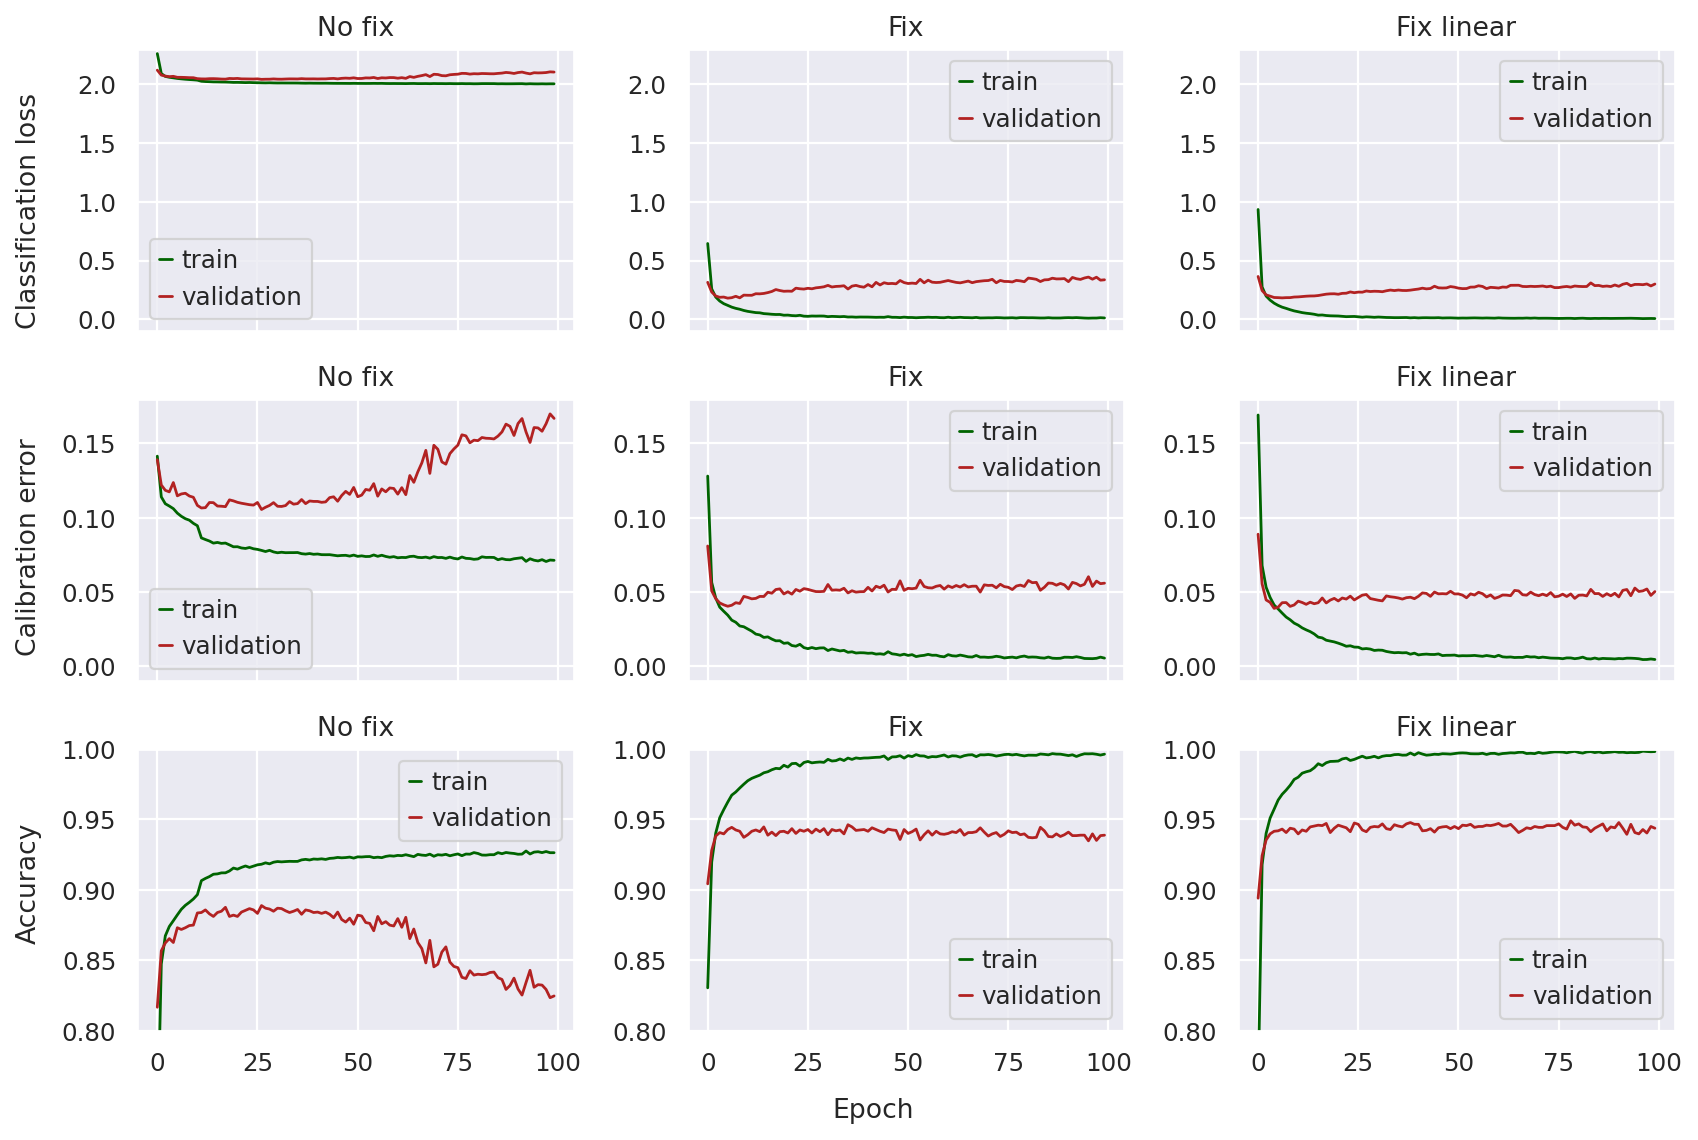

In [12]:
plot_classification_metrics(model_no_fix, model_fix, model_fix_linear)

Looking at the top row, we can immediately notice that the pre-fix model has a classification loss a magnitude larger than the other two (smaller is better). The curves don't seem as dramatic since the validation loss does not seem to diverge that much (*i.e.* the validation loss stays fairly close to the training loss), so we might incorrectly assume that the no fix model classifier is training with stability. 

However, once we take a look at the calibration error and accuracy, the problem is clear: in later epochs, these metrics increase (in the case of calibration error) or decrease (in the case of accuracy) sharply, indicating something wrong with model training.

This is not the case for the fixed models, where the classification loss is much lower throughout training, and both the calibration error and accuracy curves are much more stable. There does not seem to be too much of a difference between the fixed and fixed-linear model other than the linear one seeming a bit more "smooth".

## Plotting confusion matrices

Next, we plot confusion matrices for the validation observations. We are interested in just the validation split since the classifier will tend to overfit on the training set, so we'd like to see how it performs on unseen data.

In [13]:
def plot_confusion_matrices(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    subset: str | None = None,
    prediction_key: str = "_prediction",
    labels_key: str = "cell_type",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6.375), sharey=False, sharex=False)

    def plot_confusion_matrix(ax, model, title, subset):
        adata = model.adata
        adata.obs[prediction_key] = model.predict()

        if subset == "validation":
            adata = adata[model.validation_indices].copy()
        elif subset == "train":
            adata = adata[model.train_indices].copy()

        df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
        conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

        _ = ax.pcolor(conf_mat, cmap="cividis", vmin=0, vmax=1)
        _ = ax.set_xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
        _ = ax.set_yticks(np.arange(0.5, len(df.index), 1), df.index)
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for model, model_name, ax in zip(models, model_names, axes):
        plot_confusion_matrix(ax, model, model_name, subset)

    fig.text(0.0, 0.5, "Observed", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "Predicted", ha="center")
    fig.tight_layout()

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/tmp/ipykernel_158/1433242646.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/tmp/ipykernel_158/1433242646.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/tmp/ipykernel_158/1433242646.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)


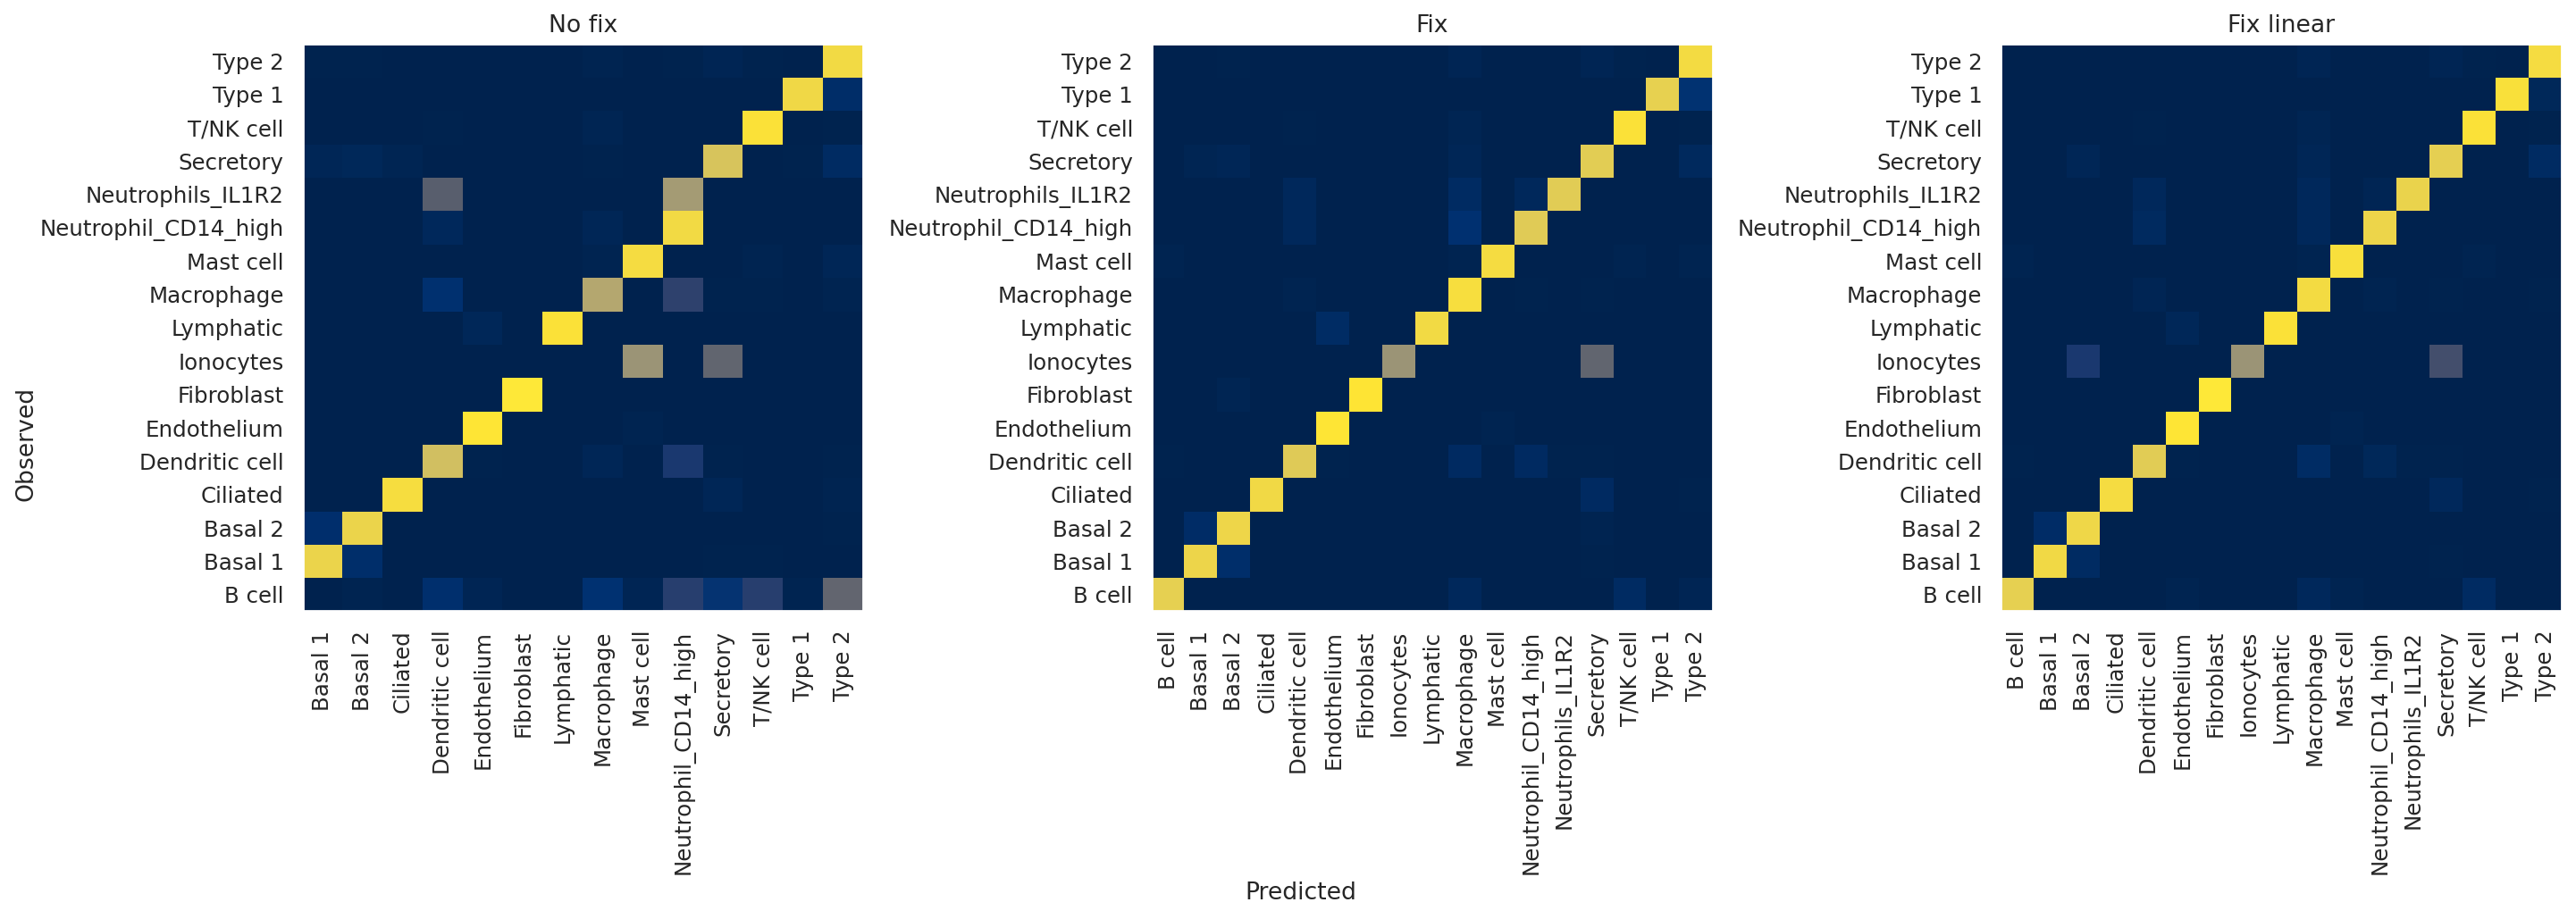

In [14]:
plot_confusion_matrices(model_no_fix, model_fix, model_fix_linear, subset="validation")

The x-axis indicates predicted labels, the y-axis observed labels, and the intensity of each square indicates the overlap between these two. In other words, if the square corresponding to "B cell observed" and "B cell predicted" has a value of 1 (bright yellow), this means that 100% of cells that the model classified as B cells have a ground truth label of B cells, and vice versa. A perfect classifier, then, would only have values of 1 along the diagonal and 0 elsewhere.

Qualitatively, we can appreciate that the no fix model performs very poorly, with, for example, almost no B cells being predicted by the model. On the other hand, the two fixed models seem to be performing well, with only slight differences between the two.

## Visualizing the embeddings

Visualizing the embeddings using minimum distortion embeddings (MDE) can be another useful qualitative check for evaluating how informative the model embeddings are of cell-type variability as well as batch integration performance.

In [15]:
def plot_latent_mdes(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    color: list | str | None = None,
    subset: str | None = None,
    latent_key: str = "_latent",
    mde_key: str = "_mde",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=False, sharex=False)

    def plot_latent_mde(ax, model, title, subset, legend_loc):
        adata = model.adata
        adata.obsm[latent_key] = model.get_latent_representation()

        if subset == "validation":
            adata = model.adata[model.validation_indices].copy()
        elif subset == "train":
            adata = model.adata[model.train_indices].copy()

        adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm[latent_key])
        sc.pl.embedding(
            adata,
            basis=mde_key,
            color=color,
            ncols=1,
            frameon=False,
            ax=ax,
            show=False,
            legend_loc=legend_loc,
        )
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]
    legend_loc = ["none", "none", "right margin"]

    for model, model_name, ax, leg_loc in zip(models, model_names, axes, legend_loc):
        plot_latent_mde(ax, model, model_name, subset, leg_loc)

    fig.text(0.0, 0.5, "MDE_2", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "MDE_1", ha="center")
    fig.tight_layout()

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


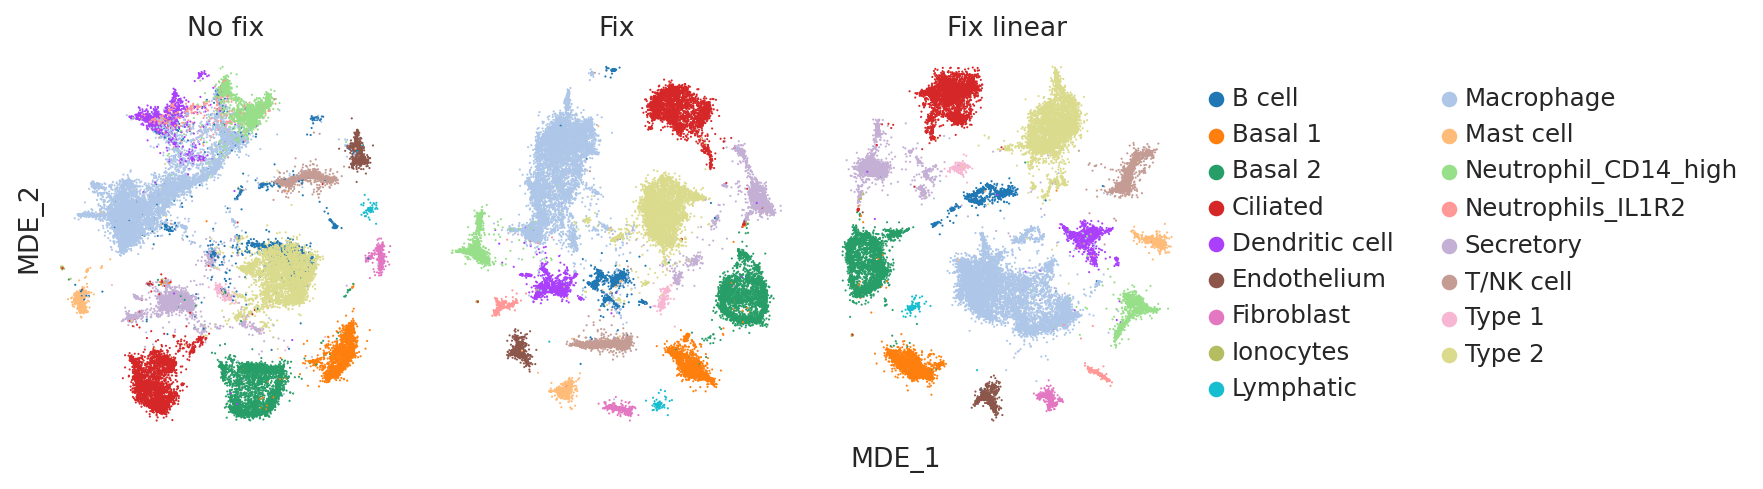

In [16]:
plot_latent_mdes(model_no_fix, model_fix, model_fix_linear, color="cell_type")

Once again, visually inspecting the embeddings confirms that the no fix model suffers from poor cell type identification (*e.g.* B cells and Type 2 cells are poorly separated).

## Comparing integration metrics

Finally, we can compute various integration metrics on the model embeddings to quantitatively assess their performance on biological conservation and batch integration. We rely on the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package for this. We start by computing the latent representations of each of these models.

In [17]:
X_SCVI_KEY = "X_scvi"
X_SCANVI_NO_FIX_KEY = "X_scanvi_no_fix"
X_SCANVI_FIX_KEY = "X_scanvi_fix"
X_SCANVI_FIX_LINEAR_KEY = "X_scanvi_fix_linear"

adata.obsm[X_SCVI_KEY] = scvi_model.get_latent_representation()
adata.obsm[X_SCANVI_NO_FIX_KEY] = model_no_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_KEY] = model_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_LINEAR_KEY] = model_fix_linear.get_latent_representation()

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [18]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=[
        "X_pca",
        X_SCVI_KEY,
        X_SCANVI_NO_FIX_KEY,
        X_SCANVI_FIX_KEY,
        X_SCANVI_FIX_LINEAR_KEY,
    ],
    n_jobs=-1,
)
bm.benchmark()


Computing neighbors:   0%|          | 0/5 [00:00<?, ?it/s]


Computing neighbors:  20%|██        | 1/5 [00:05<00:22,  5.75s/it]


Computing neighbors:  40%|████      | 2/5 [00:10<00:15,  5.12s/it]


Computing neighbors:  60%|██████    | 3/5 [00:15<00:10,  5.09s/it]


Computing neighbors:  80%|████████  | 4/5 [00:20<00:05,  5.14s/it]


Computing neighbors: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Computing neighbors: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]


Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:01<00:16,  1.87s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:01<00:16,  1.87s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:03<00:12,  1.58s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:03<00:12,  1.58s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:03<00:08,  1.15s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:03<00:08,  1.15s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [00:04<00:06,  1.10s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [00:04<00:06,  1.10s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:19<00:29,  5.84s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:19<00:29,  5.84s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [00:19<00:15,  3.91s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [00:19<00:15,  3.91s/it, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [00:38<00:26,  8.91s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [00:38<00:26,  8.91s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [00:38<00:17,  8.91s/it, Batch correction: pcr_comparison]    


Metrics:  90%|█████████ | 9/10 [00:39<00:04,  4.73s/it, Batch correction: pcr_comparison]


Embeddings:  20%|██        | 1/5 [00:39<02:36, 39.06s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  1.83it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  1.83it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:06,  1.22it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:06,  1.22it/s, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:01<00:04,  1.55it/s, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:01<00:04,  1.55it/s, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [00:04<00:03,  1.11it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [00:20<00:12,  4.07s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [00:20<00:12,  4.07s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [00:20<00:08,  4.07s/it, Batch correction: pcr_comparison]    


Metrics:  90%|█████████ | 9/10 [00:20<00:02,  2.55s/it, Batch correction: pcr_comparison]


Embeddings:  40%|████      | 2/5 [00:59<01:24, 28.14s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.16it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.16it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.69it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.69it/s, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.91it/s, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.91it/s, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [00:01<00:03,  1.91it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.77it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.77it/s, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [00:01<00:01,  3.77it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [00:16<00:10,  3.37s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [00:16<00:10,  3.37s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [00:16<00:06,  3.37s/it, Batch correction: pcr_comparison]    


Embeddings:  60%|██████    | 3/5 [01:15<00:45, 22.68s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.21it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.21it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.71it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.71it/s, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.92it/s, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.92it/s, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [00:01<00:03,  1.92it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.76it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.76it/s, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [00:01<00:01,  3.76it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [00:15<00:09,  3.25s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [00:15<00:09,  3.25s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [00:15<00:06,  3.25s/it, Batch correction: pcr_comparison]    


Embeddings:  80%|████████  | 4/5 [01:31<00:19, 19.91s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.18it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:00<00:04,  2.18it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.72it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:01<00:04,  1.72it/s, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.93it/s, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:01<00:03,  1.93it/s, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [00:01<00:03,  1.93it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [00:01<00:01,  3.80it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [00:13<00:08,  2.83s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [00:13<00:08,  2.83s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [00:13<00:05,  2.83s/it, Batch correction: pcr_comparison]    


Embeddings: 100%|██████████| 5/5 [01:45<00:00, 17.69s/it]


Embeddings: 100%|██████████| 5/5 [01:45<00:00, 21.03s/it]

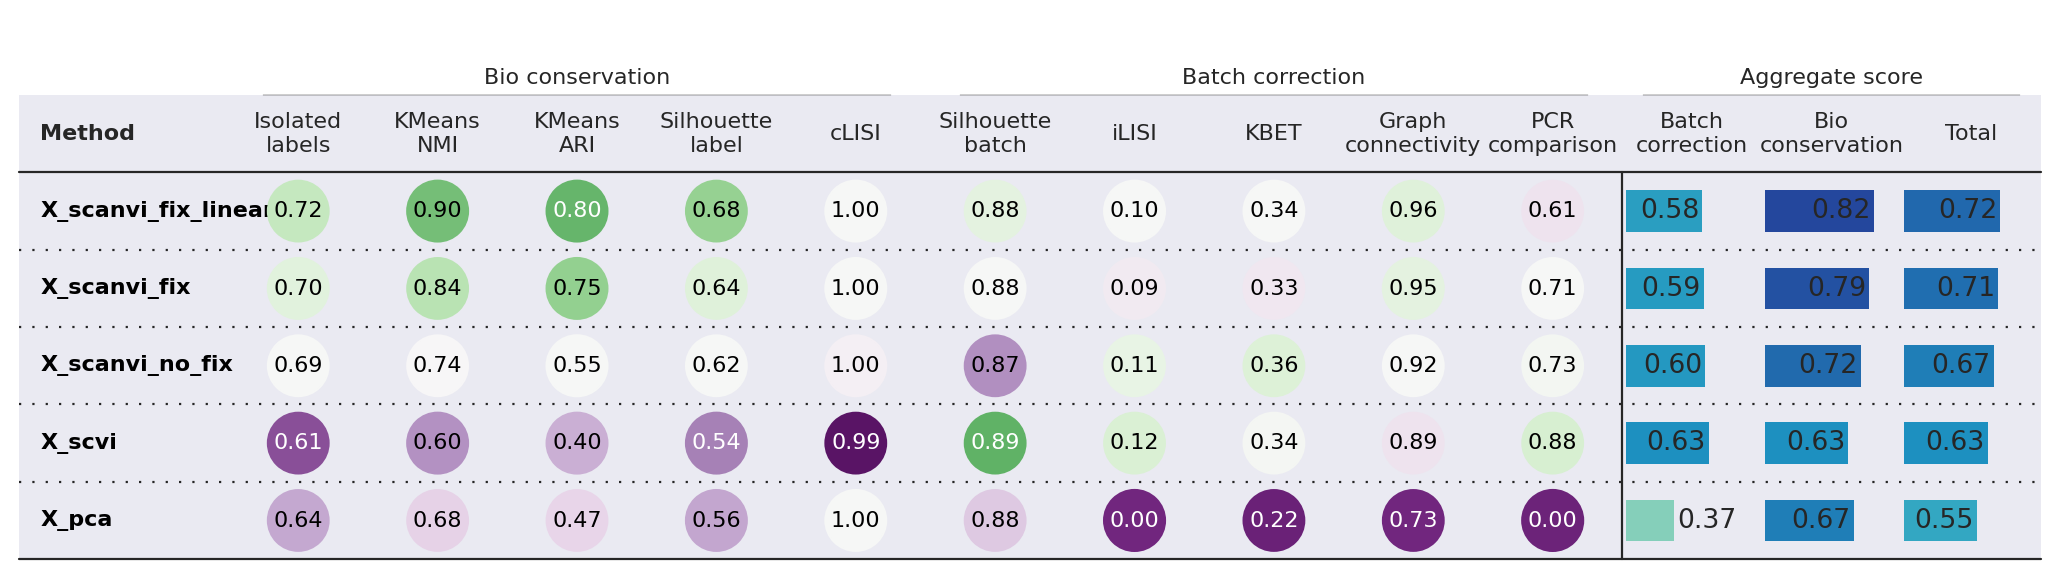

In [19]:
bm.plot_results_table(min_max_scale=False)

While batch integration performance seems to degrade slightly from the pre-fix to fixed models, the difference is very small compared to the increased performance in bio-conservation. Particularly, we note a noticeable increase with using the linear classifier.